# Boston Housing Data Experiment 
Semi-synthetic dataset experiment


In [3]:
import sys 
sys.path.append('../..')
import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from delphi import oracle 
from delphi.stats.linear_regression import TruncatedLinearRegression

# Load Boston Housing Dataset into Notebook
You need to download the [Boston housing dataset](https://www.kaggle.com/altavish/boston-housing-dataset) dataset from the kaggle.

In [4]:
BOSTON_HOUSING_DATASET_PATH = '/home/pstefanou/data/HousingData.csv'
bh_df = pd.read_csv(BOSTON_HOUSING_DATASET_PATH)
bh_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


# Data Exploration
First, we will explore our dataset and determine which features that we can to include for our multiple linear regression problem.

In [5]:
# remove rows in dataframe with a nan
clean_bh_df = bh_df.dropna().reset_index()

When first exploring the features of our dataset, we compare the the mean the and the median values of the features from our dataset. We can see that for the ZN, TAX, CRIM, and B features that our mean and median features have both skewed distributions and more outliers.

In [6]:
print("mean: ", clean_bh_df.mean()) 
print("median: ", clean_bh_df.median())

mean:  index      250.167513
CRIM         3.690136
ZN          11.460660
INDUS       11.000863
CHAS         0.068528
NOX          0.553215
RM           6.280015
AGE         68.932741
DIS          3.805268
RAD          9.403553
TAX        406.431472
PTRATIO     18.537563
B          358.490939
LSTAT       12.769112
MEDV        22.359645
dtype: float64
median:  index      252.50000
CRIM         0.26888
ZN           0.00000
INDUS        8.56000
CHAS         0.00000
NOX          0.53800
RM           6.20150
AGE         77.70000
DIS          3.19920
RAD          5.00000
TAX        330.00000
PTRATIO     19.10000
B          392.19000
LSTAT       11.30000
MEDV        21.05000
dtype: float64


Now, we examine the box plots of these features. When looking at the box plots, we can see that 

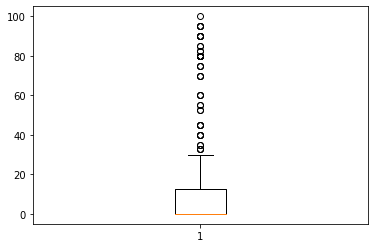

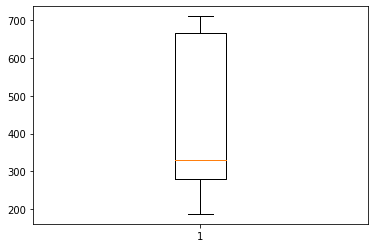

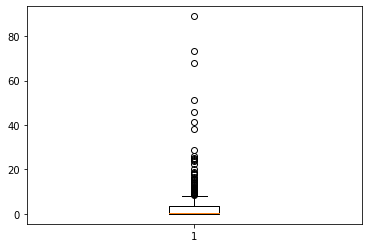

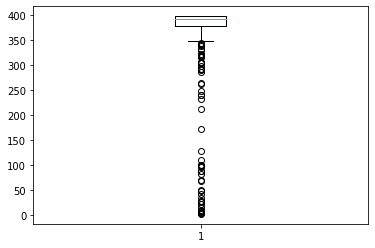

In [7]:
plt.boxplot(clean_bh_df['ZN'])
plt.show()
plt.boxplot(clean_bh_df['TAX'])
plt.show()
plt.boxplot(clean_bh_df['CRIM'])
plt.show()
plt.boxplot(clean_bh_df['B'])
plt.show()

By plotting the density of the target variable MDEV, we can see that the target variable MEDV is normally distributed, with a few outliers. 

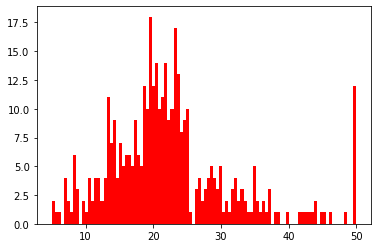

In [8]:
plt.hist(clean_bh_df['MEDV'], bins=100, color='red')
plt.show()

Next, by looking at the correlation matrix, we can see that the most influential features on house price are LSTAT and RM. LSTAT has a strong negative correlation with MEDV, while RM has a strong one. Intuitively, this makes sense as RM represents the numebr of rooms in the house; houses tend to cost more if they have more rooms. Further, LSTAT represents the percentage of lower status of the population; house prices tend to reflect the financial status of the population.

In [9]:
corr_matrix = clean_bh_df.corr()
corr_matrix

,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
index,1.000000,0.386190,-0.124485,0.416085,0.015651,0.423807,-0.112059,0.198928,-0.318038,0.677400,0.663656,0.245907,-0.285218,0.275586,-0.239658
CRIM,0.386190,1.000000,-0.188075,0.391552,-0.051970,0.416160,-0.227170,0.341311,-0.365052,0.608667,0.560841,0.265428,-0.386254,0.461906,-0.397230
ZN,-0.124485,-0.188075,1.000000,-0.521256,-0.033357,-0.515660,0.343210,-0.568174,0.645359,-0.298773,-0.305768,-0.422164,0.169894,-0.415041,0.406822
INDUS,0.416085,0.391552,-0.521256,1.000000,0.049820,0.762737,-0.403068,0.642387,-0.696569,0.591944,0.734204,0.395691,-0.344788,0.598156,-0.510829
CHAS,0.015651,-0.051970,-0.033357,0.049820,1.000000,0.076661,0.095308,0.072644,-0.095037,0.014102,-0.026513,-0.104995,0.068913,-0.037113,0.173701
NOX,0.423807,0.416160,-0.515660,0.762737,0.076661,1.000000,-0.316563,0.732540,-0.768137,0.628170,0.679824,0.210216,-0.384257,0.593655,-0.459054
RM,-0.112059,-0.227170,0.343210,-0.403068,0.095308,-0.316563,1.000000,-0.248670,0.218713,-0.236057,-0.320561,-0.390686,0.123320,-0.636226,0.723951
AGE,0.198928,0.341311,-0.568174,0.642387,0.072644,0.732540,-0.248670,1.000000,-0.753547,0.443585,0.504472,0.264968,-0.281990,0.601137,-0.407470
DIS,-0.318038,-0.365052,0.645359,-0.696569,-0.095037,-0.768137,0.218713,-0.753547,1.000000,-0.477075,-0.529603,-0.228840,0.285168,-0.505036,0.279547
RAD,0.677400,0.608667,-0.298773,0.591944,0.014102,0.628170,-0.236057,0.443585,-0.477075,1.000000,0.900000,0.441949,-0.444135,0.510868,-0.416638


Look at the Correlation Between LSTAT and MEDV. We notice that although there is a strong correlation between LSTAT and MEDV, we can see that the relationship is non-linear.

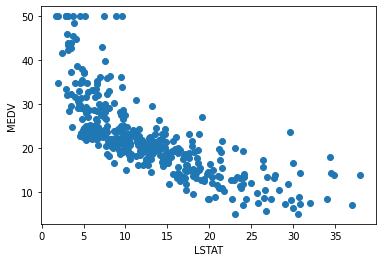

In [10]:
lstat, medv = np.expand_dims(clean_bh_df['LSTAT'].to_numpy(), 1), np.expand_dims(clean_bh_df['MEDV'].to_numpy(), 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(clean_bh_df['LSTAT'], clean_bh_df['MEDV'])
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.show()

After looking at the scatter plot, we see that there is a negative correlation the percentage of the population that is lower class and the average price of the house in the area. Intuitively, this makes sense. Nowe, let's see what our ols fit looks like. 

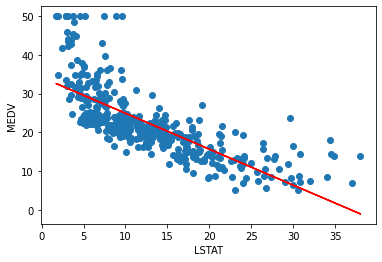

In [11]:
from sklearn.linear_model import LinearRegression 

ols = LinearRegression() 
ols.fit(lstat, medv)

ax = plt.subplot(1, 1, 1)
plt.scatter(lstat, medv)
plt.plot(lstat, ols.predict(lstat), color='red')
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.show()

Now, let's see how our ols fits with respect to the linear regression latent variable model. I will do this by adding Gaussian noise to what we consider to be the ground-truth regression. 

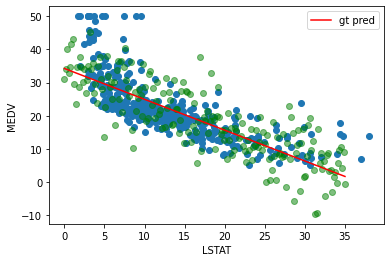

In [13]:
# create data for predicting regression values
data = np.linspace(0, 35, 200).reshape(200, 1)
gt_pred = ols.predict(data)

# calculate empirical noise std
gt_var = (medv - ols.predict(lstat)).var(0)


ax = plt.subplot(1, 1, 1)
plt.scatter(lstat, medv)
plt.plot(data, gt_pred, color='red', label='gt pred')

plt.scatter(data, gt_pred + np.sqrt(gt_var)*np.random.randn(data.shape[0], 1), color='green', alpha=.5)
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.legend()
plt.show()

# Truncate Normal Dataset

Now, let's see what happens when we truncate our dataset at 25.

percentage of remaining samples:  1.0
R2 Score:  0.5417133384095295


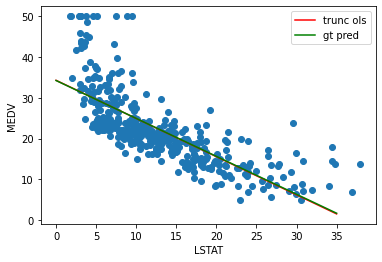

In [25]:
phi = oracle.Right(Tensor([51.0]))
# truncate data set
filtered = phi(Tensor(medv))
indices = filtered.nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = lstat[indices], medv[indices]

alpha = Tensor([x_trunc.shape[0] / lstat.shape[0]])
print("percentage of remaining samples: ", float(alpha))

# create training and validation datasets
train_size = int(.8*len(x_trunc))
rand_indices = np.random.permutation(x_trunc.shape[0])
train_indices, val_indices = rand_indices[:train_size], rand_indices[train_size:]
x_trunc_train, y_trunc_train = Tensor(x_trunc[train_indices]), Tensor(y_trunc[train_indices])
x_trunc_val, y_trunc_val = Tensor(x_trunc[val_indices]), Tensor(y_trunc[val_indices])

# trunc ols
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc_train, y_trunc_train)
r2_score = trunc_ols.score(x_trunc_val, y_trunc_val)
print("R2 Score: ", r2_score)

data_stand = np.expand_dims(np.linspace(-1.5, 3, 100), 1)
data_stand_pt = Tensor(data_stand)
trunc_ols_pred = trunc_ols.predict(data)
ax = plt.subplot(1, 1, 1)
plt.scatter(x_trunc, y_trunc)
plt.plot(data, trunc_ols_pred, color='red', label='trunc ols')
plt.plot(data, ols.predict(data), color='green', label='gt pred')
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.legend()
plt.show()

In [26]:
ch.manual_seed(0)

# experiment hyperparameters
args = Parameters({ 
    'workers': 2, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 2.0, 
    'lr': 1e-1,
    'var_lr': 1e-1,
    'step_lr': 10000, 
#     'custom_lr_multiplier': consts.COSINE,
    'step_lr_gamma': 1.0,
    'tol': 1e-5,
})
print("args: ", args)

# ols on truncated dataset 
trunc_ols = LinearRegression().fit(x_trunc_train, y_trunc_train)
trunc_var = Tensor(y_trunc_train - trunc_ols.predict(x_trunc_train)).var(0)

# truncated linear regression with known noise variance using ground truth noise variance
known_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=Tensor(gt_var))
known_results = known_trunc_reg.fit(x_trunc_train, y_trunc_train)
w_, w0_ = known_results.weight.detach().cpu(), known_results.bias.detach().cpu()

# truncated linear regression with known noise variance using empirical noise variance
known_emp_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=trunc_var)
known_emp_results = known_emp_trunc_reg.fit(x_trunc_train, y_trunc_train)
w_, w0_ = known_emp_results.weight.detach().cpu(), known_emp_results.bias.detach().cpu()

# truncated regression with unknown noise variance
unknown_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias)
unknown_results = unknown_trunc_reg.fit(x_trunc_train, y_trunc_train)
unknown_var = unknown_results.lambda_.inverse()
w_, w0_ = unknown_results.layer.weight.detach().cpu() * unknown_var, unknown_results.layer.bias.detach().cpu() * unknown_var

args:  {
  "workers": 2,
  "batch_size": 10,
  "bias": true,
  "num_samples": 100,
  "clamp": true,
  "radius": 2.0,
  "lr": 0.1,
  "var_lr": 0.1,
  "step_lr": 10000,
  "step_lr_gamma": 1.0,
  "tol": 1e-05
}


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

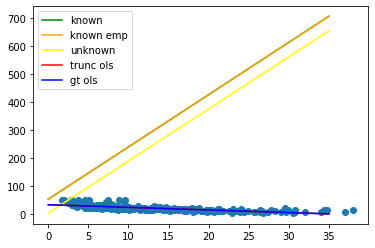

In [27]:
# plot linear regressions
plt.scatter(x_trunc_train, y_trunc_train)
plt.plot(data, known_results(Tensor(data)).detach().cpu(), color='green', label='known')
plt.plot(data, known_emp_results(Tensor(data)).detach().cpu(), color='orange', label='known emp')
plt.plot(data, unknown_results(Tensor(data)).detach().cpu(), color='yellow', label='unknown')
plt.plot(data, trunc_ols.predict(data), color='red', label='trunc ols')
plt.plot(data, ols.predict(data), color='blue', label='gt ols')
plt.legend()

In [28]:
unknown_results.layer.weight.grad, unknown_results.layer.bias.grad, unknown_results.lambda_.grad

(tensor([[-537.7616]]), tensor([[-30.7594]]), tensor([[-28.4616]]))

We notice that due to the magnitude of the features, our gradients became unbounded. To account for this, we will now try both standardizing and normalizing our dataset to see if this provides more stable results.

# Normalize the Data 

alpha:  tensor([0.9391])


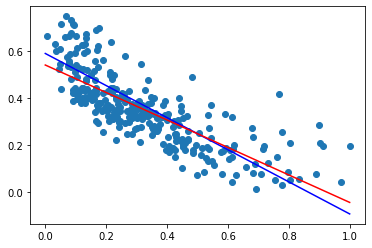

In [36]:
# create training and validation datasets
train_size = int(.8*len(lstat))
rand_indices = np.random.permutation(lstat.shape[0])
train_indices, val_indices = rand_indices[:train_size], rand_indices[train_size:]

# normalize dataset based off of validation set min and max
lstat_max, medv_max = np.max(lstat), np.max(medv)
lstat_min, medv_min = np.min(lstat), np.min(medv)

norm_lstat = (lstat - lstat_min) / (lstat_max - lstat_min)
norm_medv = (medv - medv_min) / (medv_max - medv_min)

# separate the standardized dataset into training and vlidation sets
norm_train_lstat, norm_train_medv = norm_lstat[train_indices], norm_medv[train_indices]
norm_val_lstat, norm_val_medv = norm_lstat[val_indices], norm_medv[val_indices]

gt_norm_ols = LinearRegression()
gt_norm_ols.fit(norm_train_lstat, norm_train_medv)
norm_var = Tensor(norm_medv - trunc_ols.predict(norm_lstat)).var(0)

data_norm = np.expand_dims(np.linspace(0, 1.0, 100), 1)

# truncate dataset at .75
phi = oracle.Right(Tensor([.75]))

train_filtered = phi(Tensor(norm_train_medv))
train_indices = train_filtered.nonzero(as_tuple=False).flatten()

val_filtered = phi(Tensor(norm_val_medv))
val_indices = val_filtered.nonzero(as_tuple=False).flatten()

x_trunc_train, y_trunc_train = Tensor(norm_train_lstat[train_indices]), Tensor(norm_train_medv[train_indices])
x_trunc_val, y_trunc_val = Tensor(norm_val_lstat[val_indices]), Tensor(norm_val_medv[val_indices])

x_trunc_test = 

alpha = Tensor([(x_trunc_train.size(0) + x_trunc_val.size(0)) / lstat.shape[0]])
print("alpha: ", alpha)

# ols on truncated dataset 
trunc_norm_ols = LinearRegression().fit(x_trunc_train, y_trunc_train)
trunc_norm_var = Tensor(y_trunc_train - trunc_ols.predict(x_trunc_train)).var(0)

plt.scatter(x_trunc_train, y_trunc_train)
plt.plot(data_norm, gt_norm_ols.predict(data_norm), color='blue', label='gt norm')
plt.plot(data_norm, trunc_norm_ols.predict(data_norm), color='red', label='gt trunc norm')

In [30]:
# experiment hyperparameters
args = Parameters({ 
    'workers': 2, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 2.0, 
    'lr': 1e-1,
    'var_lr': 1e-2,
    'step_lr': 200000, 
#     'custom_lr_multiplier': consts.COSINE,
    'step_lr_gamma': 1.0,
    'tol': 1e-5,
})
print("args: ", args)

# truncated linear regression with known noise variance using ground truth noise variance
known_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=norm_var)
known_results = known_trunc_reg.fit(x_trunc_train, y_trunc_train)
w_, w0_ = known_results.weight.detach().cpu(), known_results.bias.detach().cpu()

# truncated linear regression with known noise variance using empirical noise variance
known_emp_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=trunc_norm_var)
known_emp_results = known_emp_trunc_reg.fit(x_trunc_train, y_trunc_train)
w_, w0_ = known_emp_results.weight.detach().cpu(), known_emp_results.bias.detach().cpu()

# truncated regression with unknown noise variance
unknown_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias)
unknown_results = unknown_trunc_reg.fit(x_trunc_train, y_trunc_train)
w_, w0_ = unknown_results.layer.weight.detach().cpu(), unknown_results.layer.bias.detach().cpu()

# plot linear regressions
plt.scatter(x_trunc_train, y_trunc_train)
plt.plot(data_norm, known_results(Tensor(data_norm)).detach().cpu(), color='green', label='known')
plt.plot(data_norm, known_emp_results(Tensor(data_norm)).detach().cpu(), color='orange', label='known emp')
plt.plot(data_norm, unknown_results(Tensor(data_norm)).detach().cpu(), color='yellow', label='unknown')
plt.plot(data_norm, trunc_norm_ols.predict(data_norm), color='red', label='trunc ols')
plt.plot(data_norm, gt_norm_ols.predict(data_norm), color='blue', label='gt norm ols')
plt.legend()

args:  {
  "workers": 2,
  "batch_size": 10,
  "bias": true,
  "num_samples": 100,
  "clamp": true,
  "radius": 2.0,
  "lr": 0.1,
  "var_lr": 0.01,
  "step_lr": 200000,
  "step_lr_gamma": 1.0,
  "tol": 1e-05
}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
unknown_results.layer.weight.grad, unknown_results.layer.bias.grad, unknown_results.lambda_.grad

(tensor([[-0.0748]]), tensor([[-0.3033]]), tensor([[0.0503]]))

We now see that by normalizing the data, our estimated regression resembles the empirical regression significantly. We can explain by the fact that our dataset became extremely compact after normalizing the data. This left us with a variance estimate that was extremely. Due to this, our algorithm acted as if there was no noise variance added to regression's predictions. 

# Standardize the Data

alpha:  tensor([0.5838])


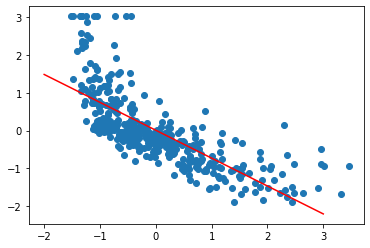

In [34]:
# create training and validation datasets
train_size = int(.8*len(lstat))
rand_indices = np.random.permutation(lstat.shape[0])
train_indices, val_indices = rand_indices[:train_size], rand_indices[train_size:]

# standardize dataset based off of validation set mean and variance
lstat_mu, medv_mu = lstat.mean(0), medv.mean(0)
lstat_sigma, medv_sigma = np.sqrt(lstat.var(0)), np.sqrt(medv.var(0))

std_lstat = (lstat - lstat_mu) / lstat_sigma
std_medv = (medv - medv_mu) / medv_sigma

# separate the standardized dataset into training and vlidation sets
std_train_lstat, std_train_medv = std_lstat[train_indices], std_medv[train_indices]
std_val_lstat, std_val_medv = std_lstat[val_indices], std_medv[val_indices]

gt_std_ols = LinearRegression()
gt_std_ols.fit(std_train_lstat, std_train_medv)

data_std = np.expand_dims(np.linspace(-2.0, 3.0, 100), 1)

plt.scatter(np.concatenate([std_train_lstat, std_val_lstat]), np.concatenate([std_train_medv, std_val_medv]))
plt.plot(data_std, gt_std_ols.predict(data_std), color='red')

# truncate dataset at 0
phi = oracle.Right(Tensor([0.0]))

train_filtered = phi(Tensor(std_train_medv))
train_indices = train_filtered.nonzero(as_tuple=False).flatten()

val_filtered = phi(Tensor(std_val_medv))
val_indices = val_filtered.nonzero(as_tuple=False).flatten()

x_trunc_train, y_trunc_train = Tensor(std_train_lstat[train_indices]), Tensor(std_train_medv[train_indices])
x_trunc_val, y_trunc_val = Tensor(std_val_lstat[val_indices]), Tensor(std_val_medv[val_indices])

alpha = Tensor([(x_trunc_train.size(0) + x_trunc_val.size(0)) / lstat.shape[0]])
print("alpha: ", alpha)

std_var = Tensor(std_medv - gt_std_ols.predict(std_lstat)).var(0)

In [33]:
x_trunc_train.size(0) + x_trunc_val.size(0), lstat.shape[0]

(230, 394)

args:  {
  "workers": 2,
  "batch_size": 10,
  "bias": true,
  "num_samples": 100,
  "clamp": true,
  "radius": 2.0,
  "lr": 0.1,
  "steps": 1500,
  "var_lr": 0.01,
  "step_lr": 200000,
  "step_lr_gamma": 1.0,
  "tol": 0.01
}


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

lambda shape:  torch.Size([1, 1])
weight shape:  torch.Size([1, 1])
bias shape:  torch.Size([1, 1])


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

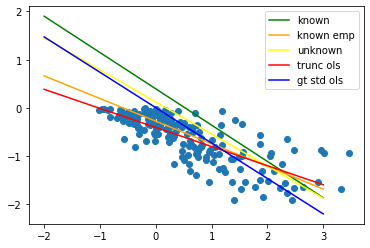

In [59]:
# experiment hyperparameters
args = Parameters({ 
    'workers': 2, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 2.0, 
    'lr': 1e-1,
    'steps': 1500, 
    'var_lr': 1e-2,
    'step_lr': 200000, 
#     'custom_lr_multiplier': consts.COSINE,
    'step_lr_gamma': 1.0,
    'tol': 1e-2,
})
print("args: ", args)

# ols on truncated dataset 
trunc_ols = LinearRegression().fit(x_trunc_train, y_trunc_train)
trunc_var = Tensor(y_trunc_train - trunc_ols.predict(x_trunc_train)).var(0)

# truncated linear regression with known noise variance using ground truth noise variance
known_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=std_var)
known_results = known_trunc_reg.fit(x_trunc_train, y_trunc_train)
w_, w0_ = known_results.weight.detach().cpu(), known_results.bias.detach().cpu()

# truncated linear regression with known noise variance using empirical noise variance
known_emp_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=trunc_var)
known_emp_results = known_emp_trunc_reg.fit(x_trunc_train, y_trunc_train)
w_, w0_ = known_emp_results.weight.detach().cpu(), known_emp_results.bias.detach().cpu()

# truncated regression with unknown noise variance
unknown_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias)
unknown_results = unknown_trunc_reg.fit(x_trunc_train, y_trunc_train)
w_, w0_ = unknown_results.layer.weight.detach().cpu(), unknown_results.layer.bias.detach().cpu()

# plot linear regressions
plt.scatter(x_trunc_train, y_trunc_train)
plt.plot(data_std, known_results(Tensor(data_std)).detach().cpu(), color='green', label='known')
plt.plot(data_std, known_emp_results(Tensor(data_std)).detach().cpu(), color='orange', label='known emp')
plt.plot(data_std, unknown_results(Tensor(data_std)).detach().cpu(), color='yellow', label='unknown')
plt.plot(data_std, trunc_ols.predict(data_std), color='red', label='trunc ols')
plt.plot(data_std, gt_std_ols.predict(data_std), color='blue', label='gt std ols')
plt.legend()

In [30]:
unknown_results.layer.weight.grad, unknown_results.layer.bias.grad, unknown_results.lambda_.grad, alpha

(tensor([[0.2702]]), tensor([[0.1418]]), tensor([[0.1493]]), tensor([0.4721]))

In [24]:
known_results.weight.grad, known_results.bias.grad, alpha

(tensor([[0.1248]]), tensor([-0.0363]), tensor([0.4772]))

In [25]:
known_emp_results.weight.grad, known_emp_results.bias.grad, alpha

(tensor([[0.0132]]), tensor([0.0174]), tensor([0.4772]))

Now, when we standardize the data, we  see that our algorithm reduces a significant amount of the bias. 

As we can see, the right truncation causes of empirical regression estimates to be biased. We now will run the following regression experiments to show how our proposed algorithm can correct for this bias. 
The procedure that we will run will include runnng Daskalakis, et al. 2019 wth known variance by giving the procedure the actual average variance across ground-truth regression and then another procedure where we give it the empirical variance. After that, we will run our procedure which corrects for the bias without assuming the model's variance, and predicts it. 

In [41]:
# experiment hyperparameters
args = Parameters({ 
    'workers': 2, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 2.0, 
    'var_lr': 1e-3,
    'lr': 1e-3,
    'step_lr': 200000, 
    'step_lr_gamma': 1.0
})
print("args: ", args)

args:  {
  "workers": 2,
  "batch_size": 10,
  "bias": true,
  "num_samples": 100,
  "clamp": true,
  "radius": 2.0,
  "var_lr": 0.001,
  "lr": 0.001,
  "step_lr": 200000,
  "step_lr_gamma": 1.0
}


In [24]:
ch.manual_seed(0)

# truncated linear regression with known noise variance using empirical noise variance
known_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=Tensor(gt_var_stand))
known_results = known_trunc_reg.fit(x_trunc_stand_pt, y_trunc_stand_pt)
w_, w0_ = known_results.weight.detach().cpu(), known_results.bias.detach().cpu()

# truncated linear regression with known noise variance using actual noise variance
trunc_var = Tensor((y_trunc_stand - trunc_ols.predict(x_trunc_stand)).var(0))
known_emp_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=trunc_var)
known_emp_results = known_emp_trunc_reg.fit(x_trunc_stand_pt, y_trunc_stand_pt)
w__, w0__ = known_emp_results.weight.detach().cpu(), known_emp_results.bias.detach().cpu()

# truncated linear regression with unknown noise variance
unknown_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias)
unknown_results = unknown_trunc_reg.fit(x_trunc_stand_pt, y_trunc_stand_pt)
var_ = unknown_results.lambda_.inverse().detach()
w, w0 = (unknown_results.layer.weight.detach()*var_).cpu(), (unknown_results.layer.bias.detach()*var_).cpu()

  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0527]])
bias grad:  tensor([-0.2229])
weight grad:  tensor([[-0.0696]])
bias grad:  tensor([-0.2397])
weight grad:  tensor([[-0.1063]])
bias grad:  tensor([-0.2580])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0241]])
bias grad:  tensor([-0.1827])
weight grad:  tensor([[0.0508]])
bias grad:  tensor([-0.1782])
weight grad:  tensor([[-0.0069]])
bias grad:  tensor([-0.2120])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0127]])
bias grad:  tensor([-0.1664])
weight grad:  tensor([[0.0840]])
bias grad:  tensor([-0.1334])
weight grad:  tensor([[0.0481]])
bias grad:  tensor([-0.1127])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0427]])
bias grad:  tensor([-0.1668])
weight grad:  tensor([[0.0554]])
bias grad:  tensor([-0.1310])
weight grad:  tensor([[0.0529]])
bias grad:  tensor([-0.0807])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0107]])
bias grad:  tensor([-0.1658])
weight grad:  tensor([[0.0948]])
bias grad:  tensor([-0.1018])
weight grad:  tensor([[0.1536]])
bias grad:  tensor([-0.0398])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0056]])
bias grad:  tensor([-0.1587])
weight grad:  tensor([[0.0591]])
bias grad:  tensor([-0.1063])
weight grad:  tensor([[0.0808]])
bias grad:  tensor([-0.0673])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0962]])
bias grad:  tensor([-0.0823])
weight grad:  tensor([[0.0237]])
bias grad:  tensor([-0.1126])
weight grad:  tensor([[-0.0428]])
bias grad:  tensor([-0.1766])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0605]])
bias grad:  tensor([-0.0973])
weight grad:  tensor([[0.0332]])
bias grad:  tensor([-0.0942])
weight grad:  tensor([[0.0648]])
bias grad:  tensor([-0.1064])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0319]])
bias grad:  tensor([-0.0731])
weight grad:  tensor([[0.0656]])
bias grad:  tensor([-0.1269])
weight grad:  tensor([[0.0521]])
bias grad:  tensor([-0.0218])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0369]])
bias grad:  tensor([-0.0878])
weight grad:  tensor([[0.0550]])
bias grad:  tensor([-0.0796])
weight grad:  tensor([[0.1015]])
bias grad:  tensor([-0.0750])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0668]])
bias grad:  tensor([-0.0399])
weight grad:  tensor([[0.0465]])
bias grad:  tensor([-0.1098])
weight grad:  tensor([[-0.0104]])
bias grad:  tensor([-0.0674])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0013]])
bias grad:  tensor([-0.1258])
weight grad:  tensor([[0.0920]])
bias grad:  tensor([-0.0071])
weight grad:  tensor([[0.0684]])
bias grad:  tensor([-0.0620])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0140]])
bias grad:  tensor([-0.0600])
weight grad:  tensor([[0.0445]])
bias grad:  tensor([-0.0923])
weight grad:  tensor([[0.0826]])
bias grad:  tensor([-0.0582])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0324]])
bias grad:  tensor([-0.0771])
weight grad:  tensor([[0.0190]])
bias grad:  tensor([-0.0634])
weight grad:  tensor([[0.0653]])
bias grad:  tensor([-0.0437])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0195]])
bias grad:  tensor([-0.0795])
weight grad:  tensor([[0.0213]])
bias grad:  tensor([-0.0692])
weight grad:  tensor([[0.1089]])
bias grad:  tensor([0.0025])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1075]])
bias grad:  tensor([0.0013])
weight grad:  tensor([[-0.0309]])
bias grad:  tensor([-0.1121])
weight grad:  tensor([[-0.1180]])
bias grad:  tensor([-0.1086])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0655]])
bias grad:  tensor([-0.0379])
weight grad:  tensor([[0.0166]])
bias grad:  tensor([-0.0600])
weight grad:  tensor([[0.0754]])
bias grad:  tensor([-0.0671])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0367]])
bias grad:  tensor([-0.0846])
weight grad:  tensor([[0.0818]])
bias grad:  tensor([-0.0294])
weight grad:  tensor([[0.1624]])
bias grad:  tensor([0.0200])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0139]])
bias grad:  tensor([-0.0834])
weight grad:  tensor([[0.0142]])
bias grad:  tensor([-0.0456])
weight grad:  tensor([[0.1382]])
bias grad:  tensor([-0.0037])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0868]])
bias grad:  tensor([-0.0808])
weight grad:  tensor([[0.0914]])
bias grad:  tensor([-0.0496])
weight grad:  tensor([[0.0840]])
bias grad:  tensor([0.0166])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0155]])
bias grad:  tensor([-0.0781])
weight grad:  tensor([[0.0048]])
bias grad:  tensor([-0.0429])
weight grad:  tensor([[0.0374]])
bias grad:  tensor([-0.0058])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0876]])
bias grad:  tensor([-0.0019])
weight grad:  tensor([[-0.0911]])
bias grad:  tensor([-0.1002])
weight grad:  tensor([[0.0804]])
bias grad:  tensor([-0.0347])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0096]])
bias grad:  tensor([-0.0436])
weight grad:  tensor([[0.0009]])
bias grad:  tensor([-0.0565])
weight grad:  tensor([[0.0933]])
bias grad:  tensor([-0.0061])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0053]])
bias grad:  tensor([-0.0711])
weight grad:  tensor([[-0.0125]])
bias grad:  tensor([-0.0303])
weight grad:  tensor([[0.1263]])
bias grad:  tensor([-0.0065])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0279]])
bias grad:  tensor([-0.0499])
weight grad:  tensor([[-0.0380]])
bias grad:  tensor([-0.0604])
weight grad:  tensor([[0.0584]])
bias grad:  tensor([0.0373])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0633]])
bias grad:  tensor([-0.0994])
weight grad:  tensor([[0.1178]])
bias grad:  tensor([0.0404])
weight grad:  tensor([[-0.1058]])
bias grad:  tensor([-0.0902])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0481]])
bias grad:  tensor([-0.0101])
weight grad:  tensor([[-0.0426]])
bias grad:  tensor([-0.0724])
weight grad:  tensor([[0.0528]])
bias grad:  tensor([-0.0240])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0600]])
bias grad:  tensor([0.0200])
weight grad:  tensor([[-0.0448]])
bias grad:  tensor([-0.0833])
weight grad:  tensor([[0.0181]])
bias grad:  tensor([-0.0242])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0048]])
bias grad:  tensor([-0.0452])
weight grad:  tensor([[0.0032]])
bias grad:  tensor([-0.0382])
weight grad:  tensor([[0.0542]])
bias grad:  tensor([-0.0183])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0243]])
bias grad:  tensor([0.0001])
weight grad:  tensor([[0.0050]])
bias grad:  tensor([-0.0530])
weight grad:  tensor([[-0.0439]])
bias grad:  tensor([-0.0620])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0915]])
bias grad:  tensor([0.0242])
weight grad:  tensor([[-0.0554]])
bias grad:  tensor([-0.0381])
weight grad:  tensor([[0.0435]])
bias grad:  tensor([-0.0593])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0444]])
bias grad:  tensor([-0.0179])
weight grad:  tensor([[-0.0632]])
bias grad:  tensor([-0.0731])
weight grad:  tensor([[0.1373]])
bias grad:  tensor([0.1045])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0844]])
bias grad:  tensor([-0.0097])
weight grad:  tensor([[-0.1083]])
bias grad:  tensor([-0.0739])
weight grad:  tensor([[0.0797]])
bias grad:  tensor([0.0266])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0554]])
bias grad:  tensor([-0.0262])
weight grad:  tensor([[-0.0529]])
bias grad:  tensor([-0.0391])
weight grad:  tensor([[-0.0179]])
bias grad:  tensor([-0.0093])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0625]])
bias grad:  tensor([-0.0628])
weight grad:  tensor([[0.0326]])
bias grad:  tensor([-0.0034])
weight grad:  tensor([[0.1187]])
bias grad:  tensor([0.0541])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0058]])
bias grad:  tensor([-0.0245])
weight grad:  tensor([[-0.0198]])
bias grad:  tensor([-0.0299])
weight grad:  tensor([[0.0570]])
bias grad:  tensor([-0.0079])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0927]])
bias grad:  tensor([-0.0566])
weight grad:  tensor([[0.0833]])
bias grad:  tensor([-0.0167])
weight grad:  tensor([[0.0642]])
bias grad:  tensor([-0.0012])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0315]])
bias grad:  tensor([-0.0175])
weight grad:  tensor([[-0.0501]])
bias grad:  tensor([-0.0557])
weight grad:  tensor([[0.0487]])
bias grad:  tensor([-0.0194])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0733]])
bias grad:  tensor([-0.0768])
weight grad:  tensor([[0.0545]])
bias grad:  tensor([0.0281])
weight grad:  tensor([[0.0727]])
bias grad:  tensor([-0.0047])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0579]])
bias grad:  tensor([0.0298])
weight grad:  tensor([[-0.0210]])
bias grad:  tensor([-0.0724])
weight grad:  tensor([[-0.1779]])
bias grad:  tensor([-0.1064])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0073]])
bias grad:  tensor([-0.0310])
weight grad:  tensor([[0.0422]])
bias grad:  tensor([0.0155])
weight grad:  tensor([[0.0318]])
bias grad:  tensor([-0.0138])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0013]])
bias grad:  tensor([-0.0106])
weight grad:  tensor([[-0.0073]])
bias grad:  tensor([-0.0387])
weight grad:  tensor([[-0.0002]])
bias grad:  tensor([0.0193])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0160]])
bias grad:  tensor([-0.0010])
weight grad:  tensor([[0.0655]])
bias grad:  tensor([0.0306])
weight grad:  tensor([[-0.2013]])
bias grad:  tensor([-0.1302])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0206]])
bias grad:  tensor([-0.0350])
weight grad:  tensor([[0.0261]])
bias grad:  tensor([-0.0417])
weight grad:  tensor([[-0.0298]])
bias grad:  tensor([-0.0879])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0574]])
bias grad:  tensor([-0.0330])
weight grad:  tensor([[-0.0391]])
bias grad:  tensor([-0.0511])
weight grad:  tensor([[0.0727]])
bias grad:  tensor([0.0180])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0406]])
bias grad:  tensor([-0.0532])
weight grad:  tensor([[0.0589]])
bias grad:  tensor([-0.0224])
weight grad:  tensor([[0.0575]])
bias grad:  tensor([-0.0061])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0216]])
bias grad:  tensor([-0.0388])
weight grad:  tensor([[0.0568]])
bias grad:  tensor([0.0041])
weight grad:  tensor([[-0.0067]])
bias grad:  tensor([-0.0998])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0100]])
bias grad:  tensor([-0.0393])
weight grad:  tensor([[0.0653]])
bias grad:  tensor([-0.0009])
weight grad:  tensor([[-0.0600]])
bias grad:  tensor([-0.0182])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0329]])
bias grad:  tensor([-0.0135])
weight grad:  tensor([[0.0399]])
bias grad:  tensor([-0.0090])
weight grad:  tensor([[-0.1146]])
bias grad:  tensor([-0.0657])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0093]])
bias grad:  tensor([-0.0163])
weight grad:  tensor([[0.0254]])
bias grad:  tensor([-0.0067])
weight grad:  tensor([[0.1161]])
bias grad:  tensor([0.0196])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0367]])
bias grad:  tensor([-0.0056])
weight grad:  tensor([[0.0499]])
bias grad:  tensor([-0.0274])
weight grad:  tensor([[0.0750]])
bias grad:  tensor([-0.0109])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0252]])
bias grad:  tensor([0.0003])
weight grad:  tensor([[-0.0137]])
bias grad:  tensor([-0.0493])
weight grad:  tensor([[0.1702]])
bias grad:  tensor([0.0139])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0380]])
bias grad:  tensor([-0.0632])
weight grad:  tensor([[0.0213]])
bias grad:  tensor([0.0262])
weight grad:  tensor([[0.0537]])
bias grad:  tensor([-0.0210])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0517]])
bias grad:  tensor([0.0313])
weight grad:  tensor([[-0.0544]])
bias grad:  tensor([-0.0748])
weight grad:  tensor([[-0.0588]])
bias grad:  tensor([-0.0267])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0395]])
bias grad:  tensor([-0.0471])
weight grad:  tensor([[0.0574]])
bias grad:  tensor([0.0215])
weight grad:  tensor([[0.0239]])
bias grad:  tensor([0.0214])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0176]])
bias grad:  tensor([-0.0224])
weight grad:  tensor([[0.0356]])
bias grad:  tensor([0.0047])
weight grad:  tensor([[-0.0584]])
bias grad:  tensor([-0.0542])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0072]])
bias grad:  tensor([-0.0068])
weight grad:  tensor([[0.0288]])
bias grad:  tensor([0.0033])
weight grad:  tensor([[-0.0547]])
bias grad:  tensor([-0.0583])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-7.5695]])
bias grad:  tensor([-6.6395])
lambda grad:  tensor([[-36.8795]])
weight grad:  tensor([[0.5815]])
bias grad:  tensor([0.3428])
lambda grad:  tensor([[0.2145]])
weight grad:  tensor([[0.2980]])
bias grad:  tensor([0.2289])
lambda grad:  tensor([[0.1065]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.7086]])
bias grad:  tensor([0.3867])
lambda grad:  tensor([[0.2354]])
weight grad:  tensor([[0.6181]])
bias grad:  tensor([0.4336])
lambda grad:  tensor([[0.2584]])
weight grad:  tensor([[0.6581]])
bias grad:  tensor([0.4244])
lambda grad:  tensor([[0.2686]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.5903]])
bias grad:  tensor([0.3409])
lambda grad:  tensor([[0.2136]])
weight grad:  tensor([[0.7398]])
bias grad:  tensor([0.4431])
lambda grad:  tensor([[0.2749]])
weight grad:  tensor([[0.5901]])
bias grad:  tensor([0.4358])
lambda grad:  tensor([[0.2621]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.6196]])
bias grad:  tensor([0.3772])
lambda grad:  tensor([[0.2340]])
weight grad:  tensor([[0.6420]])
bias grad:  tensor([0.3945])
lambda grad:  tensor([[0.2527]])
weight grad:  tensor([[0.7793]])
bias grad:  tensor([0.4580])
lambda grad:  tensor([[0.2728]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.6423]])
bias grad:  tensor([0.3420])
lambda grad:  tensor([[0.2271]])
weight grad:  tensor([[0.5822]])
bias grad:  tensor([0.4154])
lambda grad:  tensor([[0.2523]])
weight grad:  tensor([[0.7712]])
bias grad:  tensor([0.3855])
lambda grad:  tensor([[0.2559]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.6991]])
bias grad:  tensor([0.3405])
lambda grad:  tensor([[0.2263]])
weight grad:  tensor([[0.5504]])
bias grad:  tensor([0.3822])
lambda grad:  tensor([[0.2432]])
weight grad:  tensor([[0.5287]])
bias grad:  tensor([0.3779])
lambda grad:  tensor([[0.2452]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.5821]])
bias grad:  tensor([0.3483])
lambda grad:  tensor([[0.2189]])
weight grad:  tensor([[0.6595]])
bias grad:  tensor([0.4027])
lambda grad:  tensor([[0.2870]])
weight grad:  tensor([[0.4872]])
bias grad:  tensor([0.2080])
lambda grad:  tensor([[0.1181]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.6457]])
bias grad:  tensor([0.3990])
lambda grad:  tensor([[0.2784]])
weight grad:  tensor([[0.5858]])
bias grad:  tensor([0.2914])
lambda grad:  tensor([[0.1767]])
weight grad:  tensor([[0.4281]])
bias grad:  tensor([0.3201])
lambda grad:  tensor([[0.2529]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.6389]])
bias grad:  tensor([0.3284])
lambda grad:  tensor([[0.2174]])
weight grad:  tensor([[0.5613]])
bias grad:  tensor([0.3146])
lambda grad:  tensor([[0.2391]])
weight grad:  tensor([[0.3591]])
bias grad:  tensor([0.3429])
lambda grad:  tensor([[0.1983]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.6787]])
bias grad:  tensor([0.3535])
lambda grad:  tensor([[0.2610]])
weight grad:  tensor([[0.4730]])
bias grad:  tensor([0.3037])
lambda grad:  tensor([[0.1971]])
weight grad:  tensor([[0.3910]])
bias grad:  tensor([0.1975])
lambda grad:  tensor([[0.1615]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.6378]])
bias grad:  tensor([0.3318])
lambda grad:  tensor([[0.2332]])
weight grad:  tensor([[0.5230]])
bias grad:  tensor([0.3008])
lambda grad:  tensor([[0.2192]])
weight grad:  tensor([[0.3255]])
bias grad:  tensor([0.2424])
lambda grad:  tensor([[0.1692]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.5413]])
bias grad:  tensor([0.2967])
lambda grad:  tensor([[0.2148]])
weight grad:  tensor([[0.4819]])
bias grad:  tensor([0.2669])
lambda grad:  tensor([[0.1901]])
weight grad:  tensor([[0.6549]])
bias grad:  tensor([0.3073])
lambda grad:  tensor([[0.2364]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.5038]])
bias grad:  tensor([0.2849])
lambda grad:  tensor([[0.1895]])
weight grad:  tensor([[0.5895]])
bias grad:  tensor([0.2928])
lambda grad:  tensor([[0.2361]])
weight grad:  tensor([[0.3504]])
bias grad:  tensor([0.2475])
lambda grad:  tensor([[0.1875]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.4735]])
bias grad:  tensor([0.2963])
lambda grad:  tensor([[0.1919]])
weight grad:  tensor([[0.5163]])
bias grad:  tensor([0.2681])
lambda grad:  tensor([[0.2198]])
weight grad:  tensor([[0.5609]])
bias grad:  tensor([0.2235])
lambda grad:  tensor([[0.1896]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.5574]])
bias grad:  tensor([0.3332])
lambda grad:  tensor([[0.2512]])
weight grad:  tensor([[0.4140]])
bias grad:  tensor([0.1980])
lambda grad:  tensor([[0.1501]])
weight grad:  tensor([[0.5168]])
bias grad:  tensor([0.2246])
lambda grad:  tensor([[0.1696]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.4014]])
bias grad:  tensor([0.2055])
lambda grad:  tensor([[0.1436]])
weight grad:  tensor([[0.5516]])
bias grad:  tensor([0.2792])
lambda grad:  tensor([[0.2286]])
weight grad:  tensor([[0.4869]])
bias grad:  tensor([0.3096])
lambda grad:  tensor([[0.2367]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.4700]])
bias grad:  tensor([0.2707])
lambda grad:  tensor([[0.1976]])
weight grad:  tensor([[0.4190]])
bias grad:  tensor([0.2055])
lambda grad:  tensor([[0.1741]])
weight grad:  tensor([[0.5597]])
bias grad:  tensor([0.2615])
lambda grad:  tensor([[0.1993]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.4490]])
bias grad:  tensor([0.2471])
lambda grad:  tensor([[0.1944]])
weight grad:  tensor([[0.4222]])
bias grad:  tensor([0.1965])
lambda grad:  tensor([[0.1601]])
weight grad:  tensor([[0.4629]])
bias grad:  tensor([0.2536])
lambda grad:  tensor([[0.1887]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.4639]])
bias grad:  tensor([0.2293])
lambda grad:  tensor([[0.1794]])
weight grad:  tensor([[0.4687]])
bias grad:  tensor([0.2338])
lambda grad:  tensor([[0.2037]])
weight grad:  tensor([[0.1312]])
bias grad:  tensor([0.0636])
lambda grad:  tensor([[0.0257]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.4098]])
bias grad:  tensor([0.2175])
lambda grad:  tensor([[0.1770]])
weight grad:  tensor([[0.4784]])
bias grad:  tensor([0.2274])
lambda grad:  tensor([[0.1945]])
weight grad:  tensor([[0.1682]])
bias grad:  tensor([0.0458])
lambda grad:  tensor([[0.0192]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.4169]])
bias grad:  tensor([0.2391])
lambda grad:  tensor([[0.1954]])
weight grad:  tensor([[0.4357]])
bias grad:  tensor([0.1736])
lambda grad:  tensor([[0.1485]])
weight grad:  tensor([[0.1293]])
bias grad:  tensor([0.0041])
lambda grad:  tensor([[0.0119]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.4364]])
bias grad:  tensor([0.2008])
lambda grad:  tensor([[0.1722]])
weight grad:  tensor([[0.3206]])
bias grad:  tensor([0.1503])
lambda grad:  tensor([[0.1292]])
weight grad:  tensor([[0.3651]])
bias grad:  tensor([0.1803])
lambda grad:  tensor([[0.1393]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2756]])
bias grad:  tensor([0.1263])
lambda grad:  tensor([[0.0955]])
weight grad:  tensor([[0.4178]])
bias grad:  tensor([0.1761])
lambda grad:  tensor([[0.1624]])
weight grad:  tensor([[0.4261]])
bias grad:  tensor([0.2126])
lambda grad:  tensor([[0.2040]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.3697]])
bias grad:  tensor([0.1753])
lambda grad:  tensor([[0.1466]])
weight grad:  tensor([[0.3458]])
bias grad:  tensor([0.1314])
lambda grad:  tensor([[0.1257]])
weight grad:  tensor([[0.1686]])
bias grad:  tensor([0.0696])
lambda grad:  tensor([[0.0573]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2860]])
bias grad:  tensor([0.1082])
lambda grad:  tensor([[0.0910]])
weight grad:  tensor([[0.3549]])
bias grad:  tensor([0.1726])
lambda grad:  tensor([[0.1577]])
weight grad:  tensor([[0.2742]])
bias grad:  tensor([0.0802])
lambda grad:  tensor([[0.0839]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2405]])
bias grad:  tensor([0.0987])
lambda grad:  tensor([[0.0937]])
weight grad:  tensor([[0.3904]])
bias grad:  tensor([0.1588])
lambda grad:  tensor([[0.1475]])
weight grad:  tensor([[0.1414]])
bias grad:  tensor([0.0812])
lambda grad:  tensor([[0.0530]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2835]])
bias grad:  tensor([0.1003])
lambda grad:  tensor([[0.0994]])
weight grad:  tensor([[0.3002]])
bias grad:  tensor([0.1236])
lambda grad:  tensor([[0.1124]])
weight grad:  tensor([[0.1600]])
bias grad:  tensor([0.0863])
lambda grad:  tensor([[0.0760]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2711]])
bias grad:  tensor([0.0841])
lambda grad:  tensor([[0.0959]])
weight grad:  tensor([[0.2794]])
bias grad:  tensor([0.1394])
lambda grad:  tensor([[0.1100]])
weight grad:  tensor([[0.1492]])
bias grad:  tensor([0.0417])
lambda grad:  tensor([[0.0518]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2966]])
bias grad:  tensor([0.0939])
lambda grad:  tensor([[0.1055]])
weight grad:  tensor([[0.2331]])
bias grad:  tensor([0.1164])
lambda grad:  tensor([[0.0967]])
weight grad:  tensor([[0.0763]])
bias grad:  tensor([-0.0409])
lambda grad:  tensor([[-0.0344]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2926]])
bias grad:  tensor([0.1029])
lambda grad:  tensor([[0.1012]])
weight grad:  tensor([[0.1786]])
bias grad:  tensor([0.0615])
lambda grad:  tensor([[0.0603]])
weight grad:  tensor([[0.1492]])
bias grad:  tensor([0.0461])
lambda grad:  tensor([[0.0326]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2041]])
bias grad:  tensor([0.0551])
lambda grad:  tensor([[0.0552]])
weight grad:  tensor([[0.2047]])
bias grad:  tensor([0.0585])
lambda grad:  tensor([[0.0607]])
weight grad:  tensor([[0.2199]])
bias grad:  tensor([0.1133])
lambda grad:  tensor([[0.1086]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.2650]])
bias grad:  tensor([0.1174])
lambda grad:  tensor([[0.1137]])
weight grad:  tensor([[0.1506]])
bias grad:  tensor([0.0124])
lambda grad:  tensor([[0.0236]])
weight grad:  tensor([[0.0744]])
bias grad:  tensor([0.0014])
lambda grad:  tensor([[-0.0252]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1914]])
bias grad:  tensor([0.0801])
lambda grad:  tensor([[0.0728]])
weight grad:  tensor([[0.1533]])
bias grad:  tensor([0.0302])
lambda grad:  tensor([[0.0280]])
weight grad:  tensor([[0.1664]])
bias grad:  tensor([0.0327])
lambda grad:  tensor([[0.0531]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1611]])
bias grad:  tensor([0.0563])
lambda grad:  tensor([[0.0429]])
weight grad:  tensor([[0.1738]])
bias grad:  tensor([0.0398])
lambda grad:  tensor([[0.0530]])
weight grad:  tensor([[0.1919]])
bias grad:  tensor([0.0486])
lambda grad:  tensor([[0.0506]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1823]])
bias grad:  tensor([0.0660])
lambda grad:  tensor([[0.0618]])
weight grad:  tensor([[0.1517]])
bias grad:  tensor([0.0376])
lambda grad:  tensor([[0.0386]])
weight grad:  tensor([[0.0395]])
bias grad:  tensor([-0.0889])
lambda grad:  tensor([[-0.0621]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1052]])
bias grad:  tensor([0.0411])
lambda grad:  tensor([[0.0302]])
weight grad:  tensor([[0.1797]])
bias grad:  tensor([0.0168])
lambda grad:  tensor([[0.0306]])
weight grad:  tensor([[0.1052]])
bias grad:  tensor([0.0306])
lambda grad:  tensor([[0.0268]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1592]])
bias grad:  tensor([0.0075])
lambda grad:  tensor([[0.0319]])
weight grad:  tensor([[0.1257]])
bias grad:  tensor([0.0294])
lambda grad:  tensor([[0.0184]])
weight grad:  tensor([[0.0823]])
bias grad:  tensor([0.0845])
lambda grad:  tensor([[0.0500]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1053]])
bias grad:  tensor([0.0176])
lambda grad:  tensor([[0.0258]])
weight grad:  tensor([[0.1126]])
bias grad:  tensor([0.0060])
lambda grad:  tensor([[-0.0023]])
weight grad:  tensor([[0.1477]])
bias grad:  tensor([0.0299])
lambda grad:  tensor([[0.0434]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1014]])
bias grad:  tensor([0.0189])
lambda grad:  tensor([[0.0187]])
weight grad:  tensor([[0.1259]])
bias grad:  tensor([0.0242])
lambda grad:  tensor([[0.0220]])
weight grad:  tensor([[0.0714]])
bias grad:  tensor([-0.0398])
lambda grad:  tensor([[-0.0317]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1673]])
bias grad:  tensor([0.0429])
lambda grad:  tensor([[0.0539]])
weight grad:  tensor([[0.0505]])
bias grad:  tensor([-0.0078])
lambda grad:  tensor([[-0.0192]])
weight grad:  tensor([[0.0142]])
bias grad:  tensor([-0.0638])
lambda grad:  tensor([[-0.0601]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0832]])
bias grad:  tensor([0.0092])
lambda grad:  tensor([[0.0045]])
weight grad:  tensor([[0.1145]])
bias grad:  tensor([-0.0060])
lambda grad:  tensor([[0.0103]])
weight grad:  tensor([[0.1014]])
bias grad:  tensor([0.0432])
lambda grad:  tensor([[0.0167]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0888]])
bias grad:  tensor([-0.0088])
lambda grad:  tensor([[-0.0027]])
weight grad:  tensor([[0.0640]])
bias grad:  tensor([0.0005])
lambda grad:  tensor([[-0.0096]])
weight grad:  tensor([[0.1770]])
bias grad:  tensor([0.0883])
lambda grad:  tensor([[0.0916]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0908]])
bias grad:  tensor([-0.0099])
lambda grad:  tensor([[-0.0063]])
weight grad:  tensor([[0.0629]])
bias grad:  tensor([0.0195])
lambda grad:  tensor([[0.0105]])
weight grad:  tensor([[0.0706]])
bias grad:  tensor([-0.0539])
lambda grad:  tensor([[-0.0502]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0824]])
bias grad:  tensor([-0.0039])
lambda grad:  tensor([[-0.0057]])
weight grad:  tensor([[0.0670]])
bias grad:  tensor([0.0123])
lambda grad:  tensor([[0.0078]])
weight grad:  tensor([[0.0378]])
bias grad:  tensor([-0.0339])
lambda grad:  tensor([[-0.0351]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0660]])
bias grad:  tensor([0.0038])
lambda grad:  tensor([[-0.0056]])
weight grad:  tensor([[0.0410]])
bias grad:  tensor([-0.0282])
lambda grad:  tensor([[-0.0247]])
weight grad:  tensor([[0.1559]])
bias grad:  tensor([0.0125])
lambda grad:  tensor([[0.0328]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0228]])
bias grad:  tensor([-0.0247])
lambda grad:  tensor([[-0.0304]])
weight grad:  tensor([[0.0606]])
bias grad:  tensor([-0.0170])
lambda grad:  tensor([[-0.0182]])
weight grad:  tensor([[0.1613]])
bias grad:  tensor([0.0464])
lambda grad:  tensor([[0.0556]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0368]])
bias grad:  tensor([-0.0482])
lambda grad:  tensor([[-0.0697]])
weight grad:  tensor([[0.1514]])
bias grad:  tensor([0.0157])
lambda grad:  tensor([[0.0320]])
weight grad:  tensor([[0.0738]])
bias grad:  tensor([0.0254])
lambda grad:  tensor([[0.0092]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0280]])
bias grad:  tensor([-0.0384])
lambda grad:  tensor([[-0.0388]])
weight grad:  tensor([[0.0796]])
bias grad:  tensor([0.0029])
lambda grad:  tensor([[-0.0022]])
weight grad:  tensor([[0.0513]])
bias grad:  tensor([-0.0015])
lambda grad:  tensor([[-0.0068]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0642]])
bias grad:  tensor([0.0061])
lambda grad:  tensor([[0.0011]])
weight grad:  tensor([[0.0222]])
bias grad:  tensor([-0.0169])
lambda grad:  tensor([[-0.0339]])
weight grad:  tensor([[0.1009]])
bias grad:  tensor([-0.0680])
lambda grad:  tensor([[-0.0329]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0614]])
bias grad:  tensor([-0.0109])
lambda grad:  tensor([[-0.0114]])
weight grad:  tensor([[0.0503]])
bias grad:  tensor([-0.0249])
lambda grad:  tensor([[-0.0218]])
weight grad:  tensor([[-0.0539]])
bias grad:  tensor([-0.0292])
lambda grad:  tensor([[-0.0689]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0400]])
bias grad:  tensor([-0.0060])
lambda grad:  tensor([[-0.0216]])
weight grad:  tensor([[0.0579]])
bias grad:  tensor([-0.0321])
lambda grad:  tensor([[-0.0168]])
weight grad:  tensor([[0.0530]])
bias grad:  tensor([-0.0086])
lambda grad:  tensor([[-0.0225]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0115]])
bias grad:  tensor([-0.0194])
lambda grad:  tensor([[-0.0396]])
weight grad:  tensor([[0.0569]])
bias grad:  tensor([-0.0172])
lambda grad:  tensor([[-0.0135]])
weight grad:  tensor([[0.0751]])
bias grad:  tensor([-0.0366])
lambda grad:  tensor([[-0.0185]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0180]])
bias grad:  tensor([-0.0288])
lambda grad:  tensor([[-0.0408]])
weight grad:  tensor([[0.1020]])
bias grad:  tensor([0.0137])
lambda grad:  tensor([[0.0161]])
weight grad:  tensor([[-0.1278]])
bias grad:  tensor([-0.0896])
lambda grad:  tensor([[-0.1103]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0535]])
bias grad:  tensor([-0.0064])
lambda grad:  tensor([[-0.0146]])
weight grad:  tensor([[0.0502]])
bias grad:  tensor([-0.0221])
lambda grad:  tensor([[-0.0189]])
weight grad:  tensor([[-0.0497]])
bias grad:  tensor([-0.0548])
lambda grad:  tensor([[-0.0750]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0294]])
bias grad:  tensor([0.0024])
lambda grad:  tensor([[-0.0071]])
weight grad:  tensor([[0.0087]])
bias grad:  tensor([-0.0732])
lambda grad:  tensor([[-0.0652]])
weight grad:  tensor([[0.1256]])
bias grad:  tensor([0.0817])
lambda grad:  tensor([[0.0351]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0829]])
bias grad:  tensor([-0.0236])
lambda grad:  tensor([[-0.0165]])
weight grad:  tensor([[-0.0153]])
bias grad:  tensor([-0.0181])
lambda grad:  tensor([[-0.0407]])
weight grad:  tensor([[0.0448]])
bias grad:  tensor([-0.0048])
lambda grad:  tensor([[-0.0056]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1056]])
bias grad:  tensor([0.0351])
lambda grad:  tensor([[0.0259]])
weight grad:  tensor([[-0.0403]])
bias grad:  tensor([-0.0779])
lambda grad:  tensor([[-0.0797]])
weight grad:  tensor([[0.0696]])
bias grad:  tensor([-0.0449])
lambda grad:  tensor([[-0.0315]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0397]])
bias grad:  tensor([0.0004])
lambda grad:  tensor([[-0.0233]])
weight grad:  tensor([[0.0279]])
bias grad:  tensor([-0.0423])
lambda grad:  tensor([[-0.0285]])
weight grad:  tensor([[0.0429]])
bias grad:  tensor([-0.0423])
lambda grad:  tensor([[-0.0442]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0093]])
bias grad:  tensor([-0.0431])
lambda grad:  tensor([[-0.0410]])
weight grad:  tensor([[0.0408]])
bias grad:  tensor([-0.0420])
lambda grad:  tensor([[-0.0407]])
weight grad:  tensor([[0.0465]])
bias grad:  tensor([0.1011])
lambda grad:  tensor([[0.0314]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0147]])
bias grad:  tensor([-0.0452])
lambda grad:  tensor([[-0.0404]])
weight grad:  tensor([[0.0705]])
bias grad:  tensor([0.0150])
lambda grad:  tensor([[-0.0031]])
weight grad:  tensor([[-0.0739]])
bias grad:  tensor([-0.0625])
lambda grad:  tensor([[-0.0835]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0376]])
bias grad:  tensor([-0.0270])
lambda grad:  tensor([[-0.0322]])
weight grad:  tensor([[0.0193]])
bias grad:  tensor([-0.0272])
lambda grad:  tensor([[-0.0362]])
weight grad:  tensor([[-0.0260]])
bias grad:  tensor([-0.0327])
lambda grad:  tensor([[-0.0404]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0753]])
bias grad:  tensor([-0.0147])
lambda grad:  tensor([[-0.0059]])
weight grad:  tensor([[-0.0600]])
bias grad:  tensor([-0.0485])
lambda grad:  tensor([[-0.0765]])
weight grad:  tensor([[0.1470]])
bias grad:  tensor([0.0638])
lambda grad:  tensor([[0.0601]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0049]])
bias grad:  tensor([-0.0365])
lambda grad:  tensor([[-0.0475]])
weight grad:  tensor([[0.0501]])
bias grad:  tensor([0.0080])
lambda grad:  tensor([[-0.0071]])
weight grad:  tensor([[-0.0323]])
bias grad:  tensor([-0.0821])
lambda grad:  tensor([[-0.0689]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0620]])
bias grad:  tensor([-0.0069])
lambda grad:  tensor([[-0.0071]])
weight grad:  tensor([[-0.0061]])
bias grad:  tensor([-0.0465])
lambda grad:  tensor([[-0.0513]])
weight grad:  tensor([[-0.0123]])
bias grad:  tensor([0.0021])
lambda grad:  tensor([[-0.0473]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0033]])
bias grad:  tensor([-0.0362])
lambda grad:  tensor([[-0.0492]])
weight grad:  tensor([[0.0907]])
bias grad:  tensor([0.0012])
lambda grad:  tensor([[0.0025]])
weight grad:  tensor([[-0.0820]])
bias grad:  tensor([-0.0187])
lambda grad:  tensor([[-0.0528]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0261]])
bias grad:  tensor([-0.0430])
lambda grad:  tensor([[-0.0519]])
weight grad:  tensor([[0.0319]])
bias grad:  tensor([-0.0295])
lambda grad:  tensor([[-0.0199]])
weight grad:  tensor([[-0.0008]])
bias grad:  tensor([0.0447])
lambda grad:  tensor([[-0.0059]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0614]])
bias grad:  tensor([-0.0076])
lambda grad:  tensor([[-0.0130]])
weight grad:  tensor([[0.0141]])
bias grad:  tensor([-0.0184])
lambda grad:  tensor([[-0.0311]])
weight grad:  tensor([[-0.1049]])
bias grad:  tensor([-0.0751])
lambda grad:  tensor([[-0.0921]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0481]])
bias grad:  tensor([-0.0106])
lambda grad:  tensor([[-0.0249]])
weight grad:  tensor([[-0.0048]])
bias grad:  tensor([-0.0125])
lambda grad:  tensor([[-0.0232]])
weight grad:  tensor([[0.0508]])
bias grad:  tensor([-0.0552])
lambda grad:  tensor([[-0.0473]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0556]])
bias grad:  tensor([-0.0131])
lambda grad:  tensor([[-0.0151]])
weight grad:  tensor([[-0.0049]])
bias grad:  tensor([-0.0457])
lambda grad:  tensor([[-0.0505]])
weight grad:  tensor([[0.0135]])
bias grad:  tensor([0.0832])
lambda grad:  tensor([[0.0252]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.1037]])
bias grad:  tensor([0.0334])
lambda grad:  tensor([[0.0206]])
weight grad:  tensor([[-0.0537]])
bias grad:  tensor([-0.0728])
lambda grad:  tensor([[-0.0762]])
weight grad:  tensor([[-0.0477]])
bias grad:  tensor([-0.0093])
lambda grad:  tensor([[-0.0465]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0199]])
bias grad:  tensor([-0.0451])
lambda grad:  tensor([[-0.0385]])
weight grad:  tensor([[-0.0115]])
bias grad:  tensor([-0.0137])
lambda grad:  tensor([[-0.0353]])
weight grad:  tensor([[0.1238]])
bias grad:  tensor([0.0764])
lambda grad:  tensor([[0.0340]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0569]])
bias grad:  tensor([0.0311])
lambda grad:  tensor([[0.0031]])
weight grad:  tensor([[-0.0216]])
bias grad:  tensor([-0.0610])
lambda grad:  tensor([[-0.0627]])
weight grad:  tensor([[0.0487]])
bias grad:  tensor([-0.0933])
lambda grad:  tensor([[-0.0647]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0194]])
bias grad:  tensor([-0.0233])
lambda grad:  tensor([[-0.0353]])
weight grad:  tensor([[-0.0047]])
bias grad:  tensor([-0.0235])
lambda grad:  tensor([[-0.0355]])
weight grad:  tensor([[0.0985]])
bias grad:  tensor([0.0168])
lambda grad:  tensor([[0.0095]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0810]])
bias grad:  tensor([-0.0048])
lambda grad:  tensor([[-0.0098]])
weight grad:  tensor([[-0.0148]])
bias grad:  tensor([-0.0549])
lambda grad:  tensor([[-0.0577]])
weight grad:  tensor([[-0.1399]])
bias grad:  tensor([0.0079])
lambda grad:  tensor([[-0.0639]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0631]])
bias grad:  tensor([-0.0090])
lambda grad:  tensor([[-0.0126]])
weight grad:  tensor([[-0.0027]])
bias grad:  tensor([-0.0311])
lambda grad:  tensor([[-0.0407]])
weight grad:  tensor([[-0.0683]])
bias grad:  tensor([-0.0091])
lambda grad:  tensor([[-0.0555]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0335]])
bias grad:  tensor([0.0032])
lambda grad:  tensor([[-0.0094]])
weight grad:  tensor([[-0.0141]])
bias grad:  tensor([-0.0290])
lambda grad:  tensor([[-0.0429]])
weight grad:  tensor([[0.0962]])
bias grad:  tensor([-0.0176])
lambda grad:  tensor([[-0.0205]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0187]])
bias grad:  tensor([-0.0329])
lambda grad:  tensor([[-0.0430]])
weight grad:  tensor([[0.0254]])
bias grad:  tensor([-0.0195])
lambda grad:  tensor([[-0.0256]])
weight grad:  tensor([[-0.0103]])
bias grad:  tensor([0.0520])
lambda grad:  tensor([[0.0056]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0496]])
bias grad:  tensor([-0.0032])
lambda grad:  tensor([[-0.0494]])
weight grad:  tensor([[0.0756]])
bias grad:  tensor([-0.0188])
lambda grad:  tensor([[-0.0065]])
weight grad:  tensor([[0.0643]])
bias grad:  tensor([-0.0671])
lambda grad:  tensor([[-0.0483]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0045]])
bias grad:  tensor([-0.0513])
lambda grad:  tensor([[-0.0519]])
weight grad:  tensor([[0.0340]])
bias grad:  tensor([0.0179])
lambda grad:  tensor([[-0.0091]])
weight grad:  tensor([[0.0145]])
bias grad:  tensor([-0.0155])
lambda grad:  tensor([[-0.0345]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.1002]])
bias grad:  tensor([-0.0804])
lambda grad:  tensor([[-0.0950]])
weight grad:  tensor([[0.0957]])
bias grad:  tensor([0.0192])
lambda grad:  tensor([[0.0073]])
weight grad:  tensor([[0.0999]])
bias grad:  tensor([0.0549])
lambda grad:  tensor([[0.0336]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0783]])
bias grad:  tensor([0.0338])
lambda grad:  tensor([[0.0197]])
weight grad:  tensor([[-0.0047]])
bias grad:  tensor([-0.0484])
lambda grad:  tensor([[-0.0599]])
weight grad:  tensor([[-0.1664]])
bias grad:  tensor([-0.1395])
lambda grad:  tensor([[-0.1359]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0080]])
bias grad:  tensor([-0.0399])
lambda grad:  tensor([[-0.0530]])
weight grad:  tensor([[0.0652]])
bias grad:  tensor([0.0207])
lambda grad:  tensor([[0.0041]])
weight grad:  tensor([[-0.0279]])
bias grad:  tensor([-0.0405])
lambda grad:  tensor([[-0.0484]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0205]])
bias grad:  tensor([-0.0254])
lambda grad:  tensor([[-0.0409]])
weight grad:  tensor([[0.0348]])
bias grad:  tensor([0.0196])
lambda grad:  tensor([[-0.0002]])
weight grad:  tensor([[-0.0800]])
bias grad:  tensor([-0.1135])
lambda grad:  tensor([[-0.1071]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0043]])
bias grad:  tensor([0.0015])
lambda grad:  tensor([[-0.0242]])
weight grad:  tensor([[0.0545]])
bias grad:  tensor([0.0062])
lambda grad:  tensor([[-0.0059]])
weight grad:  tensor([[-0.0283]])
bias grad:  tensor([-0.1132])
lambda grad:  tensor([[-0.0957]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0285]])
bias grad:  tensor([0.0013])
lambda grad:  tensor([[-0.0173]])
weight grad:  tensor([[0.0085]])
bias grad:  tensor([-0.0159])
lambda grad:  tensor([[-0.0291]])
weight grad:  tensor([[0.0440]])
bias grad:  tensor([-0.0462])
lambda grad:  tensor([[-0.0422]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0002]])
bias grad:  tensor([-0.0077])
lambda grad:  tensor([[-0.0318]])
weight grad:  tensor([[-0.0115]])
bias grad:  tensor([-0.0583])
lambda grad:  tensor([[-0.0575]])
weight grad:  tensor([[0.1921]])
bias grad:  tensor([0.1115])
lambda grad:  tensor([[0.0871]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0061]])
bias grad:  tensor([-0.0168])
lambda grad:  tensor([[-0.0347]])
weight grad:  tensor([[-0.0191]])
bias grad:  tensor([-0.0512])
lambda grad:  tensor([[-0.0604]])
weight grad:  tensor([[0.2287]])
bias grad:  tensor([0.1144])
lambda grad:  tensor([[0.1031]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0361]])
bias grad:  tensor([0.0072])
lambda grad:  tensor([[-0.0046]])
weight grad:  tensor([[-0.0325]])
bias grad:  tensor([-0.0444])
lambda grad:  tensor([[-0.0585]])
weight grad:  tensor([[0.0548]])
bias grad:  tensor([-0.0226])
lambda grad:  tensor([[-0.0485]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0354]])
bias grad:  tensor([-0.0259])
lambda grad:  tensor([[-0.0330]])
weight grad:  tensor([[0.0677]])
bias grad:  tensor([0.0347])
lambda grad:  tensor([[0.0124]])
weight grad:  tensor([[-0.2854]])
bias grad:  tensor([-0.1321])
lambda grad:  tensor([[-0.1756]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0688]])
bias grad:  tensor([-0.0116])
lambda grad:  tensor([[-0.0205]])
weight grad:  tensor([[-0.0593]])
bias grad:  tensor([-0.0485])
lambda grad:  tensor([[-0.0578]])
weight grad:  tensor([[0.0923]])
bias grad:  tensor([0.0753])
lambda grad:  tensor([[0.0395]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0297]])
bias grad:  tensor([-0.0515])
lambda grad:  tensor([[-0.0607]])
weight grad:  tensor([[0.0339]])
bias grad:  tensor([0.0175])
lambda grad:  tensor([[-0.0077]])
weight grad:  tensor([[0.1213]])
bias grad:  tensor([0.0207])
lambda grad:  tensor([[0.0226]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0296]])
bias grad:  tensor([-0.0113])
lambda grad:  tensor([[-0.0431]])
weight grad:  tensor([[0.0314]])
bias grad:  tensor([-0.0325])
lambda grad:  tensor([[-0.0319]])
weight grad:  tensor([[0.0904]])
bias grad:  tensor([0.0174])
lambda grad:  tensor([[0.0066]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0119]])
bias grad:  tensor([-0.0126])
lambda grad:  tensor([[-0.0324]])
weight grad:  tensor([[-0.0061]])
bias grad:  tensor([-0.0512])
lambda grad:  tensor([[-0.0494]])
weight grad:  tensor([[-0.0389]])
bias grad:  tensor([0.0334])
lambda grad:  tensor([[-0.0323]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0370]])
bias grad:  tensor([-0.0503])
lambda grad:  tensor([[-0.0643]])
weight grad:  tensor([[0.0180]])
bias grad:  tensor([-0.0104])
lambda grad:  tensor([[-0.0168]])
weight grad:  tensor([[0.1103]])
bias grad:  tensor([0.0803])
lambda grad:  tensor([[0.0245]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0035]])
bias grad:  tensor([-0.0340])
lambda grad:  tensor([[-0.0405]])
weight grad:  tensor([[-0.0259]])
bias grad:  tensor([-0.0292])
lambda grad:  tensor([[-0.0501]])
weight grad:  tensor([[0.1352]])
bias grad:  tensor([0.0531])
lambda grad:  tensor([[0.0373]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0874]])
bias grad:  tensor([0.0331])
lambda grad:  tensor([[0.0216]])
weight grad:  tensor([[-0.0005]])
bias grad:  tensor([-0.0368])
lambda grad:  tensor([[-0.0557]])
weight grad:  tensor([[-0.2583]])
bias grad:  tensor([-0.1212])
lambda grad:  tensor([[-0.1534]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0255]])
bias grad:  tensor([-0.0071])
lambda grad:  tensor([[-0.0284]])
weight grad:  tensor([[-0.0002]])
bias grad:  tensor([-0.0207])
lambda grad:  tensor([[-0.0358]])
weight grad:  tensor([[0.0174]])
bias grad:  tensor([-0.0118])
lambda grad:  tensor([[-0.0074]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0209]])
bias grad:  tensor([-0.0492])
lambda grad:  tensor([[-0.0667]])
weight grad:  tensor([[0.0064]])
bias grad:  tensor([0.0194])
lambda grad:  tensor([[-0.0079]])
weight grad:  tensor([[0.1115]])
bias grad:  tensor([-0.0216])
lambda grad:  tensor([[-0.0024]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0631]])
bias grad:  tensor([-0.0404])
lambda grad:  tensor([[-0.0755]])
weight grad:  tensor([[0.0665]])
bias grad:  tensor([0.0191])
lambda grad:  tensor([[0.0088]])
weight grad:  tensor([[0.0387]])
bias grad:  tensor([-0.0562])
lambda grad:  tensor([[-0.0326]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0982]])
bias grad:  tensor([0.0567])
lambda grad:  tensor([[0.0261]])
weight grad:  tensor([[-0.0753]])
bias grad:  tensor([-0.0769])
lambda grad:  tensor([[-0.0845]])
weight grad:  tensor([[-0.0179]])
bias grad:  tensor([-0.0261])
lambda grad:  tensor([[-0.0513]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0120]])
bias grad:  tensor([-0.0195])
lambda grad:  tensor([[-0.0396]])
weight grad:  tensor([[0.0021]])
bias grad:  tensor([-0.0182])
lambda grad:  tensor([[-0.0308]])
weight grad:  tensor([[0.1012]])
bias grad:  tensor([0.0392])
lambda grad:  tensor([[0.0114]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0146]])
bias grad:  tensor([-0.0285])
lambda grad:  tensor([[-0.0516]])
weight grad:  tensor([[0.0206]])
bias grad:  tensor([-0.0003])
lambda grad:  tensor([[-0.0141]])
weight grad:  tensor([[-0.0070]])
bias grad:  tensor([-0.0031])
lambda grad:  tensor([[-0.0388]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0668]])
bias grad:  tensor([-0.0442])
lambda grad:  tensor([[-0.0699]])
weight grad:  tensor([[0.0730]])
bias grad:  tensor([0.0101])
lambda grad:  tensor([[-0.0075]])
weight grad:  tensor([[0.0133]])
bias grad:  tensor([-0.0077])
lambda grad:  tensor([[-0.0088]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0869]])
bias grad:  tensor([0.0625])
lambda grad:  tensor([[0.0215]])
weight grad:  tensor([[-0.0618]])
bias grad:  tensor([-0.0869])
lambda grad:  tensor([[-0.0864]])
weight grad:  tensor([[-0.0470]])
bias grad:  tensor([-0.0430])
lambda grad:  tensor([[-0.0440]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0450]])
bias grad:  tensor([0.0212])
lambda grad:  tensor([[-0.0147]])
weight grad:  tensor([[-0.0015]])
bias grad:  tensor([-0.0328])
lambda grad:  tensor([[-0.0249]])
weight grad:  tensor([[-0.0702]])
bias grad:  tensor([-0.0105])
lambda grad:  tensor([[-0.0723]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0275]])
bias grad:  tensor([-0.0083])
lambda grad:  tensor([[-0.0144]])
weight grad:  tensor([[0.0418]])
bias grad:  tensor([-0.0116])
lambda grad:  tensor([[-0.0324]])
weight grad:  tensor([[-0.1717]])
bias grad:  tensor([-0.0725])
lambda grad:  tensor([[-0.0991]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0526]])
bias grad:  tensor([-0.0154])
lambda grad:  tensor([[-0.0505]])
weight grad:  tensor([[0.0599]])
bias grad:  tensor([-0.0173])
lambda grad:  tensor([[-0.0161]])
weight grad:  tensor([[0.0764]])
bias grad:  tensor([0.0396])
lambda grad:  tensor([[0.0264]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0314]])
bias grad:  tensor([-0.0348])
lambda grad:  tensor([[-0.0366]])
weight grad:  tensor([[-0.0695]])
bias grad:  tensor([-0.0222])
lambda grad:  tensor([[-0.0607]])
weight grad:  tensor([[0.2321]])
bias grad:  tensor([0.1113])
lambda grad:  tensor([[0.1200]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0027]])
bias grad:  tensor([-0.0170])
lambda grad:  tensor([[-0.0427]])
weight grad:  tensor([[0.0296]])
bias grad:  tensor([0.0060])
lambda grad:  tensor([[-0.0109]])
weight grad:  tensor([[-0.0162]])
bias grad:  tensor([-0.0444])
lambda grad:  tensor([[-0.0384]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0628]])
bias grad:  tensor([0.0146])
lambda grad:  tensor([[0.0034]])
weight grad:  tensor([[-0.0514]])
bias grad:  tensor([-0.0367])
lambda grad:  tensor([[-0.0639]])
weight grad:  tensor([[0.0063]])
bias grad:  tensor([-0.0234])
lambda grad:  tensor([[-0.0311]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0252]])
bias grad:  tensor([-0.0107])
lambda grad:  tensor([[-0.0250]])
weight grad:  tensor([[0.0423]])
bias grad:  tensor([0.0145])
lambda grad:  tensor([[-0.0035]])
weight grad:  tensor([[-0.1502]])
bias grad:  tensor([-0.0681])
lambda grad:  tensor([[-0.1064]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0348]])
bias grad:  tensor([-0.0192])
lambda grad:  tensor([[-0.0299]])
weight grad:  tensor([[0.0220]])
bias grad:  tensor([0.0065])
lambda grad:  tensor([[-0.0140]])
weight grad:  tensor([[-0.1438]])
bias grad:  tensor([-0.0631])
lambda grad:  tensor([[-0.0993]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0066]])
bias grad:  tensor([-0.0393])
lambda grad:  tensor([[-0.0530]])
weight grad:  tensor([[0.0548]])
bias grad:  tensor([0.0235])
lambda grad:  tensor([[0.0087]])
weight grad:  tensor([[-0.0087]])
bias grad:  tensor([0.0137])
lambda grad:  tensor([[-0.0062]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0086]])
bias grad:  tensor([-0.0300])
lambda grad:  tensor([[-0.0316]])
weight grad:  tensor([[0.0436]])
bias grad:  tensor([0.0189])
lambda grad:  tensor([[-0.0047]])
weight grad:  tensor([[-0.0659]])
bias grad:  tensor([-0.0328])
lambda grad:  tensor([[-0.0820]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0072]])
bias grad:  tensor([-0.0311])
lambda grad:  tensor([[-0.0399]])
weight grad:  tensor([[0.0798]])
bias grad:  tensor([0.0262])
lambda grad:  tensor([[0.0117]])
weight grad:  tensor([[-0.1507]])
bias grad:  tensor([-0.0316])
lambda grad:  tensor([[-0.0919]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0350]])
bias grad:  tensor([0.0195])
lambda grad:  tensor([[-0.0075]])
weight grad:  tensor([[0.0158]])
bias grad:  tensor([-0.0052])
lambda grad:  tensor([[-0.0220]])
weight grad:  tensor([[-0.0692]])
bias grad:  tensor([-0.0918])
lambda grad:  tensor([[-0.0988]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0397]])
bias grad:  tensor([-0.0002])
lambda grad:  tensor([[-0.0137]])
weight grad:  tensor([[-0.0007]])
bias grad:  tensor([-0.0164])
lambda grad:  tensor([[-0.0335]])
weight grad:  tensor([[0.0008]])
bias grad:  tensor([0.0204])
lambda grad:  tensor([[-0.0119]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0605]])
bias grad:  tensor([-0.0027])
lambda grad:  tensor([[-0.0039]])
weight grad:  tensor([[-0.0252]])
bias grad:  tensor([-0.0153])
lambda grad:  tensor([[-0.0461]])
weight grad:  tensor([[0.0371]])
bias grad:  tensor([0.0235])
lambda grad:  tensor([[-0.0033]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0273]])
bias grad:  tensor([-0.0107])
lambda grad:  tensor([[-0.0262]])
weight grad:  tensor([[0.0789]])
bias grad:  tensor([0.0166])
lambda grad:  tensor([[-0.0024]])
weight grad:  tensor([[-0.0521]])
bias grad:  tensor([-0.0069])
lambda grad:  tensor([[-0.0538]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0370]])
bias grad:  tensor([-0.0109])
lambda grad:  tensor([[-0.0330]])
weight grad:  tensor([[0.0817]])
bias grad:  tensor([0.0368])
lambda grad:  tensor([[0.0201]])
weight grad:  tensor([[-0.2826]])
bias grad:  tensor([-0.1387])
lambda grad:  tensor([[-0.1529]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0111]])
bias grad:  tensor([0.0234])
lambda grad:  tensor([[-0.0089]])
weight grad:  tensor([[0.0453]])
bias grad:  tensor([-0.0115])
lambda grad:  tensor([[-0.0243]])
weight grad:  tensor([[-0.0498]])
bias grad:  tensor([-0.0518])
lambda grad:  tensor([[-0.0591]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0447]])
bias grad:  tensor([-0.0454])
lambda grad:  tensor([[-0.0712]])
weight grad:  tensor([[0.0754]])
bias grad:  tensor([0.0429])
lambda grad:  tensor([[0.0303]])
weight grad:  tensor([[0.1000]])
bias grad:  tensor([0.0304])
lambda grad:  tensor([[0.0163]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0069]])
bias grad:  tensor([-0.0432])
lambda grad:  tensor([[-0.0541]])
weight grad:  tensor([[0.0122]])
bias grad:  tensor([0.0282])
lambda grad:  tensor([[-0.0010]])
weight grad:  tensor([[0.1128]])
bias grad:  tensor([0.0341])
lambda grad:  tensor([[0.0320]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0160]])
bias grad:  tensor([-0.0031])
lambda grad:  tensor([[-0.0221]])
weight grad:  tensor([[0.0173]])
bias grad:  tensor([-0.0060])
lambda grad:  tensor([[-0.0240]])
weight grad:  tensor([[0.0054]])
bias grad:  tensor([-0.0193])
lambda grad:  tensor([[-0.0377]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0297]])
bias grad:  tensor([-0.0230])
lambda grad:  tensor([[-0.0594]])
weight grad:  tensor([[0.0111]])
bias grad:  tensor([-0.0038])
lambda grad:  tensor([[-0.0097]])
weight grad:  tensor([[0.1220]])
bias grad:  tensor([0.0570])
lambda grad:  tensor([[0.0271]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0281]])
bias grad:  tensor([0.0002])
lambda grad:  tensor([[-0.0192]])
weight grad:  tensor([[-0.0241]])
bias grad:  tensor([-0.0137])
lambda grad:  tensor([[-0.0400]])
weight grad:  tensor([[0.0667]])
bias grad:  tensor([0.0389])
lambda grad:  tensor([[0.0328]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0361]])
bias grad:  tensor([-0.0057])
lambda grad:  tensor([[-0.0217]])
weight grad:  tensor([[-0.0415]])
bias grad:  tensor([-0.0571])
lambda grad:  tensor([[-0.0666]])
weight grad:  tensor([[0.0500]])
bias grad:  tensor([0.0898])
lambda grad:  tensor([[0.0307]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0151]])
bias grad:  tensor([-0.0084])
lambda grad:  tensor([[-0.0336]])
weight grad:  tensor([[0.0029]])
bias grad:  tensor([-0.0216])
lambda grad:  tensor([[-0.0323]])
weight grad:  tensor([[0.0921]])
bias grad:  tensor([0.0263])
lambda grad:  tensor([[-0.0012]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0096]])
bias grad:  tensor([-0.0137])
lambda grad:  tensor([[-0.0276]])
weight grad:  tensor([[-0.0335]])
bias grad:  tensor([-0.0154])
lambda grad:  tensor([[-0.0420]])
weight grad:  tensor([[0.1400]])
bias grad:  tensor([0.0237])
lambda grad:  tensor([[0.0211]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0048]])
bias grad:  tensor([0.0231])
lambda grad:  tensor([[-0.0206]])
weight grad:  tensor([[-0.0155]])
bias grad:  tensor([-0.0473])
lambda grad:  tensor([[-0.0473]])
weight grad:  tensor([[0.1305]])
bias grad:  tensor([-0.0005])
lambda grad:  tensor([[0.0113]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.1051]])
bias grad:  tensor([-0.0826])
lambda grad:  tensor([[-0.1063]])
weight grad:  tensor([[0.0782]])
bias grad:  tensor([0.0221])
lambda grad:  tensor([[0.0115]])
weight grad:  tensor([[0.1375]])
bias grad:  tensor([0.1353])
lambda grad:  tensor([[0.0890]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.1005]])
bias grad:  tensor([-0.0205])
lambda grad:  tensor([[-0.0726]])
weight grad:  tensor([[0.0836]])
bias grad:  tensor([0.0050])
lambda grad:  tensor([[0.0053]])
weight grad:  tensor([[0.0495]])
bias grad:  tensor([-0.0813])
lambda grad:  tensor([[-0.0583]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0184]])
bias grad:  tensor([0.0488])
lambda grad:  tensor([[-0.0070]])
weight grad:  tensor([[0.0330]])
bias grad:  tensor([-0.0228])
lambda grad:  tensor([[-0.0250]])
weight grad:  tensor([[-0.1670]])
bias grad:  tensor([-0.1650])
lambda grad:  tensor([[-0.1421]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0287]])
bias grad:  tensor([0.0322])
lambda grad:  tensor([[0.0044]])
weight grad:  tensor([[-0.0605]])
bias grad:  tensor([-0.0923])
lambda grad:  tensor([[-0.0884]])
weight grad:  tensor([[0.1461]])
bias grad:  tensor([0.1338])
lambda grad:  tensor([[0.0622]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0211]])
bias grad:  tensor([-0.0133])
lambda grad:  tensor([[-0.0479]])
weight grad:  tensor([[-0.0308]])
bias grad:  tensor([-0.0613])
lambda grad:  tensor([[-0.0604]])
weight grad:  tensor([[0.1929]])
bias grad:  tensor([0.1861])
lambda grad:  tensor([[0.1239]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0004]])
bias grad:  tensor([0.0044])
lambda grad:  tensor([[-0.0219]])
weight grad:  tensor([[0.0066]])
bias grad:  tensor([-0.0259])
lambda grad:  tensor([[-0.0338]])
weight grad:  tensor([[-0.0498]])
bias grad:  tensor([-0.0459])
lambda grad:  tensor([[-0.0866]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0704]])
bias grad:  tensor([-0.0419])
lambda grad:  tensor([[-0.0654]])
weight grad:  tensor([[0.0306]])
bias grad:  tensor([-0.0006])
lambda grad:  tensor([[-0.0218]])
weight grad:  tensor([[0.0540]])
bias grad:  tensor([0.0402])
lambda grad:  tensor([[0.0074]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0060]])
bias grad:  tensor([0.0259])
lambda grad:  tensor([[-0.0158]])
weight grad:  tensor([[-0.0345]])
bias grad:  tensor([-0.0636])
lambda grad:  tensor([[-0.0652]])
weight grad:  tensor([[0.0475]])
bias grad:  tensor([0.0093])
lambda grad:  tensor([[-0.0163]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0098]])
bias grad:  tensor([-0.0277])
lambda grad:  tensor([[-0.0467]])
weight grad:  tensor([[-0.0126]])
bias grad:  tensor([-0.0100])
lambda grad:  tensor([[-0.0340]])
weight grad:  tensor([[0.0356]])
bias grad:  tensor([-0.0096])
lambda grad:  tensor([[-0.0087]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0147]])
bias grad:  tensor([-0.0475])
lambda grad:  tensor([[-0.0556]])
weight grad:  tensor([[-0.0040]])
bias grad:  tensor([-0.0022])
lambda grad:  tensor([[-0.0256]])
weight grad:  tensor([[0.0448]])
bias grad:  tensor([0.0336])
lambda grad:  tensor([[-0.0025]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0333]])
bias grad:  tensor([-0.0521])
lambda grad:  tensor([[-0.0751]])
weight grad:  tensor([[0.0176]])
bias grad:  tensor([0.0354])
lambda grad:  tensor([[0.0053]])
weight grad:  tensor([[0.0261]])
bias grad:  tensor([-0.0340])
lambda grad:  tensor([[-0.0371]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0297]])
bias grad:  tensor([0.0074])
lambda grad:  tensor([[-0.0235]])
weight grad:  tensor([[0.0401]])
bias grad:  tensor([-0.0069])
lambda grad:  tensor([[-0.0131]])
weight grad:  tensor([[-0.2631]])
bias grad:  tensor([-0.0891])
lambda grad:  tensor([[-0.1365]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0406]])
bias grad:  tensor([0.0288])
lambda grad:  tensor([[0.0035]])
weight grad:  tensor([[-0.0095]])
bias grad:  tensor([-0.0357])
lambda grad:  tensor([[-0.0502]])
weight grad:  tensor([[-0.0194]])
bias grad:  tensor([-0.0145])
lambda grad:  tensor([[-0.0329]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0462]])
bias grad:  tensor([-0.0036])
lambda grad:  tensor([[-0.0197]])
weight grad:  tensor([[-0.0098]])
bias grad:  tensor([-0.0005])
lambda grad:  tensor([[-0.0304]])
weight grad:  tensor([[-0.1128]])
bias grad:  tensor([-0.0509])
lambda grad:  tensor([[-0.0697]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0218]])
bias grad:  tensor([0.0034])
lambda grad:  tensor([[-0.0285]])
weight grad:  tensor([[-0.0023]])
bias grad:  tensor([0.0019])
lambda grad:  tensor([[-0.0309]])
weight grad:  tensor([[0.1252]])
bias grad:  tensor([-0.0516])
lambda grad:  tensor([[-0.0035]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0237]])
bias grad:  tensor([-0.0596])
lambda grad:  tensor([[-0.0673]])
weight grad:  tensor([[0.0227]])
bias grad:  tensor([0.0439])
lambda grad:  tensor([[0.0068]])
weight grad:  tensor([[0.0356]])
bias grad:  tensor([0.0216])
lambda grad:  tensor([[-0.0068]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0578]])
bias grad:  tensor([-0.0411])
lambda grad:  tensor([[-0.0688]])
weight grad:  tensor([[0.0435]])
bias grad:  tensor([0.0269])
lambda grad:  tensor([[0.0022]])
weight grad:  tensor([[0.0448]])
bias grad:  tensor([-0.0122])
lambda grad:  tensor([[-0.0078]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0557]])
bias grad:  tensor([-0.0460])
lambda grad:  tensor([[-0.0707]])
weight grad:  tensor([[0.0738]])
bias grad:  tensor([0.0384])
lambda grad:  tensor([[0.0186]])
weight grad:  tensor([[-0.0641]])
bias grad:  tensor([-0.0408])
lambda grad:  tensor([[-0.0606]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0260]])
bias grad:  tensor([-0.0311])
lambda grad:  tensor([[-0.0617]])
weight grad:  tensor([[0.0455]])
bias grad:  tensor([0.0108])
lambda grad:  tensor([[-0.0002]])
weight grad:  tensor([[-0.0166]])
bias grad:  tensor([0.0162])
lambda grad:  tensor([[-0.0084]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0537]])
bias grad:  tensor([-0.0344])
lambda grad:  tensor([[-0.0617]])
weight grad:  tensor([[0.0145]])
bias grad:  tensor([-0.0045])
lambda grad:  tensor([[-0.0248]])
weight grad:  tensor([[0.1528]])
bias grad:  tensor([0.0690])
lambda grad:  tensor([[0.0609]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0413]])
bias grad:  tensor([0.0234])
lambda grad:  tensor([[0.0045]])
weight grad:  tensor([[-0.0584]])
bias grad:  tensor([-0.0505])
lambda grad:  tensor([[-0.0703]])
weight grad:  tensor([[0.0232]])
bias grad:  tensor([0.0133])
lambda grad:  tensor([[-0.0214]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0204]])
bias grad:  tensor([-0.0241])
lambda grad:  tensor([[-0.0488]])
weight grad:  tensor([[-0.0079]])
bias grad:  tensor([0.0040])
lambda grad:  tensor([[-0.0201]])
weight grad:  tensor([[0.0849]])
bias grad:  tensor([-0.0287])
lambda grad:  tensor([[-0.0267]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0346]])
bias grad:  tensor([-0.0426])
lambda grad:  tensor([[-0.0553]])
weight grad:  tensor([[0.0180]])
bias grad:  tensor([-0.0083])
lambda grad:  tensor([[-0.0281]])
weight grad:  tensor([[0.0614]])
bias grad:  tensor([0.0834])
lambda grad:  tensor([[0.0394]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0299]])
bias grad:  tensor([0.0153])
lambda grad:  tensor([[-0.0157]])
weight grad:  tensor([[-0.0063]])
bias grad:  tensor([-0.0260])
lambda grad:  tensor([[-0.0392]])
weight grad:  tensor([[-0.0924]])
bias grad:  tensor([-0.0513])
lambda grad:  tensor([[-0.0676]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0172]])
bias grad:  tensor([0.0059])
lambda grad:  tensor([[-0.0315]])
weight grad:  tensor([[0.0157]])
bias grad:  tensor([-0.0133])
lambda grad:  tensor([[-0.0237]])
weight grad:  tensor([[0.0318]])
bias grad:  tensor([0.0254])
lambda grad:  tensor([[-0.0076]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0086]])
bias grad:  tensor([-0.0232])
lambda grad:  tensor([[-0.0381]])
weight grad:  tensor([[-0.0120]])
bias grad:  tensor([0.0005])
lambda grad:  tensor([[-0.0274]])
weight grad:  tensor([[0.1119]])
bias grad:  tensor([0.0414])
lambda grad:  tensor([[0.0279]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0125]])
bias grad:  tensor([-0.0130])
lambda grad:  tensor([[-0.0213]])
weight grad:  tensor([[0.0382]])
bias grad:  tensor([0.0075])
lambda grad:  tensor([[-0.0174]])
weight grad:  tensor([[-0.2016]])
bias grad:  tensor([-0.0949])
lambda grad:  tensor([[-0.1423]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0322]])
bias grad:  tensor([0.0021])
lambda grad:  tensor([[-0.0187]])
weight grad:  tensor([[-0.0090]])
bias grad:  tensor([0.0233])
lambda grad:  tensor([[-0.0142]])
weight grad:  tensor([[-0.0360]])
bias grad:  tensor([-0.0953])
lambda grad:  tensor([[-0.0786]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0494]])
bias grad:  tensor([-0.0078])
lambda grad:  tensor([[-0.0084]])
weight grad:  tensor([[-0.0434]])
bias grad:  tensor([-0.0069])
lambda grad:  tensor([[-0.0476]])
weight grad:  tensor([[-0.0166]])
bias grad:  tensor([-0.0051])
lambda grad:  tensor([[-0.0385]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0023]])
bias grad:  tensor([0.0056])
lambda grad:  tensor([[-0.0176]])
weight grad:  tensor([[-0.0250]])
bias grad:  tensor([-0.0399])
lambda grad:  tensor([[-0.0574]])
weight grad:  tensor([[0.1500]])
bias grad:  tensor([0.0747])
lambda grad:  tensor([[0.0529]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0276]])
bias grad:  tensor([-0.0230])
lambda grad:  tensor([[-0.0412]])
weight grad:  tensor([[-0.0300]])
bias grad:  tensor([-0.0220])
lambda grad:  tensor([[-0.0546]])
weight grad:  tensor([[0.2055]])
bias grad:  tensor([0.0969])
lambda grad:  tensor([[0.0992]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0055]])
bias grad:  tensor([-0.0426])
lambda grad:  tensor([[-0.0512]])
weight grad:  tensor([[-0.0327]])
bias grad:  tensor([0.0056])
lambda grad:  tensor([[-0.0295]])
weight grad:  tensor([[0.1300]])
bias grad:  tensor([0.0348])
lambda grad:  tensor([[0.0255]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0148]])
bias grad:  tensor([-0.0040])
lambda grad:  tensor([[-0.0286]])
weight grad:  tensor([[-0.0376]])
bias grad:  tensor([-0.0280])
lambda grad:  tensor([[-0.0459]])
weight grad:  tensor([[0.0154]])
bias grad:  tensor([0.0318])
lambda grad:  tensor([[-0.0106]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0864]])
bias grad:  tensor([-0.0375])
lambda grad:  tensor([[-0.0727]])
weight grad:  tensor([[0.0609]])
bias grad:  tensor([0.0255])
lambda grad:  tensor([[0.0019]])
weight grad:  tensor([[0.0401]])
bias grad:  tensor([-0.0309])
lambda grad:  tensor([[-0.0167]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0276]])
bias grad:  tensor([-0.0440])
lambda grad:  tensor([[-0.0585]])
weight grad:  tensor([[0.0163]])
bias grad:  tensor([0.0185])
lambda grad:  tensor([[-0.0132]])
weight grad:  tensor([[0.0192]])
bias grad:  tensor([0.0049])
lambda grad:  tensor([[-0.0152]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0323]])
bias grad:  tensor([0.0129])
lambda grad:  tensor([[-0.0068]])
weight grad:  tensor([[0.0121]])
bias grad:  tensor([-0.0059])
lambda grad:  tensor([[-0.0312]])
weight grad:  tensor([[-0.1297]])
bias grad:  tensor([-0.0639])
lambda grad:  tensor([[-0.0881]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0078]])
bias grad:  tensor([-0.0062])
lambda grad:  tensor([[-0.0228]])
weight grad:  tensor([[-0.0047]])
bias grad:  tensor([-0.0259])
lambda grad:  tensor([[-0.0480]])
weight grad:  tensor([[-0.0043]])
bias grad:  tensor([0.0340])
lambda grad:  tensor([[9.4834e-05]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0198]])
bias grad:  tensor([-0.0113])
lambda grad:  tensor([[-0.0377]])
weight grad:  tensor([[0.0052]])
bias grad:  tensor([-0.0018])
lambda grad:  tensor([[-0.0201]])
weight grad:  tensor([[0.1123]])
bias grad:  tensor([0.0563])
lambda grad:  tensor([[0.0331]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0054]])
bias grad:  tensor([-0.0184])
lambda grad:  tensor([[-0.0416]])
weight grad:  tensor([[-0.0070]])
bias grad:  tensor([-0.0096])
lambda grad:  tensor([[-0.0244]])
weight grad:  tensor([[0.0492]])
bias grad:  tensor([0.0466])
lambda grad:  tensor([[-0.0010]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0531]])
bias grad:  tensor([0.0211])
lambda grad:  tensor([[0.0005]])
weight grad:  tensor([[-0.0843]])
bias grad:  tensor([-0.0665])
lambda grad:  tensor([[-0.0835]])
weight grad:  tensor([[0.0602]])
bias grad:  tensor([0.0745])
lambda grad:  tensor([[0.0220]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0644]])
bias grad:  tensor([-0.0284])
lambda grad:  tensor([[-0.0680]])
weight grad:  tensor([[0.0620]])
bias grad:  tensor([0.0227])
lambda grad:  tensor([[0.0049]])
weight grad:  tensor([[-0.0316]])
bias grad:  tensor([-0.0188])
lambda grad:  tensor([[-0.0204]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0309]])
bias grad:  tensor([-0.0338])
lambda grad:  tensor([[-0.0525]])
weight grad:  tensor([[0.0370]])
bias grad:  tensor([0.0178])
lambda grad:  tensor([[-0.0086]])
weight grad:  tensor([[-0.0632]])
bias grad:  tensor([0.0021])
lambda grad:  tensor([[-0.0369]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0961]])
bias grad:  tensor([0.0379])
lambda grad:  tensor([[0.0226]])
weight grad:  tensor([[-0.0636]])
bias grad:  tensor([-0.0085])
lambda grad:  tensor([[-0.0497]])
weight grad:  tensor([[-0.1138]])
bias grad:  tensor([-0.1516])
lambda grad:  tensor([[-0.1345]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0513]])
bias grad:  tensor([0.0416])
lambda grad:  tensor([[0.0091]])
weight grad:  tensor([[0.0177]])
bias grad:  tensor([-0.0215])
lambda grad:  tensor([[-0.0295]])
weight grad:  tensor([[-0.2391]])
bias grad:  tensor([-0.1272])
lambda grad:  tensor([[-0.1630]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0417]])
bias grad:  tensor([-0.0193])
lambda grad:  tensor([[-0.0444]])
weight grad:  tensor([[0.0231]])
bias grad:  tensor([0.0043])
lambda grad:  tensor([[-0.0182]])
weight grad:  tensor([[0.1205]])
bias grad:  tensor([0.0333])
lambda grad:  tensor([[0.0180]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0229]])
bias grad:  tensor([-0.0065])
lambda grad:  tensor([[-0.0180]])
weight grad:  tensor([[-0.0319]])
bias grad:  tensor([-0.0093])
lambda grad:  tensor([[-0.0408]])
weight grad:  tensor([[0.0480]])
bias grad:  tensor([0.0366])
lambda grad:  tensor([[-0.0068]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0520]])
bias grad:  tensor([0.0080])
lambda grad:  tensor([[-0.0031]])
weight grad:  tensor([[0.0042]])
bias grad:  tensor([0.0018])
lambda grad:  tensor([[-0.0214]])
weight grad:  tensor([[-0.1206]])
bias grad:  tensor([-0.0321])
lambda grad:  tensor([[-0.0887]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0054]])
bias grad:  tensor([-0.0395])
lambda grad:  tensor([[-0.0411]])
weight grad:  tensor([[0.0018]])
bias grad:  tensor([0.0364])
lambda grad:  tensor([[-0.0061]])
weight grad:  tensor([[-0.0129]])
bias grad:  tensor([-0.0144])
lambda grad:  tensor([[-0.0504]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0654]])
bias grad:  tensor([-0.0329])
lambda grad:  tensor([[-0.0690]])
weight grad:  tensor([[0.0208]])
bias grad:  tensor([0.0028])
lambda grad:  tensor([[-0.0134]])
weight grad:  tensor([[0.1784]])
bias grad:  tensor([0.1155])
lambda grad:  tensor([[0.1122]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0705]])
bias grad:  tensor([-0.0247])
lambda grad:  tensor([[-0.0722]])
weight grad:  tensor([[0.0678]])
bias grad:  tensor([0.0113])
lambda grad:  tensor([[0.0066]])
weight grad:  tensor([[0.0306]])
bias grad:  tensor([0.0719])
lambda grad:  tensor([[0.0460]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0099]])
bias grad:  tensor([-0.0218])
lambda grad:  tensor([[-0.0373]])
weight grad:  tensor([[-0.0005]])
bias grad:  tensor([0.0074])
lambda grad:  tensor([[-0.0239]])
weight grad:  tensor([[0.0409]])
bias grad:  tensor([0.0205])
lambda grad:  tensor([[-0.0090]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0312]])
bias grad:  tensor([0.0206])
lambda grad:  tensor([[-0.0014]])
weight grad:  tensor([[-0.0543]])
bias grad:  tensor([-0.0288])
lambda grad:  tensor([[-0.0619]])
weight grad:  tensor([[0.1125]])
bias grad:  tensor([0.0509])
lambda grad:  tensor([[0.0316]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0171]])
bias grad:  tensor([-0.0231])
lambda grad:  tensor([[-0.0421]])
weight grad:  tensor([[0.0181]])
bias grad:  tensor([0.0041])
lambda grad:  tensor([[-0.0188]])
weight grad:  tensor([[-0.0468]])
bias grad:  tensor([0.0098])
lambda grad:  tensor([[-0.0454]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0279]])
bias grad:  tensor([0.0128])
lambda grad:  tensor([[-0.0084]])
weight grad:  tensor([[-0.0458]])
bias grad:  tensor([-0.0254])
lambda grad:  tensor([[-0.0570]])
weight grad:  tensor([[0.0758]])
bias grad:  tensor([0.0071])
lambda grad:  tensor([[0.0057]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0409]])
bias grad:  tensor([-0.0083])
lambda grad:  tensor([[-0.0385]])
weight grad:  tensor([[0.0179]])
bias grad:  tensor([-0.0165])
lambda grad:  tensor([[-0.0345]])
weight grad:  tensor([[0.0789]])
bias grad:  tensor([0.0249])
lambda grad:  tensor([[0.0196]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0486]])
bias grad:  tensor([0.0556])
lambda grad:  tensor([[0.0147]])
weight grad:  tensor([[-0.0698]])
bias grad:  tensor([-0.0560])
lambda grad:  tensor([[-0.0744]])
weight grad:  tensor([[0.0204]])
bias grad:  tensor([-0.0526])
lambda grad:  tensor([[-0.0430]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0073]])
bias grad:  tensor([-0.0231])
lambda grad:  tensor([[-0.0297]])
weight grad:  tensor([[0.0362]])
bias grad:  tensor([0.0109])
lambda grad:  tensor([[-0.0169]])
weight grad:  tensor([[-0.2005]])
bias grad:  tensor([-0.0027])
lambda grad:  tensor([[-0.0878]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0143]])
bias grad:  tensor([0.0162])
lambda grad:  tensor([[-0.0225]])
weight grad:  tensor([[0.0115]])
bias grad:  tensor([-0.0151])
lambda grad:  tensor([[-0.0347]])
weight grad:  tensor([[-0.0016]])
bias grad:  tensor([-0.0637])
lambda grad:  tensor([[-0.0540]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0563]])
bias grad:  tensor([-0.0150])
lambda grad:  tensor([[-0.0534]])
weight grad:  tensor([[0.0541]])
bias grad:  tensor([-0.0045])
lambda grad:  tensor([[-0.0118]])
weight grad:  tensor([[0.0161]])
bias grad:  tensor([0.0180])
lambda grad:  tensor([[-0.0123]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0126]])
bias grad:  tensor([-0.0347])
lambda grad:  tensor([[-0.0475]])
weight grad:  tensor([[0.0142]])
bias grad:  tensor([0.0248])
lambda grad:  tensor([[-0.0081]])
weight grad:  tensor([[0.0327]])
bias grad:  tensor([0.0295])
lambda grad:  tensor([[0.0029]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0235]])
bias grad:  tensor([-0.0218])
lambda grad:  tensor([[-0.0463]])
weight grad:  tensor([[-0.0321]])
bias grad:  tensor([-0.0294])
lambda grad:  tensor([[-0.0473]])
weight grad:  tensor([[0.2094]])
bias grad:  tensor([0.1068])
lambda grad:  tensor([[0.0950]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0199]])
bias grad:  tensor([-0.0254])
lambda grad:  tensor([[-0.0482]])
weight grad:  tensor([[0.0516]])
bias grad:  tensor([0.0157])
lambda grad:  tensor([[0.0032]])
weight grad:  tensor([[-0.0987]])
bias grad:  tensor([0.0006])
lambda grad:  tensor([[-0.0587]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0887]])
bias grad:  tensor([-0.0151])
lambda grad:  tensor([[-0.0631]])
weight grad:  tensor([[0.1109]])
bias grad:  tensor([0.0309])
lambda grad:  tensor([[0.0287]])
weight grad:  tensor([[-0.0184]])
bias grad:  tensor([-0.0541])
lambda grad:  tensor([[-0.0598]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0146]])
bias grad:  tensor([0.0122])
lambda grad:  tensor([[-0.0218]])
weight grad:  tensor([[0.0269]])
bias grad:  tensor([-0.0109])
lambda grad:  tensor([[-0.0217]])
weight grad:  tensor([[-0.0088]])
bias grad:  tensor([-0.0011])
lambda grad:  tensor([[-0.0285]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0170]])
bias grad:  tensor([0.0124])
lambda grad:  tensor([[-0.0230]])
weight grad:  tensor([[-0.0143]])
bias grad:  tensor([-0.0240])
lambda grad:  tensor([[-0.0294]])
weight grad:  tensor([[0.0336]])
bias grad:  tensor([0.0305])
lambda grad:  tensor([[-0.0037]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0242]])
bias grad:  tensor([0.0448])
lambda grad:  tensor([[0.0033]])
weight grad:  tensor([[0.0132]])
bias grad:  tensor([-0.0192])
lambda grad:  tensor([[-0.0296]])
weight grad:  tensor([[-0.0958]])
bias grad:  tensor([-0.1328])
lambda grad:  tensor([[-0.1256]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0467]])
bias grad:  tensor([-0.0131])
lambda grad:  tensor([[-0.0452]])
weight grad:  tensor([[0.0307]])
bias grad:  tensor([0.0078])
lambda grad:  tensor([[-0.0186]])
weight grad:  tensor([[0.0710]])
bias grad:  tensor([-0.0491])
lambda grad:  tensor([[-0.0204]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0436]])
bias grad:  tensor([0.0166])
lambda grad:  tensor([[-0.0069]])
weight grad:  tensor([[-0.0592]])
bias grad:  tensor([-0.0200])
lambda grad:  tensor([[-0.0567]])
weight grad:  tensor([[0.0163]])
bias grad:  tensor([-0.0533])
lambda grad:  tensor([[-0.0485]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0266]])
bias grad:  tensor([0.0180])
lambda grad:  tensor([[-0.0080]])
weight grad:  tensor([[-0.0336]])
bias grad:  tensor([-0.0154])
lambda grad:  tensor([[-0.0464]])
weight grad:  tensor([[0.0564]])
bias grad:  tensor([-0.0027])
lambda grad:  tensor([[-0.0103]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0401]])
bias grad:  tensor([-0.0152])
lambda grad:  tensor([[-0.0411]])
weight grad:  tensor([[0.0356]])
bias grad:  tensor([0.0065])
lambda grad:  tensor([[-0.0130]])
weight grad:  tensor([[0.0726]])
bias grad:  tensor([0.0554])
lambda grad:  tensor([[0.0202]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0215]])
bias grad:  tensor([-0.0111])
lambda grad:  tensor([[-0.0315]])
weight grad:  tensor([[0.0522]])
bias grad:  tensor([0.0304])
lambda grad:  tensor([[0.0076]])
weight grad:  tensor([[-0.0423]])
bias grad:  tensor([-0.0502])
lambda grad:  tensor([[-0.0797]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0052]])
bias grad:  tensor([0.0085])
lambda grad:  tensor([[-0.0171]])
weight grad:  tensor([[0.0030]])
bias grad:  tensor([-0.0111])
lambda grad:  tensor([[-0.0308]])
weight grad:  tensor([[-0.0601]])
bias grad:  tensor([-0.0092])
lambda grad:  tensor([[-0.0518]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0786]])
bias grad:  tensor([0.0355])
lambda grad:  tensor([[0.0147]])
weight grad:  tensor([[-0.0732]])
bias grad:  tensor([-0.0166])
lambda grad:  tensor([[-0.0563]])
weight grad:  tensor([[-0.0304]])
bias grad:  tensor([-0.0893])
lambda grad:  tensor([[-0.0849]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0183]])
bias grad:  tensor([0.0249])
lambda grad:  tensor([[-0.0102]])
weight grad:  tensor([[0.0493]])
bias grad:  tensor([-0.0206])
lambda grad:  tensor([[-0.0263]])
weight grad:  tensor([[-0.2057]])
bias grad:  tensor([-0.0501])
lambda grad:  tensor([[-0.1056]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0249]])
bias grad:  tensor([-0.0068])
lambda grad:  tensor([[-0.0420]])
weight grad:  tensor([[0.0306]])
bias grad:  tensor([0.0049])
lambda grad:  tensor([[-0.0060]])
weight grad:  tensor([[0.0811]])
bias grad:  tensor([0.0009])
lambda grad:  tensor([[-0.0030]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0453]])
bias grad:  tensor([0.0230])
lambda grad:  tensor([[-0.0028]])
weight grad:  tensor([[-0.0145]])
bias grad:  tensor([-0.0092])
lambda grad:  tensor([[-0.0407]])
weight grad:  tensor([[-0.0289]])
bias grad:  tensor([-0.0418])
lambda grad:  tensor([[-0.0235]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0447]])
bias grad:  tensor([0.0160])
lambda grad:  tensor([[0.0015]])
weight grad:  tensor([[-0.0789]])
bias grad:  tensor([-0.0390])
lambda grad:  tensor([[-0.0749]])
weight grad:  tensor([[0.1771]])
bias grad:  tensor([0.1062])
lambda grad:  tensor([[0.0919]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0702]])
bias grad:  tensor([-0.0182])
lambda grad:  tensor([[-0.0634]])
weight grad:  tensor([[0.0260]])
bias grad:  tensor([-0.0005])
lambda grad:  tensor([[-0.0112]])
weight grad:  tensor([[0.1302]])
bias grad:  tensor([0.0617])
lambda grad:  tensor([[0.0405]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0235]])
bias grad:  tensor([-0.0070])
lambda grad:  tensor([[-0.0359]])
weight grad:  tensor([[0.0402]])
bias grad:  tensor([0.0118])
lambda grad:  tensor([[-0.0022]])
weight grad:  tensor([[-0.0843]])
bias grad:  tensor([-0.0231])
lambda grad:  tensor([[-0.0831]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0878]])
bias grad:  tensor([-0.0507])
lambda grad:  tensor([[-0.0827]])
weight grad:  tensor([[0.0924]])
bias grad:  tensor([0.0212])
lambda grad:  tensor([[0.0216]])
weight grad:  tensor([[0.0244]])
bias grad:  tensor([0.0754])
lambda grad:  tensor([[0.0209]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0452]])
bias grad:  tensor([0.0125])
lambda grad:  tensor([[-0.0145]])
weight grad:  tensor([[-0.0543]])
bias grad:  tensor([-0.0245])
lambda grad:  tensor([[-0.0463]])
weight grad:  tensor([[0.0124]])
bias grad:  tensor([-0.0028])
lambda grad:  tensor([[-0.0224]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0068]])
bias grad:  tensor([-0.0304])
lambda grad:  tensor([[-0.0375]])
weight grad:  tensor([[0.0144]])
bias grad:  tensor([0.0340])
lambda grad:  tensor([[-0.0060]])
weight grad:  tensor([[-0.0285]])
bias grad:  tensor([-0.0012])
lambda grad:  tensor([[-0.0371]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0045]])
bias grad:  tensor([0.0051])
lambda grad:  tensor([[-0.0189]])
weight grad:  tensor([[0.0338]])
bias grad:  tensor([0.0063])
lambda grad:  tensor([[-0.0186]])
weight grad:  tensor([[-0.0556]])
bias grad:  tensor([0.0054])
lambda grad:  tensor([[-0.0457]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0711]])
bias grad:  tensor([-0.0510])
lambda grad:  tensor([[-0.0838]])
weight grad:  tensor([[0.0386]])
bias grad:  tensor([0.0467])
lambda grad:  tensor([[0.0214]])
weight grad:  tensor([[0.1419]])
bias grad:  tensor([0.0252])
lambda grad:  tensor([[0.0319]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0124]])
bias grad:  tensor([-0.0135])
lambda grad:  tensor([[-0.0432]])
weight grad:  tensor([[0.0355]])
bias grad:  tensor([0.0112])
lambda grad:  tensor([[0.0047]])
weight grad:  tensor([[-0.0954]])
bias grad:  tensor([0.0029])
lambda grad:  tensor([[-0.0834]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0319]])
bias grad:  tensor([-0.0028])
lambda grad:  tensor([[-0.0119]])
weight grad:  tensor([[-0.0520]])
bias grad:  tensor([-0.0153])
lambda grad:  tensor([[-0.0534]])
weight grad:  tensor([[0.0717]])
bias grad:  tensor([0.0396])
lambda grad:  tensor([[0.0204]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0509]])
bias grad:  tensor([-0.0406])
lambda grad:  tensor([[-0.0643]])
weight grad:  tensor([[0.0162]])
bias grad:  tensor([0.0290])
lambda grad:  tensor([[-0.0073]])
weight grad:  tensor([[0.0505]])
bias grad:  tensor([0.0168])
lambda grad:  tensor([[0.0072]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0158]])
bias grad:  tensor([0.0070])
lambda grad:  tensor([[-0.0165]])
weight grad:  tensor([[-0.0314]])
bias grad:  tensor([-0.0180])
lambda grad:  tensor([[-0.0456]])
weight grad:  tensor([[0.0397]])
bias grad:  tensor([0.0258])
lambda grad:  tensor([[0.0036]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[1.1026e-06]])
bias grad:  tensor([-0.0402])
lambda grad:  tensor([[-0.0491]])
weight grad:  tensor([[-0.0018]])
bias grad:  tensor([0.0219])
lambda grad:  tensor([[-0.0199]])
weight grad:  tensor([[-0.0211]])
bias grad:  tensor([0.0246])
lambda grad:  tensor([[0.0024]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0467]])
bias grad:  tensor([-0.0537])
lambda grad:  tensor([[-0.0683]])
weight grad:  tensor([[0.0309]])
bias grad:  tensor([0.0528])
lambda grad:  tensor([[0.0146]])
weight grad:  tensor([[0.0307]])
bias grad:  tensor([-0.0349])
lambda grad:  tensor([[-0.0445]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.1018]])
bias grad:  tensor([-0.0583])
lambda grad:  tensor([[-0.0889]])
weight grad:  tensor([[0.0490]])
bias grad:  tensor([0.0152])
lambda grad:  tensor([[-0.0004]])
weight grad:  tensor([[0.1804]])
bias grad:  tensor([0.1588])
lambda grad:  tensor([[0.1269]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0157]])
bias grad:  tensor([0.0139])
lambda grad:  tensor([[-0.0252]])
weight grad:  tensor([[-0.0118]])
bias grad:  tensor([-0.0305])
lambda grad:  tensor([[-0.0452]])
weight grad:  tensor([[0.0307]])
bias grad:  tensor([-0.0124])
lambda grad:  tensor([[-0.0166]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0475]])
bias grad:  tensor([-0.0243])
lambda grad:  tensor([[-0.0578]])
weight grad:  tensor([[-0.0088]])
bias grad:  tensor([-0.0089])
lambda grad:  tensor([[-0.0254]])
weight grad:  tensor([[0.0761]])
bias grad:  tensor([0.0448])
lambda grad:  tensor([[0.0175]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0544]])
bias grad:  tensor([-0.0338])
lambda grad:  tensor([[-0.0617]])
weight grad:  tensor([[0.0109]])
bias grad:  tensor([-0.0179])
lambda grad:  tensor([[-0.0316]])
weight grad:  tensor([[0.0322]])
bias grad:  tensor([0.0757])
lambda grad:  tensor([[0.0331]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0035]])
bias grad:  tensor([-0.0072])
lambda grad:  tensor([[-0.0271]])
weight grad:  tensor([[-0.0044]])
bias grad:  tensor([0.0130])
lambda grad:  tensor([[-0.0244]])
weight grad:  tensor([[-0.0870]])
bias grad:  tensor([-0.0862])
lambda grad:  tensor([[-0.0918]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0379]])
bias grad:  tensor([0.0324])
lambda grad:  tensor([[0.0005]])
weight grad:  tensor([[-0.0357]])
bias grad:  tensor([-0.0318])
lambda grad:  tensor([[-0.0528]])
weight grad:  tensor([[0.0300]])
bias grad:  tensor([-8.4518e-05])
lambda grad:  tensor([[-0.0175]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0294]])
bias grad:  tensor([0.0163])
lambda grad:  tensor([[-0.0128]])
weight grad:  tensor([[-0.0670]])
bias grad:  tensor([-0.0326])
lambda grad:  tensor([[-0.0572]])
weight grad:  tensor([[0.0636]])
bias grad:  tensor([0.0130])
lambda grad:  tensor([[-0.0035]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0482]])
bias grad:  tensor([-0.0308])
lambda grad:  tensor([[-0.0542]])
weight grad:  tensor([[0.0476]])
bias grad:  tensor([0.0282])
lambda grad:  tensor([[0.0039]])
weight grad:  tensor([[-0.0364]])
bias grad:  tensor([-0.0176])
lambda grad:  tensor([[-0.0417]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0159]])
bias grad:  tensor([0.0011])
lambda grad:  tensor([[-0.0377]])
weight grad:  tensor([[-0.0257]])
bias grad:  tensor([-0.0141])
lambda grad:  tensor([[-0.0315]])
weight grad:  tensor([[0.0726]])
bias grad:  tensor([-0.0021])
lambda grad:  tensor([[-0.0140]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0836]])
bias grad:  tensor([0.0242])
lambda grad:  tensor([[0.0162]])
weight grad:  tensor([[-0.0505]])
bias grad:  tensor([-0.0098])
lambda grad:  tensor([[-0.0485]])
weight grad:  tensor([[-0.1407]])
bias grad:  tensor([-0.0995])
lambda grad:  tensor([[-0.1242]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0145]])
bias grad:  tensor([-0.0399])
lambda grad:  tensor([[-0.0456]])
weight grad:  tensor([[-0.0135]])
bias grad:  tensor([0.0157])
lambda grad:  tensor([[-0.0211]])
weight grad:  tensor([[0.1035]])
bias grad:  tensor([0.0635])
lambda grad:  tensor([[0.0287]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0667]])
bias grad:  tensor([-0.0425])
lambda grad:  tensor([[-0.0662]])
weight grad:  tensor([[0.0494]])
bias grad:  tensor([0.0424])
lambda grad:  tensor([[0.0112]])
weight grad:  tensor([[0.0142]])
bias grad:  tensor([-0.0212])
lambda grad:  tensor([[-0.0403]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0434]])
bias grad:  tensor([0.0004])
lambda grad:  tensor([[-0.0122]])
weight grad:  tensor([[-0.0144]])
bias grad:  tensor([0.0044])
lambda grad:  tensor([[-0.0296]])
weight grad:  tensor([[-0.1643]])
bias grad:  tensor([-0.0626])
lambda grad:  tensor([[-0.0913]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0168]])
bias grad:  tensor([0.0314])
lambda grad:  tensor([[-0.0002]])
weight grad:  tensor([[-0.0291]])
bias grad:  tensor([-0.0418])
lambda grad:  tensor([[-0.0579]])
weight grad:  tensor([[0.0436]])
bias grad:  tensor([0.0191])
lambda grad:  tensor([[-0.0022]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0277]])
bias grad:  tensor([-0.0223])
lambda grad:  tensor([[-0.0417]])
weight grad:  tensor([[-0.0125]])
bias grad:  tensor([0.0181])
lambda grad:  tensor([[-0.0193]])
weight grad:  tensor([[0.1376]])
bias grad:  tensor([0.0314])
lambda grad:  tensor([[0.0308]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0133]])
bias grad:  tensor([0.0113])
lambda grad:  tensor([[-0.0128]])
weight grad:  tensor([[-0.0179]])
bias grad:  tensor([-0.0242])
lambda grad:  tensor([[-0.0414]])
weight grad:  tensor([[0.0025]])
bias grad:  tensor([0.0218])
lambda grad:  tensor([[-0.0311]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0290]])
bias grad:  tensor([0.0054])
lambda grad:  tensor([[-0.0349]])
weight grad:  tensor([[0.0309]])
bias grad:  tensor([0.0102])
lambda grad:  tensor([[-0.0069]])
weight grad:  tensor([[0.0068]])
bias grad:  tensor([-0.0437])
lambda grad:  tensor([[-0.0441]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0247]])
bias grad:  tensor([0.0040])
lambda grad:  tensor([[-0.0096]])
weight grad:  tensor([[-0.0540]])
bias grad:  tensor([-0.0234])
lambda grad:  tensor([[-0.0617]])
weight grad:  tensor([[0.0889]])
bias grad:  tensor([0.0306])
lambda grad:  tensor([[0.0213]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0095]])
bias grad:  tensor([0.0021])
lambda grad:  tensor([[-0.0206]])
weight grad:  tensor([[-0.0423]])
bias grad:  tensor([-0.0292])
lambda grad:  tensor([[-0.0539]])
weight grad:  tensor([[0.0936]])
bias grad:  tensor([0.0592])
lambda grad:  tensor([[0.0311]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0600]])
bias grad:  tensor([0.0429])
lambda grad:  tensor([[0.0134]])
weight grad:  tensor([[-0.0594]])
bias grad:  tensor([-0.0570])
lambda grad:  tensor([[-0.0687]])
weight grad:  tensor([[-0.0708]])
bias grad:  tensor([0.0227])
lambda grad:  tensor([[-0.0525]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0252]])
bias grad:  tensor([0.0121])
lambda grad:  tensor([[-0.0122]])
weight grad:  tensor([[-0.0107]])
bias grad:  tensor([-0.0272])
lambda grad:  tensor([[-0.0483]])
weight grad:  tensor([[-0.0347]])
bias grad:  tensor([0.0457])
lambda grad:  tensor([[0.0165]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0559]])
bias grad:  tensor([-0.0327])
lambda grad:  tensor([[-0.0724]])
weight grad:  tensor([[0.0631]])
bias grad:  tensor([0.0368])
lambda grad:  tensor([[0.0245]])
weight grad:  tensor([[-0.0151]])
bias grad:  tensor([-0.0206])
lambda grad:  tensor([[-0.0354]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0164]])
bias grad:  tensor([0.0047])
lambda grad:  tensor([[-0.0283]])
weight grad:  tensor([[-0.0135]])
bias grad:  tensor([-0.0195])
lambda grad:  tensor([[-0.0359]])
weight grad:  tensor([[0.0863]])
bias grad:  tensor([0.0151])
lambda grad:  tensor([[0.0029]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0146]])
bias grad:  tensor([-0.0250])
lambda grad:  tensor([[-0.0412]])
weight grad:  tensor([[0.0058]])
bias grad:  tensor([-0.0141])
lambda grad:  tensor([[-0.0318]])
weight grad:  tensor([[0.0009]])
bias grad:  tensor([0.1045])
lambda grad:  tensor([[0.0217]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0496]])
bias grad:  tensor([-0.0524])
lambda grad:  tensor([[-0.0707]])
weight grad:  tensor([[0.0244]])
bias grad:  tensor([0.0465])
lambda grad:  tensor([[0.0070]])
weight grad:  tensor([[-0.0015]])
bias grad:  tensor([-0.0440])
lambda grad:  tensor([[-0.0449]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0484]])
bias grad:  tensor([0.0118])
lambda grad:  tensor([[-0.0014]])
weight grad:  tensor([[-0.0570]])
bias grad:  tensor([-0.0009])
lambda grad:  tensor([[-0.0477]])
weight grad:  tensor([[-0.0247]])
bias grad:  tensor([-0.0660])
lambda grad:  tensor([[-0.0618]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0841]])
bias grad:  tensor([-0.0470])
lambda grad:  tensor([[-0.0718]])
weight grad:  tensor([[0.0471]])
bias grad:  tensor([0.0103])
lambda grad:  tensor([[-0.0044]])
weight grad:  tensor([[0.1357]])
bias grad:  tensor([0.1453])
lambda grad:  tensor([[0.0837]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0560]])
bias grad:  tensor([0.0136])
lambda grad:  tensor([[0.0031]])
weight grad:  tensor([[-0.0276]])
bias grad:  tensor([-0.0151])
lambda grad:  tensor([[-0.0444]])
weight grad:  tensor([[-0.1516]])
bias grad:  tensor([-0.0272])
lambda grad:  tensor([[-0.0924]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0084]])
bias grad:  tensor([-0.0039])
lambda grad:  tensor([[-0.0284]])
weight grad:  tensor([[0.0121]])
bias grad:  tensor([0.0002])
lambda grad:  tensor([[-0.0141]])
weight grad:  tensor([[-0.0547]])
bias grad:  tensor([0.0020])
lambda grad:  tensor([[-0.0450]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0203]])
bias grad:  tensor([-0.0163])
lambda grad:  tensor([[-0.0381]])
weight grad:  tensor([[-0.0087]])
bias grad:  tensor([0.0064])
lambda grad:  tensor([[-0.0277]])
weight grad:  tensor([[0.1002]])
bias grad:  tensor([0.0103])
lambda grad:  tensor([[0.0163]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0024]])
bias grad:  tensor([0.0137])
lambda grad:  tensor([[-0.0085]])
weight grad:  tensor([[-0.0117]])
bias grad:  tensor([-0.0243])
lambda grad:  tensor([[-0.0512]])
weight grad:  tensor([[0.0243]])
bias grad:  tensor([0.0021])
lambda grad:  tensor([[-0.0235]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0442]])
bias grad:  tensor([0.0495])
lambda grad:  tensor([[0.0202]])
weight grad:  tensor([[-0.0244]])
bias grad:  tensor([-0.0324])
lambda grad:  tensor([[-0.0495]])
weight grad:  tensor([[-0.0181]])
bias grad:  tensor([-0.0289])
lambda grad:  tensor([[-0.0572]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0700]])
bias grad:  tensor([-0.0349])
lambda grad:  tensor([[-0.0658]])
weight grad:  tensor([[0.0524]])
bias grad:  tensor([0.0223])
lambda grad:  tensor([[0.0017]])
weight grad:  tensor([[0.0918]])
bias grad:  tensor([0.0211])
lambda grad:  tensor([[0.0193]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0262]])
bias grad:  tensor([-0.0307])
lambda grad:  tensor([[-0.0538]])
weight grad:  tensor([[0.0231]])
bias grad:  tensor([0.0156])
lambda grad:  tensor([[0.0011]])
weight grad:  tensor([[0.0212]])
bias grad:  tensor([0.0150])
lambda grad:  tensor([[-0.0234]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0083]])
bias grad:  tensor([-0.0074])
lambda grad:  tensor([[-0.0255]])
weight grad:  tensor([[0.0028]])
bias grad:  tensor([0.0035])
lambda grad:  tensor([[-0.0200]])
weight grad:  tensor([[-0.0807]])
bias grad:  tensor([0.0009])
lambda grad:  tensor([[-0.0562]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0873]])
bias grad:  tensor([0.0594])
lambda grad:  tensor([[0.0293]])
weight grad:  tensor([[-0.0063]])
bias grad:  tensor([-0.0244])
lambda grad:  tensor([[-0.0377]])
weight grad:  tensor([[-0.2569]])
bias grad:  tensor([-0.0929])
lambda grad:  tensor([[-0.1452]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0490]])
bias grad:  tensor([-0.0259])
lambda grad:  tensor([[-0.0560]])
weight grad:  tensor([[0.1006]])
bias grad:  tensor([0.0527])
lambda grad:  tensor([[0.0367]])
weight grad:  tensor([[-0.1144]])
bias grad:  tensor([-0.0386])
lambda grad:  tensor([[-0.0799]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0430]])
bias grad:  tensor([0.0493])
lambda grad:  tensor([[0.0074]])
weight grad:  tensor([[-0.0045]])
bias grad:  tensor([-0.0091])
lambda grad:  tensor([[-0.0269]])
weight grad:  tensor([[-0.0520]])
bias grad:  tensor([-0.0766])
lambda grad:  tensor([[-0.0696]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0137]])
bias grad:  tensor([0.0069])
lambda grad:  tensor([[-0.0277]])
weight grad:  tensor([[0.0056]])
bias grad:  tensor([0.0089])
lambda grad:  tensor([[-0.0189]])
weight grad:  tensor([[0.0981]])
bias grad:  tensor([-0.0160])
lambda grad:  tensor([[0.0078]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0327]])
bias grad:  tensor([0.0204])
lambda grad:  tensor([[-0.0094]])
weight grad:  tensor([[0.0138]])
bias grad:  tensor([0.0124])
lambda grad:  tensor([[-0.0140]])
weight grad:  tensor([[-0.1443]])
bias grad:  tensor([-0.0821])
lambda grad:  tensor([[-0.0991]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0601]])
bias grad:  tensor([0.0594])
lambda grad:  tensor([[0.0282]])
weight grad:  tensor([[-0.0271]])
bias grad:  tensor([-0.0101])
lambda grad:  tensor([[-0.0468]])
weight grad:  tensor([[0.0047]])
bias grad:  tensor([-0.1161])
lambda grad:  tensor([[-0.0667]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0272]])
bias grad:  tensor([-0.0369])
lambda grad:  tensor([[-0.0463]])
weight grad:  tensor([[0.0326]])
bias grad:  tensor([0.0341])
lambda grad:  tensor([[-0.0032]])
weight grad:  tensor([[0.0790]])
bias grad:  tensor([0.0518])
lambda grad:  tensor([[0.0408]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0132]])
bias grad:  tensor([-0.0106])
lambda grad:  tensor([[-0.0304]])
weight grad:  tensor([[0.0130]])
bias grad:  tensor([0.0159])
lambda grad:  tensor([[-0.0109]])
weight grad:  tensor([[0.0621]])
bias grad:  tensor([0.0097])
lambda grad:  tensor([[-0.0219]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0171]])
bias grad:  tensor([0.0174])
lambda grad:  tensor([[-0.0129]])
weight grad:  tensor([[0.0223]])
bias grad:  tensor([-0.0058])
lambda grad:  tensor([[-0.0168]])
weight grad:  tensor([[-0.1432]])
bias grad:  tensor([-0.0438])
lambda grad:  tensor([[-0.0845]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0532]])
bias grad:  tensor([0.0068])
lambda grad:  tensor([[-0.0105]])
weight grad:  tensor([[-0.0135]])
bias grad:  tensor([0.0066])
lambda grad:  tensor([[-0.0219]])
weight grad:  tensor([[-0.0995]])
bias grad:  tensor([-0.0284])
lambda grad:  tensor([[-0.0642]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0092]])
bias grad:  tensor([-0.0069])
lambda grad:  tensor([[-0.0234]])
weight grad:  tensor([[-0.0116]])
bias grad:  tensor([0.0320])
lambda grad:  tensor([[-0.0100]])
weight grad:  tensor([[0.0382]])
bias grad:  tensor([-0.0228])
lambda grad:  tensor([[-0.0338]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0928]])
bias grad:  tensor([-0.0252])
lambda grad:  tensor([[-0.0560]])
weight grad:  tensor([[0.0643]])
bias grad:  tensor([0.0131])
lambda grad:  tensor([[-0.0013]])
weight grad:  tensor([[0.1039]])
bias grad:  tensor([0.0379])
lambda grad:  tensor([[0.0039]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0649]])
bias grad:  tensor([-0.0325])
lambda grad:  tensor([[-0.0531]])
weight grad:  tensor([[0.0590]])
bias grad:  tensor([0.0388])
lambda grad:  tensor([[0.0119]])
weight grad:  tensor([[0.0819]])
bias grad:  tensor([0.0267])
lambda grad:  tensor([[0.0061]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0371]])
bias grad:  tensor([0.0128])
lambda grad:  tensor([[-0.0082]])
weight grad:  tensor([[-0.0170]])
bias grad:  tensor([-0.0066])
lambda grad:  tensor([[-0.0346]])
weight grad:  tensor([[-0.0391]])
bias grad:  tensor([-0.0191])
lambda grad:  tensor([[-0.0427]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0105]])
bias grad:  tensor([-0.0100])
lambda grad:  tensor([[-0.0368]])
weight grad:  tensor([[0.0111]])
bias grad:  tensor([0.0190])
lambda grad:  tensor([[-0.0065]])
weight grad:  tensor([[0.0544]])
bias grad:  tensor([0.0045])
lambda grad:  tensor([[6.0575e-05]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0498]])
bias grad:  tensor([-0.0375])
lambda grad:  tensor([[-0.0571]])
weight grad:  tensor([[0.0353]])
bias grad:  tensor([0.0245])
lambda grad:  tensor([[-0.0016]])
weight grad:  tensor([[0.0962]])
bias grad:  tensor([0.0728])
lambda grad:  tensor([[0.0359]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0209]])
bias grad:  tensor([-0.0018])
lambda grad:  tensor([[-0.0434]])
weight grad:  tensor([[-0.0046]])
bias grad:  tensor([-0.0006])
lambda grad:  tensor([[-0.0184]])
weight grad:  tensor([[0.1063]])
bias grad:  tensor([0.0698])
lambda grad:  tensor([[0.0584]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0148]])
bias grad:  tensor([0.0250])
lambda grad:  tensor([[-0.0051]])
weight grad:  tensor([[-0.0288]])
bias grad:  tensor([-0.0152])
lambda grad:  tensor([[-0.0465]])
weight grad:  tensor([[0.0208]])
bias grad:  tensor([-0.0618])
lambda grad:  tensor([[-0.0448]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0184]])
bias grad:  tensor([-0.0084])
lambda grad:  tensor([[-0.0310]])
weight grad:  tensor([[-0.0228]])
bias grad:  tensor([0.0005])
lambda grad:  tensor([[-0.0372]])
weight grad:  tensor([[0.0818]])
bias grad:  tensor([0.0079])
lambda grad:  tensor([[0.0033]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0622]])
bias grad:  tensor([0.0275])
lambda grad:  tensor([[0.0065]])
weight grad:  tensor([[-0.0720]])
bias grad:  tensor([-0.0269])
lambda grad:  tensor([[-0.0583]])
weight grad:  tensor([[0.0162]])
bias grad:  tensor([-0.0050])
lambda grad:  tensor([[-0.0340]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0859]])
bias grad:  tensor([-0.0152])
lambda grad:  tensor([[-0.0613]])
weight grad:  tensor([[0.0820]])
bias grad:  tensor([0.0095])
lambda grad:  tensor([[0.0085]])
weight grad:  tensor([[0.0292]])
bias grad:  tensor([-0.0091])
lambda grad:  tensor([[-0.0212]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0233]])
bias grad:  tensor([0.0045])
lambda grad:  tensor([[-0.0259]])
weight grad:  tensor([[0.0106]])
bias grad:  tensor([-0.0042])
lambda grad:  tensor([[-0.0276]])
weight grad:  tensor([[-0.0130]])
bias grad:  tensor([-0.0550])
lambda grad:  tensor([[-0.0699]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0037]])
bias grad:  tensor([0.0221])
lambda grad:  tensor([[-0.0109]])
weight grad:  tensor([[-0.0231]])
bias grad:  tensor([-0.0230])
lambda grad:  tensor([[-0.0490]])
weight grad:  tensor([[0.0110]])
bias grad:  tensor([-0.0286])
lambda grad:  tensor([[-0.0381]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0309]])
bias grad:  tensor([-0.0181])
lambda grad:  tensor([[-0.0448]])
weight grad:  tensor([[0.0251]])
bias grad:  tensor([0.0166])
lambda grad:  tensor([[-0.0113]])
weight grad:  tensor([[0.0297]])
bias grad:  tensor([-0.0107])
lambda grad:  tensor([[-0.0120]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0713]])
bias grad:  tensor([-0.0438])
lambda grad:  tensor([[-0.0699]])
weight grad:  tensor([[0.0679]])
bias grad:  tensor([0.0611])
lambda grad:  tensor([[0.0316]])
weight grad:  tensor([[-0.0235]])
bias grad:  tensor([-0.0348])
lambda grad:  tensor([[-0.0590]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0156]])
bias grad:  tensor([-0.0180])
lambda grad:  tensor([[-0.0457]])
weight grad:  tensor([[-0.0042]])
bias grad:  tensor([0.0128])
lambda grad:  tensor([[-0.0162]])
weight grad:  tensor([[0.0797]])
bias grad:  tensor([0.0530])
lambda grad:  tensor([[0.0408]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0644]])
bias grad:  tensor([-0.0532])
lambda grad:  tensor([[-0.0786]])
weight grad:  tensor([[0.0727]])
bias grad:  tensor([0.0860])
lambda grad:  tensor([[0.0384]])
weight grad:  tensor([[-0.0227]])
bias grad:  tensor([-0.0953])
lambda grad:  tensor([[-0.0581]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0010]])
bias grad:  tensor([0.0009])
lambda grad:  tensor([[-0.0260]])
weight grad:  tensor([[0.0112]])
bias grad:  tensor([-0.0156])
lambda grad:  tensor([[-0.0248]])
weight grad:  tensor([[-0.0458]])
bias grad:  tensor([0.0430])
lambda grad:  tensor([[-0.0266]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0953]])
bias grad:  tensor([0.0424])
lambda grad:  tensor([[0.0242]])
weight grad:  tensor([[-0.0837]])
bias grad:  tensor([-0.0270])
lambda grad:  tensor([[-0.0689]])
weight grad:  tensor([[-0.0538]])
bias grad:  tensor([-0.0294])
lambda grad:  tensor([[-0.0404]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0291]])
bias grad:  tensor([-0.0224])
lambda grad:  tensor([[-0.0265]])
weight grad:  tensor([[-0.0850]])
bias grad:  tensor([-0.0049])
lambda grad:  tensor([[-0.0564]])
weight grad:  tensor([[0.2163]])
bias grad:  tensor([0.0981])
lambda grad:  tensor([[0.1033]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0257]])
bias grad:  tensor([-0.0005])
lambda grad:  tensor([[-0.0096]])
weight grad:  tensor([[-0.0385]])
bias grad:  tensor([-0.0092])
lambda grad:  tensor([[-0.0452]])
weight grad:  tensor([[0.0397]])
bias grad:  tensor([0.0310])
lambda grad:  tensor([[-0.0039]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0551]])
bias grad:  tensor([0.0179])
lambda grad:  tensor([[-0.0019]])
weight grad:  tensor([[-0.0897]])
bias grad:  tensor([-0.0399])
lambda grad:  tensor([[-0.0634]])
weight grad:  tensor([[0.0529]])
bias grad:  tensor([0.0286])
lambda grad:  tensor([[-0.0155]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0491]])
bias grad:  tensor([-0.0041])
lambda grad:  tensor([[-0.0542]])
weight grad:  tensor([[0.0210]])
bias grad:  tensor([-0.0216])
lambda grad:  tensor([[-0.0185]])
weight grad:  tensor([[0.0869]])
bias grad:  tensor([0.0656])
lambda grad:  tensor([[0.0340]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0557]])
bias grad:  tensor([-0.0351])
lambda grad:  tensor([[-0.0660]])
weight grad:  tensor([[0.1257]])
bias grad:  tensor([0.0736])
lambda grad:  tensor([[0.0527]])
weight grad:  tensor([[-0.2796]])
bias grad:  tensor([-0.1757])
lambda grad:  tensor([[-0.2033]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0693]])
bias grad:  tensor([-0.0112])
lambda grad:  tensor([[-0.0577]])
weight grad:  tensor([[0.0287]])
bias grad:  tensor([-0.0075])
lambda grad:  tensor([[-0.0207]])
weight grad:  tensor([[0.1112]])
bias grad:  tensor([0.0698])
lambda grad:  tensor([[0.0546]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0309]])
bias grad:  tensor([0.0133])
lambda grad:  tensor([[-0.0047]])
weight grad:  tensor([[-0.0266]])
bias grad:  tensor([-0.0312])
lambda grad:  tensor([[-0.0505]])
weight grad:  tensor([[-0.0148]])
bias grad:  tensor([0.0175])
lambda grad:  tensor([[-0.0270]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0085]])
bias grad:  tensor([-0.0035])
lambda grad:  tensor([[-0.0218]])
weight grad:  tensor([[-0.0036]])
bias grad:  tensor([-0.0043])
lambda grad:  tensor([[-0.0296]])
weight grad:  tensor([[0.0036]])
bias grad:  tensor([0.0199])
lambda grad:  tensor([[-0.0320]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0299]])
bias grad:  tensor([0.0116])
lambda grad:  tensor([[-0.0072]])
weight grad:  tensor([[-0.0281]])
bias grad:  tensor([-0.0154])
lambda grad:  tensor([[-0.0436]])
weight grad:  tensor([[-0.0514]])
bias grad:  tensor([-0.0241])
lambda grad:  tensor([[-0.0586]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0126]])
bias grad:  tensor([-0.0027])
lambda grad:  tensor([[-0.0216]])
weight grad:  tensor([[-0.0233]])
bias grad:  tensor([0.0106])
lambda grad:  tensor([[-0.0284]])
weight grad:  tensor([[0.0346]])
bias grad:  tensor([-0.0024])
lambda grad:  tensor([[-0.0210]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0394]])
bias grad:  tensor([-0.0185])
lambda grad:  tensor([[-0.0483]])
weight grad:  tensor([[0.0548]])
bias grad:  tensor([0.0315])
lambda grad:  tensor([[0.0152]])
weight grad:  tensor([[-0.0798]])
bias grad:  tensor([-0.0385])
lambda grad:  tensor([[-0.0780]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0195]])
bias grad:  tensor([-0.0223])
lambda grad:  tensor([[-0.0418]])
weight grad:  tensor([[0.0196]])
bias grad:  tensor([0.0290])
lambda grad:  tensor([[-0.0041]])
weight grad:  tensor([[0.0392]])
bias grad:  tensor([0.0262])
lambda grad:  tensor([[-0.0087]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0389]])
bias grad:  tensor([0.0457])
lambda grad:  tensor([[0.0077]])
weight grad:  tensor([[-0.0335]])
bias grad:  tensor([-0.0491])
lambda grad:  tensor([[-0.0582]])
weight grad:  tensor([[0.0021]])
bias grad:  tensor([0.0037])
lambda grad:  tensor([[-0.0227]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0139]])
bias grad:  tensor([0.0005])
lambda grad:  tensor([[-0.0185]])
weight grad:  tensor([[-0.0517]])
bias grad:  tensor([-0.0265])
lambda grad:  tensor([[-0.0549]])
weight grad:  tensor([[0.1659]])
bias grad:  tensor([0.1108])
lambda grad:  tensor([[0.0914]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0018]])
bias grad:  tensor([-0.0239])
lambda grad:  tensor([[-0.0436]])
weight grad:  tensor([[0.0177]])
bias grad:  tensor([0.0167])
lambda grad:  tensor([[-0.0056]])
weight grad:  tensor([[-0.0804]])
bias grad:  tensor([0.0128])
lambda grad:  tensor([[-0.0332]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0292]])
bias grad:  tensor([0.0149])
lambda grad:  tensor([[-0.0097]])
weight grad:  tensor([[-0.0092]])
bias grad:  tensor([-0.0126])
lambda grad:  tensor([[-0.0385]])
weight grad:  tensor([[-0.1151]])
bias grad:  tensor([-0.0272])
lambda grad:  tensor([[-0.0581]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0146]])
bias grad:  tensor([-0.0299])
lambda grad:  tensor([[-0.0403]])
weight grad:  tensor([[-0.0035]])
bias grad:  tensor([0.0016])
lambda grad:  tensor([[-0.0319]])
weight grad:  tensor([[0.0743]])
bias grad:  tensor([0.0773])
lambda grad:  tensor([[0.0461]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0555]])
bias grad:  tensor([0.0153])
lambda grad:  tensor([[0.0031]])
weight grad:  tensor([[-0.0901]])
bias grad:  tensor([-0.0289])
lambda grad:  tensor([[-0.0738]])
weight grad:  tensor([[0.0603]])
bias grad:  tensor([0.0504])
lambda grad:  tensor([[0.0368]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0788]])
bias grad:  tensor([-0.0633])
lambda grad:  tensor([[-0.0790]])
weight grad:  tensor([[0.0617]])
bias grad:  tensor([0.0278])
lambda grad:  tensor([[0.0053]])
weight grad:  tensor([[0.0186]])
bias grad:  tensor([0.0480])
lambda grad:  tensor([[0.0042]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0049]])
bias grad:  tensor([0.0307])
lambda grad:  tensor([[-0.0138]])
weight grad:  tensor([[-0.0218]])
bias grad:  tensor([-0.0263])
lambda grad:  tensor([[-0.0421]])
weight grad:  tensor([[0.0235]])
bias grad:  tensor([-0.0211])
lambda grad:  tensor([[-0.0153]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0159]])
bias grad:  tensor([0.0067])
lambda grad:  tensor([[-0.0187]])
weight grad:  tensor([[-0.0353]])
bias grad:  tensor([0.0070])
lambda grad:  tensor([[-0.0325]])
weight grad:  tensor([[0.0386]])
bias grad:  tensor([-0.0594])
lambda grad:  tensor([[-0.0327]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0087]])
bias grad:  tensor([0.0012])
lambda grad:  tensor([[-0.0273]])
weight grad:  tensor([[0.0032]])
bias grad:  tensor([-0.0258])
lambda grad:  tensor([[-0.0336]])
weight grad:  tensor([[0.0126]])
bias grad:  tensor([0.0800])
lambda grad:  tensor([[0.0190]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0488]])
bias grad:  tensor([0.0197])
lambda grad:  tensor([[0.0001]])
weight grad:  tensor([[-0.0735]])
bias grad:  tensor([-0.0205])
lambda grad:  tensor([[-0.0627]])
weight grad:  tensor([[0.0213]])
bias grad:  tensor([-0.0302])
lambda grad:  tensor([[-0.0283]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0506]])
bias grad:  tensor([0.0302])
lambda grad:  tensor([[0.0135]])
weight grad:  tensor([[-0.0563]])
bias grad:  tensor([-0.0318])
lambda grad:  tensor([[-0.0648]])
weight grad:  tensor([[-0.0178]])
bias grad:  tensor([-0.0276])
lambda grad:  tensor([[-0.0508]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0038]])
bias grad:  tensor([-0.0027])
lambda grad:  tensor([[-0.0305]])
weight grad:  tensor([[0.0148]])
bias grad:  tensor([0.0216])
lambda grad:  tensor([[-0.0037]])
weight grad:  tensor([[-0.0625]])
bias grad:  tensor([-0.0554])
lambda grad:  tensor([[-0.0805]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0092]])
bias grad:  tensor([0.0228])
lambda grad:  tensor([[-0.0265]])
weight grad:  tensor([[-0.0158]])
bias grad:  tensor([-0.0219])
lambda grad:  tensor([[-0.0292]])
weight grad:  tensor([[0.0459]])
bias grad:  tensor([0.0111])
lambda grad:  tensor([[-0.0100]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0069]])
bias grad:  tensor([0.0126])
lambda grad:  tensor([[-0.0137]])
weight grad:  tensor([[0.0240]])
bias grad:  tensor([-0.0138])
lambda grad:  tensor([[-0.0226]])
weight grad:  tensor([[-0.0810]])
bias grad:  tensor([-0.0091])
lambda grad:  tensor([[-0.0593]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0112]])
bias grad:  tensor([0.0031])
lambda grad:  tensor([[-0.0258]])
weight grad:  tensor([[0.0306]])
bias grad:  tensor([-0.0010])
lambda grad:  tensor([[-0.0181]])
weight grad:  tensor([[-0.0401]])
bias grad:  tensor([0.0208])
lambda grad:  tensor([[-0.0164]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0577]])
bias grad:  tensor([0.0223])
lambda grad:  tensor([[-0.0058]])
weight grad:  tensor([[-0.0657]])
bias grad:  tensor([-0.0308])
lambda grad:  tensor([[-0.0550]])
weight grad:  tensor([[0.0279]])
bias grad:  tensor([0.0008])
lambda grad:  tensor([[-0.0006]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0132]])
bias grad:  tensor([0.0269])
lambda grad:  tensor([[-0.0070]])
weight grad:  tensor([[0.0042]])
bias grad:  tensor([-0.0208])
lambda grad:  tensor([[-0.0359]])
weight grad:  tensor([[-0.0658]])
bias grad:  tensor([-0.0114])
lambda grad:  tensor([[-0.0552]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0376]])
bias grad:  tensor([-0.0114])
lambda grad:  tensor([[-0.0159]])
weight grad:  tensor([[-0.0408]])
bias grad:  tensor([0.0302])
lambda grad:  tensor([[-0.0203]])
weight grad:  tensor([[0.0396]])
bias grad:  tensor([-0.0045])
lambda grad:  tensor([[-0.0202]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0875]])
bias grad:  tensor([-0.0497])
lambda grad:  tensor([[-0.0777]])
weight grad:  tensor([[0.1016]])
bias grad:  tensor([0.0553])
lambda grad:  tensor([[0.0320]])
weight grad:  tensor([[0.0084]])
bias grad:  tensor([0.0061])
lambda grad:  tensor([[0.0013]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0036]])
bias grad:  tensor([-0.0089])
lambda grad:  tensor([[-0.0292]])
weight grad:  tensor([[0.0626]])
bias grad:  tensor([0.0206])
lambda grad:  tensor([[0.0002]])
weight grad:  tensor([[-0.2409]])
bias grad:  tensor([-0.0339])
lambda grad:  tensor([[-0.1070]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0240]])
bias grad:  tensor([0.0198])
lambda grad:  tensor([[-0.0115]])
weight grad:  tensor([[-0.0089]])
bias grad:  tensor([-0.0063])
lambda grad:  tensor([[-0.0303]])
weight grad:  tensor([[0.0335]])
bias grad:  tensor([-0.0291])
lambda grad:  tensor([[-0.0236]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0630]])
bias grad:  tensor([-0.0172])
lambda grad:  tensor([[-0.0594]])
weight grad:  tensor([[0.0685]])
bias grad:  tensor([0.0244])
lambda grad:  tensor([[0.0155]])
weight grad:  tensor([[0.0309]])
bias grad:  tensor([0.0174])
lambda grad:  tensor([[-0.0087]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0149]])
bias grad:  tensor([0.0319])
lambda grad:  tensor([[-0.0003]])
weight grad:  tensor([[0.0004]])
bias grad:  tensor([-0.0016])
lambda grad:  tensor([[-0.0329]])
weight grad:  tensor([[0.0035]])
bias grad:  tensor([-0.1018])
lambda grad:  tensor([[-0.0634]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0066]])
bias grad:  tensor([-0.0143])
lambda grad:  tensor([[-0.0371]])
weight grad:  tensor([[0.0283]])
bias grad:  tensor([0.0310])
lambda grad:  tensor([[0.0091]])
weight grad:  tensor([[-0.1251]])
bias grad:  tensor([-0.0403])
lambda grad:  tensor([[-0.0938]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0517]])
bias grad:  tensor([0.0356])
lambda grad:  tensor([[0.0093]])
weight grad:  tensor([[0.0220]])
bias grad:  tensor([-0.0035])
lambda grad:  tensor([[-0.0149]])
weight grad:  tensor([[-0.2064]])
bias grad:  tensor([-0.0829])
lambda grad:  tensor([[-0.1416]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0160]])
bias grad:  tensor([-0.0092])
lambda grad:  tensor([[-0.0327]])
weight grad:  tensor([[0.0054]])
bias grad:  tensor([-0.0129])
lambda grad:  tensor([[-0.0297]])
weight grad:  tensor([[0.0943]])
bias grad:  tensor([0.1002])
lambda grad:  tensor([[0.0538]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0158]])
bias grad:  tensor([0.0121])
lambda grad:  tensor([[-0.0247]])
weight grad:  tensor([[-0.0065]])
bias grad:  tensor([-0.0147])
lambda grad:  tensor([[-0.0236]])
weight grad:  tensor([[0.0357]])
bias grad:  tensor([0.0337])
lambda grad:  tensor([[0.0154]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0357]])
bias grad:  tensor([-0.0149])
lambda grad:  tensor([[-0.0361]])
weight grad:  tensor([[0.0528]])
bias grad:  tensor([0.0253])
lambda grad:  tensor([[0.0049]])
weight grad:  tensor([[0.0734]])
bias grad:  tensor([0.0744])
lambda grad:  tensor([[0.0287]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0630]])
bias grad:  tensor([-0.0329])
lambda grad:  tensor([[-0.0619]])
weight grad:  tensor([[0.0363]])
bias grad:  tensor([0.0278])
lambda grad:  tensor([[0.0068]])
weight grad:  tensor([[0.1140]])
bias grad:  tensor([0.0373])
lambda grad:  tensor([[0.0190]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0475]])
bias grad:  tensor([0.0339])
lambda grad:  tensor([[0.0070]])
weight grad:  tensor([[-0.0271]])
bias grad:  tensor([-0.0186])
lambda grad:  tensor([[-0.0371]])
weight grad:  tensor([[-0.1012]])
bias grad:  tensor([-0.0903])
lambda grad:  tensor([[-0.1079]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0218]])
bias grad:  tensor([-0.0248])
lambda grad:  tensor([[-0.0455]])
weight grad:  tensor([[0.0115]])
bias grad:  tensor([0.0076])
lambda grad:  tensor([[-0.0203]])
weight grad:  tensor([[0.0444]])
bias grad:  tensor([0.0306])
lambda grad:  tensor([[0.0143]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0197]])
bias grad:  tensor([-0.0064])
lambda grad:  tensor([[-0.0304]])
weight grad:  tensor([[0.0039]])
bias grad:  tensor([0.0208])
lambda grad:  tensor([[-0.0165]])
weight grad:  tensor([[0.0580]])
bias grad:  tensor([-0.0138])
lambda grad:  tensor([[-0.0098]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[-0.0534]])
bias grad:  tensor([-0.0285])
lambda grad:  tensor([[-0.0566]])
weight grad:  tensor([[0.0720]])
bias grad:  tensor([0.0196])
lambda grad:  tensor([[0.0126]])
weight grad:  tensor([[-0.0398]])
bias grad:  tensor([0.0371])
lambda grad:  tensor([[-0.0289]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0126]])
bias grad:  tensor([0.0230])
lambda grad:  tensor([[-0.0026]])
weight grad:  tensor([[0.0138]])
bias grad:  tensor([0.0074])
lambda grad:  tensor([[-0.0179]])
weight grad:  tensor([[-0.0610]])
bias grad:  tensor([-0.0468])
lambda grad:  tensor([[-0.0855]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0365]])
bias grad:  tensor([-0.0162])
lambda grad:  tensor([[-0.0176]])
weight grad:  tensor([[-0.0273]])
bias grad:  tensor([0.0224])
lambda grad:  tensor([[-0.0266]])
weight grad:  tensor([[-0.0262]])
bias grad:  tensor([0.0057])
lambda grad:  tensor([[-0.0237]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0437]])
bias grad:  tensor([0.0125])
lambda grad:  tensor([[-0.0099]])
weight grad:  tensor([[-0.0347]])
bias grad:  tensor([-0.0167])
lambda grad:  tensor([[-0.0387]])
weight grad:  tensor([[0.0601]])
bias grad:  tensor([0.0581])
lambda grad:  tensor([[0.0151]])


  0%|          | 0/3 [00:00<?, ?it/s]

weight grad:  tensor([[0.0150]])
bias grad:  tensor([-0.0124])
lambda grad:  tensor([[-0.0258]])
weight grad:  tensor([[-0.0391]])
bias grad:  tensor([0.0067])
lambda grad:  tensor([[-0.0374]])
weight grad:  tensor([[0.0539]])
bias grad:  tensor([0.0525])
lambda grad:  tensor([[0.0243]])


[]

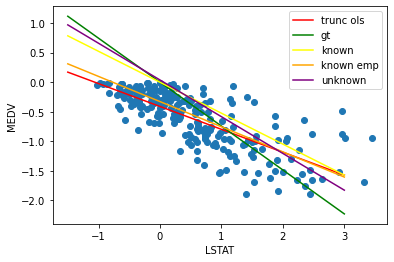

In [23]:
data_pt = Tensor(data)
ax = plt.subplot(1, 1, 1)
plt.scatter(x_trunc_stand, y_trunc_stand)
plt.plot(data_stand_pt, trunc_ols_pred, color='red', label='trunc ols')
plt.plot(data_stand_pt, ols_stand.predict(data_stand), color='green', label='gt')
plt.plot(data_stand_pt, known_results(data_stand_pt).detach().cpu(), label='known', color='yellow')
plt.plot(data_stand_pt, known_emp_results(data_stand_pt).detach().cpu(), label='known emp', color='orange')
plt.plot(data_stand_pt, unknown_results(data_stand_pt).detach().cpu(), label='unknown', color='purple')

ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.legend()
plt.plot()

In [12]:
# truncated linear regression with known noise variance using empirical noise variance
known_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=Tensor(gt_var))
known_results = known_trunc_reg.fit(x_trunc_pt, y_trunc_pt)
w_, w0_ = known_results.weight.detach().cpu(), known_results.bias.detach().cpu()

weight bounds:  (tensor([-24.3358]), tensor([23.3669]))
bias bounds:  (tensor([0.9351]), tensor([48.6378]))


  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[13.6004],
        [18.9827],
        [15.0586],
        [18.3190],
        [17.6650],
        [20.3586],
        [15.1555],
        [16.9335],
        [19.8111],
        [16.4151]], grad_fn=<SliceBackward>)
target:  tensor([[20.0000],
        [21.0000],
        [16.3000],
        [20.1000],
        [20.0000],
        [21.6000],
        [14.5000],
        [18.8000],
        [20.8000],
        [14.8000]])
weight grad:  tensor([[-282.1629]])
bias grad:  tensor([-18.0009])
output:  tensor([[361.4342],
        [720.1160],
        [228.7102],
        [368.9116],
        [554.6784],
        [557.9498],
        [643.9399],
        [379.4267],
        [519.1607],
        [426.6278]], grad_fn=<SliceBackward>)
target:  tensor([[16.8000],
        [ 8.1000],
        [16.5000],
        [17.7000],
        [12.7000],
        [ 8.4000],
        [15.6000],
        [17.5000],
        [10.9000],
        [13.1000]])
weight grad:  tensor([[-252.3138]])
bias grad:  tensor([-16.0800])
output

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[243.4817],
        [590.2463],
        [408.9193],
        [278.2983],
        [494.4421],
        [894.0160],
        [340.2206],
        [209.8333],
        [316.3864],
        [325.2658]], grad_fn=<SliceBackward>)
target:  tensor([[21.6000],
        [11.8000],
        [14.3000],
        [18.6000],
        [14.5000],
        [ 7.0000],
        [19.6000],
        [20.4000],
        [19.6000],
        [16.1000]])
weight grad:  tensor([[-250.6558]])
bias grad:  tensor([-16.8590])
output:  tensor([[648.9475],
        [455.2359],
        [376.4895],
        [382.5649],
        [410.1379],
        [332.3260],
        [369.0121],
        [679.0908],
        [594.7363],
        [247.0369]], grad_fn=<SliceBackward>)
target:  tensor([[15.6000],
        [19.1000],
        [20.1000],
        [16.7000],
        [19.4000],
        [19.6000],
        [16.0000],
        [13.2000],
        [13.3000],
        [19.6000]])
weight grad:  tensor([[-256.7429]])
bias grad:  tensor([-16.661

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[280.9383],
        [528.8611],
        [279.0689],
        [450.5820],
        [364.3581],
        [566.2481],
        [338.6545],
        [713.6932],
        [251.0287],
        [388.1924]], grad_fn=<SliceBackward>)
target:  tensor([[17.5000],
        [19.7000],
        [18.5000],
        [14.9000],
        [18.3000],
        [ 8.4000],
        [21.1000],
        [ 7.2000],
        [20.9000],
        [17.0000]])
weight grad:  tensor([[-262.7948]])
bias grad:  tensor([-16.3680])
output:  tensor([[599.6639],
        [529.0958],
        [653.4077],
        [340.2914],
        [436.3293],
        [653.8751],
        [377.4447],
        [241.9167],
        [447.7791],
        [228.8312]], grad_fn=<SliceBackward>)
target:  tensor([[13.3000],
        [10.9000],
        [17.2000],
        [21.7000],
        [15.1000],
        [15.6000],
        [17.1000],
        [20.9000],
        [17.8000],
        [22.0000]])
weight grad:  tensor([[-251.9228]])
bias grad:  tensor([-17.051

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[320.5215],
        [320.9889],
        [603.0273],
        [354.1699],
        [425.6726],
        [285.9385],
        [724.3015],
        [492.5019],
        [444.3661],
        [319.8205]], grad_fn=<SliceBackward>)
target:  tensor([[21.8000],
        [19.1000],
        [13.3000],
        [19.7000],
        [13.9000],
        [17.5000],
        [11.8000],
        [12.5000],
        [15.6000],
        [21.0000]])
weight grad:  tensor([[-259.6670]])
bias grad:  tensor([-16.8750])
output:  tensor([[282.0180],
        [681.3582],
        [246.5003],
        [644.2049],
        [340.4352],
        [328.0508],
        [510.7799],
        [601.6771],
        [641.6345],
        [425.7244]], grad_fn=<SliceBackward>)
target:  tensor([[20.2000],
        [ 8.5000],
        [21.0000],
        [ 7.5000],
        [22.2000],
        [19.6000],
        [16.3000],
        [ 7.0000],
        [ 9.7000],
        [12.6000]])
weight grad:  tensor([[-258.0500]])
bias grad:  tensor([-16.104

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[647.6203],
        [326.0918],
        [412.0820],
        [645.0499],
        [514.1953],
        [661.8741],
        [466.7605],
        [408.3433],
        [309.5013],
        [605.3262]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.5000],
        [16.1000],
        [21.7000],
        [ 9.7000],
        [16.3000],
        [17.2000],
        [ 9.6000],
        [19.4000],
        [22.3000],
        [11.8000]])
weight grad:  tensor([[-270.2360]])
bias grad:  tensor([-16.1580])
output:  tensor([[233.7727],
        [350.3735],
        [238.9134],
        [179.3278],
        [397.5746],
        [549.4594],
        [441.5044],
        [850.6587],
        [388.6952],
        [198.0213]], grad_fn=<SliceBackward>)
target:  tensor([[21.1000],
        [21.7000],
        [22.0000],
        [22.2000],
        [16.7000],
        [11.0000],
        [17.4000],
        [14.4000],
        [16.8000],
        [22.0000]])
weight grad:  tensor([[-248.6020]])
bias grad:  tensor([-17.238

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[469.9430],
        [329.7416],
        [448.4454],
        [427.6488],
        [472.2796],
        [523.2195],
        [608.7423],
        [513.1717],
        [429.5182],
        [292.1209]], grad_fn=<SliceBackward>)
target:  tensor([[14.6000],
        [16.1000],
        [15.1000],
        [14.3000],
        [14.1000],
        [12.1000],
        [ 7.0000],
        [14.5000],
        [15.6000],
        [21.8000]])
weight grad:  tensor([[-258.9346]])
bias grad:  tensor([-16.8650])
output:  tensor([[250.7615],
        [583.2724],
        [375.5407],
        [492.8425],
        [343.9954],
        [432.7896],
        [264.0806],
        [448.6791],
        [651.2701],
        [200.0553]], grad_fn=<SliceBackward>)
target:  tensor([[16.5000],
        [12.8000],
        [19.5000],
        [12.7000],
        [16.1000],
        [12.6000],
        [19.6000],
        [13.1000],
        [ 7.5000],
        [22.0000]])
weight grad:  tensor([[-257.8744]])
bias grad:  tensor([-16.451

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[912.7456],
        [489.1038],
        [343.0607],
        [843.5796],
        [349.3698],
        [851.7580],
        [247.4901],
        [674.1696],
        [485.8324],
        [355.9125]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.0000],
        [15.4000],
        [19.2000],
        [ 8.4000],
        [19.6000],
        [17.9000],
        [20.6000],
        [ 5.6000],
        [14.9000],
        [18.7000]])
weight grad:  tensor([[-263.3185]])
bias grad:  tensor([-17.3070])
output:  tensor([[391.4302],
        [233.2363],
        [322.4978],
        [383.4854],
        [530.4633],
        [312.2164],
        [390.9628],
        [253.5655],
        [748.9437],
        [386.0558]], grad_fn=<SliceBackward>)
target:  tensor([[17.5000],
        [21.6000],
        [19.4000],
        [16.8000],
        [ 8.8000],
        [18.2000],
        [17.7000],
        [21.0000],
        [ 6.3000],
        [16.0000]])
weight grad:  tensor([[-253.1109]])
bias grad:  tensor([-16.112

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[665.9912],
        [417.6011],
        [264.7816],
        [312.2164],
        [343.9954],
        [688.4234],
        [427.6488],
        [415.7318],
        [477.1867],
        [485.8324]], grad_fn=<SliceBackward>)
target:  tensor([[15.6000],
        [19.4000],
        [20.9000],
        [18.2000],
        [16.1000],
        [ 8.5000],
        [14.3000],
        [21.7000],
        [14.3000],
        [14.9000]])
weight grad:  tensor([[-253.6705]])
bias grad:  tensor([-16.1170])
output:  tensor([[469.9430],
        [250.7615],
        [352.4075],
        [200.0553],
        [295.8596],
        [279.5027],
        [262.2113],
        [230.6660],
        [285.8118],
        [247.4901]], grad_fn=<SliceBackward>)
target:  tensor([[14.6000],
        [16.5000],
        [21.7000],
        [22.0000],
        [21.2000],
        [21.7000],
        [21.6000],
        [18.6000],
        [20.5000],
        [20.6000]])
weight grad:  tensor([[-255.4462]])
bias grad:  tensor([-16.931

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[542.6140],
        [613.1820],
        [362.9225],
        [247.4901],
        [352.4075],
        [444.9403],
        [392.1312],
        [444.4731],
        [415.7318],
        [469.9430]], grad_fn=<SliceBackward>)
target:  tensor([[19.7000],
        [14.0000],
        [19.7000],
        [20.6000],
        [21.1000],
        [18.1000],
        [20.0000],
        [13.5000],
        [21.7000],
        [14.6000]])
weight grad:  tensor([[-268.8920]])
bias grad:  tensor([-16.2880])
output:  tensor([[328.5732],
        [295.8596],
        [600.0966],
        [432.7896],
        [206.3644],
        [285.8118],
        [489.1038],
        [271.7917],
        [486.0661],
        [360.3522]], grad_fn=<SliceBackward>)
target:  tensor([[21.0000],
        [21.2000],
        [11.3000],
        [12.6000],
        [20.7000],
        [20.5000],
        [15.4000],
        [21.2000],
        [15.2000],
        [20.6000]])
weight grad:  tensor([[-249.8801]])
bias grad:  tensor([-16.802

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[385.8221],
        [247.4901],
        [398.6739],
        [429.5182],
        [434.4253],
        [861.1048],
        [544.9507],
        [411.9930],
        [602.1996],
        [254.0329]], grad_fn=<SliceBackward>)
target:  tensor([[17.4000],
        [20.6000],
        [19.1000],
        [15.6000],
        [13.9000],
        [13.8000],
        [13.3000],
        [19.4000],
        [13.1000],
        [20.9000]])
weight grad:  tensor([[-254.6472]])
bias grad:  tensor([-16.3720])
output:  tensor([[427.6488],
        [228.5629],
        [665.9912],
        [279.5027],
        [355.9125],
        [377.8774],
        [448.4454],
        [375.7744],
        [367.5959],
        [206.3644]], grad_fn=<SliceBackward>)
target:  tensor([[14.3000],
        [20.4000],
        [15.6000],
        [21.7000],
        [18.7000],
        [20.4000],
        [15.1000],
        [21.9000],
        [20.7000],
        [20.7000]])
weight grad:  tensor([[-259.1769]])
bias grad:  tensor([-17.340

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[343.0607],
        [698.2375],
        [472.5133],
        [236.7413],
        [378.1111],
        [665.5239],
        [358.7165],
        [297.0279],
        [335.1160],
        [452.1841]], grad_fn=<SliceBackward>)
target:  tensor([[19.2000],
        [13.8000],
        [13.8000],
        [18.2000],
        [20.8000],
        [17.2000],
        [18.9000],
        [18.6000],
        [19.6000],
        [16.1000]])
weight grad:  tensor([[-258.2623]])
bias grad:  tensor([-17.2450])
output:  tensor([[600.0966],
        [551.4934],
        [172.2487],
        [344.6964],
        [360.5859],
        [611.7800],
        [292.8219],
        [709.4536],
        [499.8526],
        [358.9502]], grad_fn=<SliceBackward>)
target:  tensor([[11.3000],
        [11.0000],
        [21.9000],
        [17.2000],
        [20.1000],
        [13.3000],
        [18.5000],
        [10.5000],
        [13.0000],
        [19.6000]])
weight grad:  tensor([[-255.6182]])
bias grad:  tensor([-16.094

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[253.5655],
        [329.7416],
        [469.9430],
        [651.2701],
        [843.5796],
        [557.5688],
        [508.7320],
        [448.6791],
        [539.8100],
        [392.1312]], grad_fn=<SliceBackward>)
target:  tensor([[21.0000],
        [16.1000],
        [14.6000],
        [ 7.5000],
        [ 8.4000],
        [10.2000],
        [14.1000],
        [13.1000],
        [13.6000],
        [20.0000]])
weight grad:  tensor([[-258.0469]])
bias grad:  tensor([-17.1150])
output:  tensor([[709.4536],
        [592.3855],
        [510.6013],
        [347.5004],
        [335.3496],
        [472.2796],
        [277.6334],
        [415.4981],
        [485.1314],
        [228.5629]], grad_fn=<SliceBackward>)
target:  tensor([[10.5000],
        [13.4000],
        [ 8.3000],
        [22.2000],
        [19.8000],
        [14.1000],
        [19.5000],
        [14.2000],
        [16.7000],
        [20.4000]])
weight grad:  tensor([[-251.1204]])
bias grad:  tensor([-16.217

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[398.6739],
        [360.3522],
        [479.9907],
        [546.8201],
        [380.2141],
        [399.6086],
        [287.9148],
        [542.6140],
        [322.4978],
        [181.3618]], grad_fn=<SliceBackward>)
target:  tensor([[19.1000],
        [20.6000],
        [17.8000],
        [19.1000],
        [19.9000],
        [16.7000],
        [19.4000],
        [19.7000],
        [19.4000],
        [22.2000]])
weight grad:  tensor([[-260.7676]])
bias grad:  tensor([-17.0930])
output:  tensor([[276.2314],
        [240.2464],
        [335.3496],
        [358.9502],
        [253.5655],
        [247.4901],
        [362.9225],
        [254.0329],
        [262.2113],
        [354.5105]], grad_fn=<SliceBackward>)
target:  tensor([[19.0000],
        [22.0000],
        [19.8000],
        [19.6000],
        [21.0000],
        [20.6000],
        [19.7000],
        [20.9000],
        [21.6000],
        [17.4000]])
weight grad:  tensor([[-260.3116]])
bias grad:  tensor([-16.688

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[384.4201],
        [321.7968],
        [648.6997],
        [523.2195],
        [253.5655],
        [444.4731],
        [472.5133],
        [297.0279],
        [551.4934],
        [470.8776]], grad_fn=<SliceBackward>)
target:  tensor([[22.0000],
        [20.2000],
        [ 9.7000],
        [12.1000],
        [21.0000],
        [13.5000],
        [13.8000],
        [18.6000],
        [11.0000],
        [13.6000]])
weight grad:  tensor([[-264.1333]])
bias grad:  tensor([-16.8400])
output:  tensor([[246.5555],
        [557.5688],
        [328.5732],
        [450.7821],
        [276.2314],
        [382.0834],
        [464.3349],
        [608.9760],
        [240.2464],
        [470.6440]], grad_fn=<SliceBackward>)
target:  tensor([[19.9000],
        [10.2000],
        [21.0000],
        [10.4000],
        [19.0000],
        [20.3000],
        [14.9000],
        [11.8000],
        [22.0000],
        [15.2000]])
weight grad:  tensor([[-245.4946]])
bias grad:  tensor([-16.854

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[523.9205],
        [391.4302],
        [265.7163],
        [253.5655],
        [489.1038],
        [611.7800],
        [355.9125],
        [427.6488],
        [459.8952],
        [250.7615]], grad_fn=<SliceBackward>)
target:  tensor([[13.5000],
        [17.5000],
        [18.7000],
        [21.0000],
        [15.4000],
        [13.3000],
        [18.7000],
        [14.3000],
        [17.8000],
        [16.5000]])
weight grad:  tensor([[-258.8062]])
bias grad:  tensor([-16.8550])
output:  tensor([[472.5133],
        [470.6440],
        [674.1696],
        [313.1511],
        [470.8776],
        [316.1888],
        [390.9628],
        [296.0933],
        [399.6086],
        [328.3396]], grad_fn=<SliceBackward>)
target:  tensor([[13.8000],
        [15.2000],
        [ 5.6000],
        [22.3000],
        [13.6000],
        [20.6000],
        [17.7000],
        [20.6000],
        [16.7000],
        [20.0000]])
weight grad:  tensor([[-255.8178]])
bias grad:  tensor([-16.502

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[233.2363],
        [542.6140],
        [322.4978],
        [297.0279],
        [517.8451],
        [768.5718],
        [648.6997],
        [383.4854],
        [470.4103],
        [450.7821]], grad_fn=<SliceBackward>)
target:  tensor([[21.6000],
        [19.7000],
        [19.4000],
        [18.6000],
        [16.3000],
        [ 7.2000],
        [ 9.7000],
        [16.8000],
        [ 9.6000],
        [10.4000]])
weight grad:  tensor([[-249.2084]])
bias grad:  tensor([-16.5690])
output:  tensor([[611.7800],
        [499.8526],
        [444.9403],
        [539.8100],
        [851.7580],
        [727.4461],
        [394.7015],
        [544.4833],
        [271.7917],
        [317.3571]], grad_fn=<SliceBackward>)
target:  tensor([[13.3000],
        [13.0000],
        [18.1000],
        [13.6000],
        [17.9000],
        [ 7.2000],
        [21.4000],
        [17.2000],
        [21.2000],
        [16.2000]])
weight grad:  tensor([[-261.2479]])
bias grad:  tensor([-16.831

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[233.2363],
        [851.7580],
        [472.2796],
        [479.9907],
        [748.9437],
        [544.9507],
        [257.5379],
        [264.0806],
        [247.4901],
        [613.1820]], grad_fn=<SliceBackward>)
target:  tensor([[21.6000],
        [17.9000],
        [14.1000],
        [17.8000],
        [ 6.3000],
        [13.3000],
        [21.4000],
        [19.6000],
        [20.6000],
        [14.0000]])
weight grad:  tensor([[-258.4643]])
bias grad:  tensor([-16.6470])
output:  tensor([[551.4934],
        [340.7240],
        [287.9148],
        [742.1673],
        [499.8526],
        [284.8771],
        [912.7456],
        [313.1511],
        [489.1038],
        [329.7416]], grad_fn=<SliceBackward>)
target:  tensor([[11.0000],
        [17.6000],
        [19.4000],
        [ 8.1000],
        [13.0000],
        [15.0000],
        [ 7.0000],
        [22.3000],
        [15.4000],
        [19.1000]])
weight grad:  tensor([[-256.8665]])
bias grad:  tensor([-16.758

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[257.5379],
        [391.4302],
        [464.3349],
        [375.7744],
        [350.5381],
        [316.1888],
        [450.7821],
        [742.1673],
        [433.4906],
        [513.1717]], grad_fn=<SliceBackward>)
target:  tensor([[21.4000],
        [17.5000],
        [14.9000],
        [21.9000],
        [21.2000],
        [20.6000],
        [10.4000],
        [ 8.1000],
        [19.5000],
        [14.5000]])
weight grad:  tensor([[-262.8469]])
bias grad:  tensor([-16.8000])
output:  tensor([[347.5004],
        [630.7072],
        [472.2796],
        [671.1319],
        [382.0834],
        [479.9907],
        [313.1511],
        [398.6739],
        [378.1111],
        [343.9954]], grad_fn=<SliceBackward>)
target:  tensor([[22.2000],
        [12.0000],
        [14.1000],
        [10.4000],
        [20.3000],
        [17.8000],
        [22.3000],
        [19.1000],
        [18.3000],
        [16.1000]])
weight grad:  tensor([[-251.3751]])
bias grad:  tensor([-16.742

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[477.4203],
        [768.5718],
        [394.7015],
        [343.0607],
        [651.2701],
        [264.7816],
        [313.6184],
        [233.2363],
        [328.3396],
        [281.6058]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [14.4000],
        [21.4000],
        [19.2000],
        [ 7.5000],
        [20.9000],
        [21.4000],
        [21.6000],
        [20.0000],
        [19.3000]])
weight grad:  tensor([[-251.7992]])
bias grad:  tensor([-17.1170])
output:  tensor([[592.3855],
        [235.8067],
        [492.8425],
        [427.4152],
        [608.9760],
        [322.9652],
        [576.7297],
        [861.1048],
        [296.0933],
        [246.5555]], grad_fn=<SliceBackward>)
target:  tensor([[13.4000],
        [21.1000],
        [12.7000],
        [18.8000],
        [11.8000],
        [18.5000],
        [12.7000],
        [13.8000],
        [20.6000],
        [19.9000]])
weight grad:  tensor([[-261.6713]])
bias grad:  tensor([-16.210

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[343.0607],
        [246.5555],
        [447.9781],
        [236.7413],
        [544.9507],
        [385.8221],
        [698.2375],
        [265.7163],
        [530.4633],
        [470.8776]], grad_fn=<SliceBackward>)
target:  tensor([[19.2000],
        [19.9000],
        [18.7000],
        [18.2000],
        [13.3000],
        [17.4000],
        [13.8000],
        [18.7000],
        [ 8.8000],
        [13.6000]])
weight grad:  tensor([[-250.1101]])
bias grad:  tensor([-16.9050])
output:  tensor([[328.5732],
        [350.5381],
        [585.6091],
        [367.5959],
        [335.1160],
        [851.7580],
        [415.4981],
        [550.0914],
        [852.6927],
        [665.9912]], grad_fn=<SliceBackward>)
target:  tensor([[21.0000],
        [21.2000],
        [ 5.0000],
        [20.7000],
        [19.6000],
        [17.9000],
        [14.2000],
        [21.7000],
        [14.4000],
        [15.6000]])
weight grad:  tensor([[-263.5908]])
bias grad:  tensor([-16.371

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[602.1996],
        [479.9907],
        [246.5555],
        [295.3922],
        [394.4679],
        [671.1319],
        [287.2138],
        [401.9453],
        [557.5688],
        [352.4075]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [17.8000],
        [19.9000],
        [18.5000],
        [18.9000],
        [10.4000],
        [19.3000],
        [17.0000],
        [10.2000],
        [21.7000]])
weight grad:  tensor([[-250.1373]])
bias grad:  tensor([-17.0780])
output:  tensor([[447.9781],
        [472.2796],
        [254.0329],
        [264.0806],
        [289.0832],
        [535.8376],
        [343.9954],
        [285.8118],
        [339.0883],
        [371.8020]], grad_fn=<SliceBackward>)
target:  tensor([[18.7000],
        [14.1000],
        [20.9000],
        [19.6000],
        [20.2000],
        [11.5000],
        [16.1000],
        [20.5000],
        [17.1000],
        [19.6000]])
weight grad:  tensor([[-261.3067]])
bias grad:  tensor([-16.700

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[421.1061],
        [377.8774],
        [240.2464],
        [608.9760],
        [289.0832],
        [336.7516],
        [237.9097],
        [247.4901],
        [181.3618],
        [492.8425]], grad_fn=<SliceBackward>)
target:  tensor([[19.8000],
        [20.4000],
        [22.0000],
        [19.3000],
        [20.2000],
        [20.1000],
        [22.0000],
        [20.6000],
        [22.2000],
        [12.7000]])
weight grad:  tensor([[-260.0799]])
bias grad:  tensor([-16.9640])
output:  tensor([[523.2195],
        [335.3496],
        [285.8118],
        [733.0542],
        [246.5555],
        [287.9148],
        [362.9225],
        [432.7896],
        [459.4279],
        [861.1048]], grad_fn=<SliceBackward>)
target:  tensor([[12.1000],
        [19.8000],
        [20.5000],
        [11.8000],
        [19.9000],
        [19.4000],
        [19.7000],
        [12.6000],
        [18.8000],
        [13.8000]])
weight grad:  tensor([[-256.2021]])
bias grad:  tensor([-16.814

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[329.7416],
        [360.3522],
        [228.5629],
        [317.3571],
        [335.1160],
        [674.1696],
        [427.1815],
        [292.1209],
        [383.4854],
        [296.0933]], grad_fn=<SliceBackward>)
target:  tensor([[19.1000],
        [20.6000],
        [20.4000],
        [16.2000],
        [19.6000],
        [ 5.6000],
        [19.4000],
        [21.8000],
        [16.8000],
        [20.6000]])
weight grad:  tensor([[-249.2069]])
bias grad:  tensor([-16.7790])
output:  tensor([[375.5407],
        [912.7456],
        [427.4152],
        [477.1867],
        [352.4075],
        [542.6140],
        [312.2164],
        [411.9930],
        [613.1820],
        [277.6334]], grad_fn=<SliceBackward>)
target:  tensor([[19.5000],
        [ 7.0000],
        [18.8000],
        [14.3000],
        [21.1000],
        [19.7000],
        [18.2000],
        [19.4000],
        [14.0000],
        [19.5000]])
weight grad:  tensor([[-262.3298]])
bias grad:  tensor([-16.705

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[444.4731],
        [508.7320],
        [236.7413],
        [264.0806],
        [352.4075],
        [742.1673],
        [472.2796],
        [322.9652],
        [271.7917],
        [294.6912]], grad_fn=<SliceBackward>)
target:  tensor([[13.5000],
        [14.1000],
        [18.2000],
        [19.6000],
        [21.1000],
        [ 8.1000],
        [14.1000],
        [18.5000],
        [21.2000],
        [17.5000]])
weight grad:  tensor([[-238.5244]])
bias grad:  tensor([-17.0410])
output:  tensor([[391.4302],
        [287.9148],
        [386.0558],
        [367.5959],
        [489.1038],
        [328.3396],
        [398.6739],
        [674.1696],
        [696.1345],
        [254.0329]], grad_fn=<SliceBackward>)
target:  tensor([[17.5000],
        [19.4000],
        [16.0000],
        [20.7000],
        [15.4000],
        [20.0000],
        [19.1000],
        [ 5.6000],
        [13.2000],
        [20.9000]])
weight grad:  tensor([[-273.0369]])
bias grad:  tensor([-16.718

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[297.0279],
        [665.9912],
        [444.9403],
        [354.5105],
        [651.2701],
        [284.8771],
        [768.5718],
        [335.1160],
        [389.5608],
        [385.8221]], grad_fn=<SliceBackward>)
target:  tensor([[18.6000],
        [15.6000],
        [18.1000],
        [17.4000],
        [ 7.5000],
        [15.0000],
        [ 7.2000],
        [19.6000],
        [17.1000],
        [17.4000]])
weight grad:  tensor([[-256.1134]])
bias grad:  tensor([-16.4610])
output:  tensor([[250.7615],
        [246.5555],
        [394.7015],
        [523.2195],
        [469.9430],
        [485.8324],
        [188.3719],
        [200.0553],
        [477.1867],
        [514.1064]], grad_fn=<SliceBackward>)
target:  tensor([[16.5000],
        [19.9000],
        [21.4000],
        [12.1000],
        [14.6000],
        [14.9000],
        [22.1000],
        [22.0000],
        [14.3000],
        [ 8.5000]])
weight grad:  tensor([[-249.1164]])
bias grad:  tensor([-16.776

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[394.4679],
        [472.2796],
        [343.0607],
        [651.2701],
        [470.6440],
        [709.4536],
        [748.0090],
        [459.8952],
        [181.3618],
        [281.6058]], grad_fn=<SliceBackward>)
target:  tensor([[18.9000],
        [14.1000],
        [19.2000],
        [ 7.5000],
        [15.2000],
        [10.5000],
        [16.5000],
        [17.8000],
        [22.2000],
        [19.3000]])
weight grad:  tensor([[-255.1719]])
bias grad:  tensor([-16.8730])
output:  tensor([[354.5105],
        [608.7423],
        [486.0661],
        [764.3658],
        [415.7318],
        [281.6058],
        [312.2164],
        [403.1136],
        [287.9148],
        [444.9403]], grad_fn=<SliceBackward>)
target:  tensor([[17.4000],
        [ 7.0000],
        [15.2000],
        [ 8.8000],
        [21.7000],
        [20.3000],
        [18.2000],
        [11.7000],
        [19.4000],
        [18.1000]])
weight grad:  tensor([[-261.4198]])
bias grad:  tensor([-16.931

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[296.0933],
        [530.4633],
        [292.8219],
        [550.0914],
        [665.9912],
        [912.7456],
        [384.4201],
        [393.5332],
        [472.2796],
        [329.2742]], grad_fn=<SliceBackward>)
target:  tensor([[20.6000],
        [ 8.8000],
        [18.5000],
        [21.7000],
        [15.6000],
        [ 7.0000],
        [22.0000],
        [20.1000],
        [14.1000],
        [21.8000]])
weight grad:  tensor([[-260.3553]])
bias grad:  tensor([-16.4310])
output:  tensor([[297.0279],
        [675.3380],
        [535.8376],
        [459.8952],
        [240.2464],
        [727.4461],
        [295.8596],
        [394.7015],
        [188.3719],
        [604.5363]], grad_fn=<SliceBackward>)
target:  tensor([[18.6000],
        [13.4000],
        [11.5000],
        [17.8000],
        [22.0000],
        [ 7.2000],
        [21.2000],
        [16.6000],
        [22.1000],
        [10.8000]])
weight grad:  tensor([[-254.2192]])
bias grad:  tensor([-17.140

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[611.7800],
        [470.6440],
        [343.0607],
        [550.0914],
        [246.5555],
        [651.2701],
        [450.3148],
        [347.7341],
        [576.7297],
        [265.7163]], grad_fn=<SliceBackward>)
target:  tensor([[13.3000],
        [15.2000],
        [19.2000],
        [21.7000],
        [19.9000],
        [ 7.5000],
        [16.2000],
        [18.4000],
        [12.7000],
        [18.7000]])
weight grad:  tensor([[-251.7423]])
bias grad:  tensor([-16.5440])
output:  tensor([[399.6086],
        [392.1312],
        [287.2138],
        [541.2120],
        [284.8771],
        [417.6011],
        [313.1511],
        [380.2141],
        [352.4075],
        [448.4454]], grad_fn=<SliceBackward>)
target:  tensor([[16.7000],
        [20.0000],
        [19.3000],
        [10.9000],
        [15.0000],
        [19.4000],
        [22.3000],
        [19.9000],
        [21.1000],
        [15.1000]])
weight grad:  tensor([[-265.7179]])
bias grad:  tensor([-16.981

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[447.9781],
        [328.5732],
        [403.1136],
        [377.8774],
        [295.8596],
        [246.5555],
        [618.5564],
        [200.0553],
        [648.6997],
        [316.1888]], grad_fn=<SliceBackward>)
target:  tensor([[18.7000],
        [21.0000],
        [11.7000],
        [20.4000],
        [21.2000],
        [19.9000],
        [ 8.3000],
        [22.0000],
        [ 9.7000],
        [20.6000]])
weight grad:  tensor([[-263.9477]])
bias grad:  tensor([-16.9040])
output:  tensor([[535.8376],
        [250.7615],
        [287.2138],
        [611.7800],
        [253.5655],
        [671.1319],
        [172.2487],
        [205.8970],
        [852.6927],
        [257.5379]], grad_fn=<SliceBackward>)
target:  tensor([[11.5000],
        [16.5000],
        [19.3000],
        [13.3000],
        [21.0000],
        [10.4000],
        [21.9000],
        [22.2000],
        [14.4000],
        [21.4000]])
weight grad:  tensor([[-254.6461]])
bias grad:  tensor([-16.279

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[546.8201],
        [588.1794],
        [450.7821],
        [432.7896],
        [408.2544],
        [206.3644],
        [472.2796],
        [352.4075],
        [362.9225],
        [666.6922]], grad_fn=<SliceBackward>)
target:  tensor([[19.1000],
        [20.0000],
        [10.4000],
        [12.6000],
        [18.0000],
        [20.7000],
        [14.1000],
        [21.7000],
        [19.7000],
        [ 8.7000]])
weight grad:  tensor([[-263.0778]])
bias grad:  tensor([-16.8390])
output:  tensor([[277.6334],
        [576.7297],
        [279.5027],
        [549.8578],
        [541.2120],
        [200.0553],
        [464.3349],
        [394.7015],
        [336.9853],
        [510.6013]], grad_fn=<SliceBackward>)
target:  tensor([[19.5000],
        [12.7000],
        [21.7000],
        [15.4000],
        [10.9000],
        [22.0000],
        [14.9000],
        [16.6000],
        [21.2000],
        [ 8.3000]])
weight grad:  tensor([[-252.2937]])
bias grad:  tensor([-16.652

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[377.8774],
        [427.6488],
        [453.1188],
        [417.6011],
        [394.7015],
        [392.1312],
        [347.7341],
        [390.7292],
        [328.5732],
        [264.0806]], grad_fn=<SliceBackward>)
target:  tensor([[20.4000],
        [14.3000],
        [15.6000],
        [19.4000],
        [16.6000],
        [20.0000],
        [18.4000],
        [16.8000],
        [21.0000],
        [19.6000]])
weight grad:  tensor([[-262.5776]])
bias grad:  tensor([-16.9050])
output:  tensor([[321.7968],
        [257.5379],
        [477.1867],
        [425.7795],
        [383.4854],
        [247.4901],
        [602.1996],
        [688.4234],
        [313.6184],
        [401.4779]], grad_fn=<SliceBackward>)
target:  tensor([[20.2000],
        [21.4000],
        [14.3000],
        [13.1000],
        [16.8000],
        [20.6000],
        [13.1000],
        [ 8.5000],
        [21.4000],
        [17.5000]])
weight grad:  tensor([[-249.3119]])
bias grad:  tensor([-16.337

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[453.1188],
        [295.8596],
        [284.8771],
        [514.1064],
        [517.8451],
        [386.0558],
        [727.4461],
        [588.1794],
        [254.0329],
        [380.2141]], grad_fn=<SliceBackward>)
target:  tensor([[15.6000],
        [21.2000],
        [15.0000],
        [ 8.5000],
        [16.3000],
        [16.0000],
        [ 7.2000],
        [20.0000],
        [20.9000],
        [19.9000]])
weight grad:  tensor([[-261.4908]])
bias grad:  tensor([-16.4460])
output:  tensor([[698.2375],
        [608.9760],
        [375.5407],
        [408.2544],
        [459.4279],
        [415.7318],
        [181.3618],
        [459.8952],
        [265.7163],
        [355.9125]], grad_fn=<SliceBackward>)
target:  tensor([[13.8000],
        [19.3000],
        [19.5000],
        [18.0000],
        [18.8000],
        [21.7000],
        [22.2000],
        [17.8000],
        [18.7000],
        [18.7000]])
weight grad:  tensor([[-255.5167]])
bias grad:  tensor([-17.061

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[748.0090],
        [292.8219],
        [604.5363],
        [768.5718],
        [343.9954],
        [479.9907],
        [281.6058],
        [472.2796],
        [541.2120],
        [188.3719]], grad_fn=<SliceBackward>)
target:  tensor([[16.5000],
        [18.5000],
        [10.8000],
        [14.4000],
        [16.1000],
        [17.8000],
        [19.3000],
        [19.1000],
        [10.9000],
        [22.1000]])
weight grad:  tensor([[-263.4491]])
bias grad:  tensor([-17.2280])
output:  tensor([[394.7015],
        [391.4302],
        [630.7072],
        [321.7968],
        [477.4203],
        [355.9125],
        [485.1314],
        [250.7615],
        [557.5688],
        [535.8376]], grad_fn=<SliceBackward>)
target:  tensor([[16.6000],
        [17.5000],
        [12.0000],
        [20.2000],
        [13.1000],
        [18.7000],
        [16.7000],
        [16.5000],
        [10.2000],
        [11.5000]])
weight grad:  tensor([[-257.8553]])
bias grad:  tensor([-16.401

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[240.9474],
        [382.0834],
        [499.8526],
        [544.4833],
        [295.3922],
        [335.1160],
        [459.4279],
        [328.5732],
        [444.4731],
        [287.9148]], grad_fn=<SliceBackward>)
target:  tensor([[22.0000],
        [20.3000],
        [13.0000],
        [17.2000],
        [18.5000],
        [19.6000],
        [18.8000],
        [21.0000],
        [13.5000],
        [19.4000]])
weight grad:  tensor([[-253.2856]])
bias grad:  tensor([-17.3110])
output:  tensor([[696.1345],
        [322.4978],
        [336.9853],
        [285.8118],
        [541.2120],
        [472.2796],
        [393.5332],
        [289.0832],
        [432.7896],
        [651.2701]], grad_fn=<SliceBackward>)
target:  tensor([[13.2000],
        [19.4000],
        [21.2000],
        [20.5000],
        [10.9000],
        [14.1000],
        [20.1000],
        [20.2000],
        [12.6000],
        [ 7.5000]])
weight grad:  tensor([[-257.9308]])
bias grad:  tensor([-16.326

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[618.5564],
        [698.2375],
        [296.0933],
        [391.4302],
        [611.7800],
        [329.2742],
        [328.3396],
        [265.7163],
        [401.9453],
        [264.7816]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.3000],
        [13.8000],
        [20.6000],
        [17.5000],
        [13.3000],
        [21.8000],
        [20.0000],
        [18.7000],
        [17.0000],
        [20.9000]])
weight grad:  tensor([[-271.1654]])
bias grad:  tensor([-17.2550])
output:  tensor([[470.6440],
        [253.5655],
        [276.2314],
        [329.7416],
        [360.3522],
        [392.1312],
        [535.8376],
        [230.6660],
        [354.5105],
        [530.4633]], grad_fn=<SliceBackward>)
target:  tensor([[15.2000],
        [21.0000],
        [19.0000],
        [19.1000],
        [20.6000],
        [20.0000],
        [11.5000],
        [18.6000],
        [17.4000],
        [ 8.8000]])
weight grad:  tensor([[-246.3351]])
bias grad:  tensor([-15.911

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[260.8092],
        [228.5629],
        [360.5859],
        [399.6086],
        [394.4679],
        [355.9125],
        [602.1996],
        [292.1209],
        [501.2546],
        [262.2113]], grad_fn=<SliceBackward>)
target:  tensor([[20.6000],
        [20.4000],
        [20.1000],
        [16.7000],
        [18.9000],
        [18.7000],
        [13.1000],
        [21.8000],
        [12.5000],
        [21.6000]])
weight grad:  tensor([[-256.3269]])
bias grad:  tensor([-16.7690])
output:  tensor([[271.7917],
        [671.1319],
        [709.4536],
        [401.4779],
        [550.0914],
        [768.5718],
        [241.6484],
        [666.6922],
        [264.7816],
        [367.5959]], grad_fn=<SliceBackward>)
target:  tensor([[21.2000],
        [10.4000],
        [10.5000],
        [17.5000],
        [21.7000],
        [ 7.2000],
        [20.4000],
        [ 8.7000],
        [20.9000],
        [20.7000]])
weight grad:  tensor([[-256.4238]])
bias grad:  tensor([-16.466

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[433.4906],
        [470.8776],
        [665.9912],
        [289.0832],
        [499.8526],
        [390.9628],
        [467.6063],
        [444.4731],
        [380.2141],
        [316.1888]], grad_fn=<SliceBackward>)
target:  tensor([[19.5000],
        [13.6000],
        [15.6000],
        [20.2000],
        [13.0000],
        [17.7000],
        [20.5000],
        [13.5000],
        [19.9000],
        [20.6000]])
weight grad:  tensor([[-257.7698]])
bias grad:  tensor([-16.5990])
output:  tensor([[583.2724],
        [535.8376],
        [727.4461],
        [748.9437],
        [352.4075],
        [517.8451],
        [347.7341],
        [796.1448],
        [329.7416],
        [172.2487]], grad_fn=<SliceBackward>)
target:  tensor([[12.8000],
        [11.5000],
        [ 7.2000],
        [ 6.3000],
        [21.7000],
        [16.3000],
        [18.4000],
        [ 7.4000],
        [16.1000],
        [21.9000]])
weight grad:  tensor([[-255.5903]])
bias grad:  tensor([-16.753

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[336.9853],
        [265.7163],
        [852.6927],
        [200.0553],
        [313.1511],
        [580.0010],
        [477.4203],
        [250.7615],
        [317.3571],
        [452.1841]], grad_fn=<SliceBackward>)
target:  tensor([[21.2000],
        [18.7000],
        [14.4000],
        [22.0000],
        [22.3000],
        [ 8.4000],
        [13.1000],
        [16.5000],
        [16.2000],
        [16.1000]])
weight grad:  tensor([[-265.2133]])
bias grad:  tensor([-16.4100])
output:  tensor([[486.0661],
        [378.1111],
        [912.7456],
        [399.6086],
        [253.5655],
        [392.1312],
        [287.9148],
        [484.6641],
        [230.6660],
        [310.8144]], grad_fn=<SliceBackward>)
target:  tensor([[15.2000],
        [20.8000],
        [ 7.0000],
        [16.7000],
        [21.0000],
        [20.0000],
        [19.4000],
        [19.5000],
        [18.6000],
        [22.2000]])
weight grad:  tensor([[-253.6407]])
bias grad:  tensor([-17.149

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[452.1841],
        [542.6140],
        [444.9403],
        [600.0966],
        [470.4103],
        [535.8376],
        [344.6964],
        [450.3148],
        [608.9760],
        [329.7416]], grad_fn=<SliceBackward>)
target:  tensor([[16.1000],
        [19.7000],
        [18.1000],
        [11.3000],
        [ 9.6000],
        [11.5000],
        [17.2000],
        [16.2000],
        [11.8000],
        [19.1000]])
weight grad:  tensor([[-249.7487]])
bias grad:  tensor([-15.9370])
output:  tensor([[434.4253],
        [287.2138],
        [354.5105],
        [588.1794],
        [284.8771],
        [485.1314],
        [382.0834],
        [281.6058],
        [580.0010],
        [398.6739]], grad_fn=<SliceBackward>)
target:  tensor([[13.9000],
        [19.3000],
        [17.4000],
        [20.0000],
        [15.0000],
        [16.7000],
        [20.3000],
        [19.3000],
        [ 8.4000],
        [19.1000]])
weight grad:  tensor([[-257.4470]])
bias grad:  tensor([-16.951

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[604.5363],
        [742.1673],
        [549.8578],
        [523.9205],
        [523.2195],
        [292.1209],
        [425.7795],
        [796.1448],
        [470.8776],
        [539.8100]], grad_fn=<SliceBackward>)
target:  tensor([[10.8000],
        [ 8.1000],
        [15.4000],
        [13.5000],
        [12.1000],
        [21.8000],
        [13.1000],
        [ 7.4000],
        [13.6000],
        [13.6000]])
weight grad:  tensor([[-260.3631]])
bias grad:  tensor([-16.3410])
output:  tensor([[328.5732],
        [467.3726],
        [665.5239],
        [247.4901],
        [508.7320],
        [399.6086],
        [748.0090],
        [608.9760],
        [339.0883],
        [576.7297]], grad_fn=<SliceBackward>)
target:  tensor([[21.0000],
        [21.5000],
        [17.2000],
        [20.6000],
        [14.1000],
        [16.7000],
        [16.5000],
        [11.8000],
        [17.1000],
        [12.7000]])
weight grad:  tensor([[-256.6165]])
bias grad:  tensor([-17.064

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[742.1673],
        [378.1111],
        [271.7917],
        [281.6058],
        [429.2846],
        [583.2724],
        [546.8201],
        [246.5555],
        [354.5105],
        [188.3719]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.1000],
        [20.8000],
        [21.2000],
        [20.3000],
        [19.9000],
        [12.8000],
        [19.1000],
        [19.9000],
        [17.4000],
        [22.1000]])
weight grad:  tensor([[-252.7330]])
bias grad:  tensor([-16.9650])
output:  tensor([[403.1136],
        [648.6997],
        [550.0914],
        [279.5027],
        [358.7165],
        [485.1314],
        [526.4908],
        [277.6334],
        [492.8425],
        [585.6091]], grad_fn=<SliceBackward>)
target:  tensor([[11.7000],
        [ 9.7000],
        [21.7000],
        [21.7000],
        [21.7000],
        [16.7000],
        [15.0000],
        [19.5000],
        [12.7000],
        [ 5.0000]])
weight grad:  tensor([[-258.7087]])
bias grad:  tensor([-16.218

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[271.7917],
        [236.7413],
        [526.4908],
        [429.2846],
        [551.4934],
        [523.9205],
        [485.1314],
        [768.5718],
        [276.2314],
        [501.2546]], grad_fn=<SliceBackward>)
target:  tensor([[21.2000],
        [18.2000],
        [15.0000],
        [19.9000],
        [11.0000],
        [13.5000],
        [16.7000],
        [14.4000],
        [19.0000],
        [12.5000]])
weight grad:  tensor([[-254.3475]])
bias grad:  tensor([-16.7030])
output:  tensor([[250.7615],
        [287.2138],
        [486.0661],
        [675.3380],
        [448.6791],
        [240.2464],
        [394.4679],
        [508.7320],
        [510.6013],
        [343.9954]], grad_fn=<SliceBackward>)
target:  tensor([[16.5000],
        [19.3000],
        [15.2000],
        [13.4000],
        [13.1000],
        [22.0000],
        [18.9000],
        [14.1000],
        [ 8.3000],
        [16.1000]])
weight grad:  tensor([[-264.3771]])
bias grad:  tensor([-16.548

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[486.0661],
        [358.7165],
        [228.5629],
        [392.1312],
        [188.3719],
        [665.5239],
        [489.1038],
        [551.4934],
        [287.2138],
        [470.6440]], grad_fn=<SliceBackward>)
target:  tensor([[15.2000],
        [18.9000],
        [20.4000],
        [20.0000],
        [22.1000],
        [17.2000],
        [15.4000],
        [11.0000],
        [19.3000],
        [15.2000]])
weight grad:  tensor([[-252.0261]])
bias grad:  tensor([-16.3100])
output:  tensor([[172.2487],
        [313.1511],
        [253.5655],
        [513.1717],
        [434.4253],
        [449.6137],
        [608.7423],
        [508.7320],
        [206.3644],
        [452.1841]], grad_fn=<SliceBackward>)
target:  tensor([[21.9000],
        [22.3000],
        [21.0000],
        [14.5000],
        [13.9000],
        [11.7000],
        [ 7.0000],
        [14.1000],
        [20.7000],
        [16.1000]])
weight grad:  tensor([[-261.4698]])
bias grad:  tensor([-17.131

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[742.1673],
        [415.7318],
        [674.1696],
        [188.3719],
        [557.5688],
        [328.3396],
        [630.7072],
        [380.2141],
        [535.8376],
        [329.7416]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.1000],
        [21.7000],
        [ 5.6000],
        [22.1000],
        [10.2000],
        [20.0000],
        [12.0000],
        [19.9000],
        [11.5000],
        [19.1000]])
weight grad:  tensor([[-251.0289]])
bias grad:  tensor([-17.1160])
output:  tensor([[452.4178],
        [935.8788],
        [675.3380],
        [671.1319],
        [861.1048],
        [294.6912],
        [665.5239],
        [459.4279],
        [851.7580],
        [329.7416]], grad_fn=<SliceBackward>)
target:  tensor([[14.8000],
        [13.8000],
        [13.4000],
        [10.4000],
        [13.8000],
        [17.5000],
        [17.2000],
        [18.8000],
        [17.9000],
        [16.1000]])
weight grad:  tensor([[-267.9081]])
bias grad:  tensor([-16.195

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[401.4779],
        [328.3396],
        [399.6086],
        [329.7416],
        [851.7580],
        [544.9507],
        [608.9760],
        [452.1841],
        [408.2544],
        [237.9097]], grad_fn=<SliceBackward>)
target:  tensor([[17.5000],
        [20.0000],
        [16.7000],
        [19.1000],
        [17.9000],
        [13.3000],
        [19.3000],
        [16.1000],
        [18.0000],
        [22.0000]])
weight grad:  tensor([[-265.8121]])
bias grad:  tensor([-16.4770])
output:  tensor([[377.8774],
        [401.9453],
        [279.5027],
        [172.2487],
        [281.6058],
        [611.7800],
        [763.4312],
        [247.4901],
        [286.7465],
        [384.4201]], grad_fn=<SliceBackward>)
target:  tensor([[20.4000],
        [17.0000],
        [21.7000],
        [21.9000],
        [20.3000],
        [13.3000],
        [ 5.0000],
        [20.6000],
        [20.8000],
        [22.0000]])
weight grad:  tensor([[-252.8226]])
bias grad:  tensor([-16.919

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[630.7072],
        [671.1319],
        [285.8118],
        [394.4679],
        [415.4981],
        [452.1841],
        [485.8324],
        [688.4234],
        [470.4103],
        [310.8144]], grad_fn=<SliceBackward>)
target:  tensor([[12.0000],
        [10.4000],
        [20.5000],
        [18.9000],
        [14.2000],
        [16.1000],
        [14.9000],
        [ 8.5000],
        [ 9.6000],
        [22.2000]])
weight grad:  tensor([[-258.5092]])
bias grad:  tensor([-16.6610])
output:  tensor([[346.0984],
        [464.3349],
        [852.6927],
        [748.0090],
        [362.9225],
        [328.5732],
        [295.3922],
        [544.9507],
        [247.4901],
        [696.1345]], grad_fn=<SliceBackward>)
target:  tensor([[21.0000],
        [14.9000],
        [14.4000],
        [16.5000],
        [19.7000],
        [21.0000],
        [18.5000],
        [13.3000],
        [20.6000],
        [13.2000]])
weight grad:  tensor([[-259.7585]])
bias grad:  tensor([-16.739

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[393.5332],
        [392.1312],
        [763.4312],
        [470.4103],
        [313.6184],
        [450.3148],
        [260.8092],
        [733.0542],
        [674.1696],
        [287.9148]], grad_fn=<SliceBackward>)
target:  tensor([[20.1000],
        [20.0000],
        [ 5.0000],
        [ 9.6000],
        [21.4000],
        [16.2000],
        [20.6000],
        [11.8000],
        [ 5.6000],
        [19.4000]])
weight grad:  tensor([[-253.8515]])
bias grad:  tensor([-15.8450])
output:  tensor([[389.5608],
        [328.5732],
        [429.5182],
        [768.5718],
        [386.0558],
        [172.2487],
        [390.9628],
        [513.1717],
        [796.1448],
        [228.5629]], grad_fn=<SliceBackward>)
target:  tensor([[17.1000],
        [21.0000],
        [15.6000],
        [14.4000],
        [16.0000],
        [21.9000],
        [17.7000],
        [14.5000],
        [ 7.4000],
        [20.4000]])
weight grad:  tensor([[-260.4815]])
bias grad:  tensor([-17.235

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[287.9148],
        [343.0607],
        [411.9930],
        [367.5959],
        [288.6158],
        [544.9507],
        [427.4152],
        [257.5379],
        [375.7744],
        [513.1717]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [19.2000],
        [19.4000],
        [20.7000],
        [20.8000],
        [13.3000],
        [18.8000],
        [21.4000],
        [21.9000],
        [14.5000]])
weight grad:  tensor([[-254.8469]])
bias grad:  tensor([-16.7400])
output:  tensor([[912.7456],
        [391.4302],
        [450.7821],
        [421.1061],
        [346.0984],
        [469.9430],
        [295.8596],
        [347.5004],
        [260.8092],
        [317.3571]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.0000],
        [17.5000],
        [10.4000],
        [19.8000],
        [21.0000],
        [14.6000],
        [21.2000],
        [22.2000],
        [20.6000],
        [16.2000]])
weight grad:  tensor([[-258.2749]])
bias grad:  tensor([-16.867

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[580.0010],
        [592.3855],
        [360.3522],
        [583.2724],
        [386.0558],
        [262.2113],
        [367.5959],
        [576.7297],
        [398.6739],
        [550.0914]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.4000],
        [13.4000],
        [20.6000],
        [12.8000],
        [16.0000],
        [21.6000],
        [20.7000],
        [12.7000],
        [19.1000],
        [21.7000]])
weight grad:  tensor([[-257.6449]])
bias grad:  tensor([-16.7040])
output:  tensor([[748.9437],
        [742.1673],
        [392.1312],
        [379.2794],
        [843.5796],
        [312.2164],
        [253.5655],
        [851.7580],
        [479.9907],
        [279.5027]], grad_fn=<SliceBackward>)
target:  tensor([[ 6.3000],
        [ 8.1000],
        [20.0000],
        [20.0000],
        [ 8.4000],
        [18.2000],
        [21.0000],
        [17.9000],
        [17.8000],
        [21.7000]])
weight grad:  tensor([[-258.9277]])
bias grad:  tensor([-16.760

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[295.8596],
        [510.6013],
        [205.8970],
        [796.1448],
        [358.9502],
        [378.1111],
        [262.2113],
        [417.6011],
        [260.8092],
        [499.8526]], grad_fn=<SliceBackward>)
target:  tensor([[21.2000],
        [ 8.3000],
        [22.2000],
        [ 7.4000],
        [19.6000],
        [18.3000],
        [21.6000],
        [19.4000],
        [20.6000],
        [13.0000]])
weight grad:  tensor([[-255.3848]])
bias grad:  tensor([-16.8760])
output:  tensor([[385.8221],
        [588.1794],
        [613.1820],
        [294.6912],
        [470.4103],
        [357.5482],
        [316.1888],
        [935.8788],
        [391.4302],
        [618.5564]], grad_fn=<SliceBackward>)
target:  tensor([[17.4000],
        [20.0000],
        [14.0000],
        [17.5000],
        [ 9.6000],
        [21.4000],
        [20.6000],
        [13.8000],
        [17.5000],
        [ 8.3000]])
weight grad:  tensor([[-264.5007]])
bias grad:  tensor([-16.321

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[386.0558],
        [467.6063],
        [367.5959],
        [378.1111],
        [322.9652],
        [347.5004],
        [237.9097],
        [292.1209],
        [313.6184],
        [362.9225]], grad_fn=<SliceBackward>)
target:  tensor([[16.0000],
        [20.5000],
        [20.7000],
        [18.3000],
        [18.5000],
        [22.2000],
        [22.0000],
        [21.8000],
        [21.4000],
        [19.7000]])
weight grad:  tensor([[-256.4331]])
bias grad:  tensor([-16.8540])
output:  tensor([[281.6058],
        [796.1448],
        [394.7015],
        [277.6334],
        [352.4075],
        [510.6013],
        [371.8020],
        [391.4302],
        [383.4854],
        [286.7465]], grad_fn=<SliceBackward>)
target:  tensor([[20.3000],
        [ 7.4000],
        [21.4000],
        [19.5000],
        [21.1000],
        [ 8.3000],
        [19.6000],
        [17.5000],
        [16.8000],
        [20.8000]])
weight grad:  tensor([[-258.4986]])
bias grad:  tensor([-16.261

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[317.3571],
        [444.9403],
        [188.3719],
        [286.7465],
        [421.1061],
        [328.3396],
        [353.3421],
        [535.8376],
        [447.9781],
        [336.7516]], grad_fn=<SliceBackward>)
target:  tensor([[16.2000],
        [18.1000],
        [22.1000],
        [20.8000],
        [19.8000],
        [20.0000],
        [14.5000],
        [11.5000],
        [18.7000],
        [20.1000]])
weight grad:  tensor([[-255.2707]])
bias grad:  tensor([-16.6250])
output:  tensor([[352.4075],
        [355.9125],
        [427.1815],
        [727.4461],
        [312.2164],
        [394.7015],
        [912.7456],
        [530.4633],
        [380.2141],
        [277.6334]], grad_fn=<SliceBackward>)
target:  tensor([[21.1000],
        [18.7000],
        [19.4000],
        [ 7.2000],
        [18.2000],
        [16.6000],
        [ 7.0000],
        [ 8.8000],
        [19.9000],
        [19.5000]])
weight grad:  tensor([[-258.1957]])
bias grad:  tensor([-16.400

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[539.8100],
        [432.7896],
        [188.3719],
        [608.7423],
        [434.4253],
        [347.7341],
        [467.3726],
        [398.6739],
        [285.8118],
        [328.3396]], grad_fn=<SliceBackward>)
target:  tensor([[13.6000],
        [12.6000],
        [22.1000],
        [ 7.0000],
        [13.9000],
        [18.4000],
        [21.5000],
        [19.1000],
        [20.5000],
        [20.0000]])
weight grad:  tensor([[-255.7864]])
bias grad:  tensor([-16.8100])
output:  tensor([[768.5718],
        [477.4203],
        [380.2141],
        [549.8578],
        [181.3618],
        [421.1061],
        [352.4075],
        [296.0933],
        [415.4981],
        [551.4934]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.2000],
        [13.1000],
        [19.9000],
        [15.4000],
        [22.2000],
        [19.8000],
        [21.1000],
        [20.6000],
        [14.2000],
        [11.0000]])
weight grad:  tensor([[-259.4579]])
bias grad:  tensor([-16.344

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[472.2796],
        [247.4901],
        [353.3421],
        [358.9502],
        [411.9930],
        [288.6158],
        [485.1314],
        [347.5004],
        [360.5859],
        [541.2120]], grad_fn=<SliceBackward>)
target:  tensor([[14.1000],
        [20.6000],
        [14.5000],
        [19.6000],
        [19.4000],
        [20.8000],
        [16.7000],
        [22.2000],
        [20.1000],
        [10.9000]])
weight grad:  tensor([[-252.4101]])
bias grad:  tensor([-16.8330])
output:  tensor([[357.5482],
        [449.6137],
        [459.4279],
        [297.0279],
        [316.1888],
        [508.7320],
        [557.5688],
        [329.2742],
        [385.8221],
        [551.4934]], grad_fn=<SliceBackward>)
target:  tensor([[21.4000],
        [11.7000],
        [18.8000],
        [18.6000],
        [20.6000],
        [14.1000],
        [10.2000],
        [21.8000],
        [17.4000],
        [11.0000]])
weight grad:  tensor([[-257.4154]])
bias grad:  tensor([-16.287

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[322.9652],
        [355.9125],
        [316.1888],
        [467.6063],
        [339.0883],
        [472.2796],
        [510.6013],
        [386.0558],
        [733.0542],
        [861.1048]], grad_fn=<SliceBackward>)
target:  tensor([[18.5000],
        [18.7000],
        [20.6000],
        [20.5000],
        [17.1000],
        [19.1000],
        [ 8.3000],
        [16.0000],
        [11.8000],
        [13.8000]])
weight grad:  tensor([[-260.9258]])
bias grad:  tensor([-16.5860])
output:  tensor([[289.3169],
        [322.4978],
        [382.0834],
        [294.6912],
        [362.9225],
        [535.8376],
        [523.2195],
        [321.7968],
        [391.4302],
        [237.9097]], grad_fn=<SliceBackward>)
target:  tensor([[19.2000],
        [19.4000],
        [20.3000],
        [17.5000],
        [19.7000],
        [11.5000],
        [12.1000],
        [20.2000],
        [17.5000],
        [22.0000]])
weight grad:  tensor([[-259.7531]])
bias grad:  tensor([-17.076

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[742.1673],
        [264.0806],
        [181.3618],
        [277.6334],
        [329.2742],
        [608.7423],
        [296.0933],
        [322.9652],
        [485.1314],
        [312.2164]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.1000],
        [19.6000],
        [22.2000],
        [19.5000],
        [21.8000],
        [ 7.0000],
        [20.6000],
        [18.5000],
        [16.7000],
        [18.2000]])
weight grad:  tensor([[-253.6387]])
bias grad:  tensor([-16.0460])
output:  tensor([[421.1061],
        [546.8201],
        [389.5608],
        [448.6791],
        [378.1111],
        [630.7072],
        [354.5105],
        [347.7341],
        [674.1696],
        [367.5959]], grad_fn=<SliceBackward>)
target:  tensor([[19.8000],
        [19.1000],
        [17.1000],
        [13.1000],
        [18.3000],
        [12.0000],
        [17.4000],
        [18.4000],
        [ 5.6000],
        [20.7000]])
weight grad:  tensor([[-258.9381]])
bias grad:  tensor([-17.232

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[459.4279],
        [550.0914],
        [742.1673],
        [433.4906],
        [383.4854],
        [230.6660],
        [472.2796],
        [350.5381],
        [542.6140],
        [459.8952]], grad_fn=<SliceBackward>)
target:  tensor([[18.8000],
        [21.7000],
        [ 8.1000],
        [19.5000],
        [16.8000],
        [18.6000],
        [14.1000],
        [21.2000],
        [19.7000],
        [17.8000]])
weight grad:  tensor([[-271.2555]])
bias grad:  tensor([-16.2430])
output:  tensor([[608.7423],
        [362.9225],
        [485.1314],
        [316.1888],
        [321.7968],
        [295.8596],
        [360.3522],
        [353.3421],
        [464.3349],
        [310.8144]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.0000],
        [19.7000],
        [16.7000],
        [20.6000],
        [20.2000],
        [21.2000],
        [20.6000],
        [14.5000],
        [14.9000],
        [22.2000]])
weight grad:  tensor([[-245.1962]])
bias grad:  tensor([-17.052

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[287.2138],
        [393.5332],
        [344.6964],
        [322.9652],
        [289.3169],
        [403.1136],
        [281.6058],
        [530.4633],
        [432.7896],
        [912.7456]], grad_fn=<SliceBackward>)
target:  tensor([[19.3000],
        [20.1000],
        [17.2000],
        [18.5000],
        [19.2000],
        [11.7000],
        [19.3000],
        [ 8.8000],
        [12.6000],
        [ 7.0000]])
weight grad:  tensor([[-265.3009]])
bias grad:  tensor([-16.8950])
output:  tensor([[336.9853],
        [233.2363],
        [763.4312],
        [394.7015],
        [394.7015],
        [472.2796],
        [313.6184],
        [399.6086],
        [257.5379],
        [544.9507]], grad_fn=<SliceBackward>)
target:  tensor([[21.2000],
        [21.6000],
        [ 5.0000],
        [16.6000],
        [21.4000],
        [14.1000],
        [21.4000],
        [16.7000],
        [21.4000],
        [13.3000]])
weight grad:  tensor([[-250.6997]])
bias grad:  tensor([-16.447

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[583.2724],
        [499.8526],
        [322.9652],
        [768.5718],
        [352.4075],
        [296.0933],
        [421.1061],
        [378.1111],
        [470.4103],
        [328.3396]], grad_fn=<SliceBackward>)
target:  tensor([[12.8000],
        [13.0000],
        [18.5000],
        [14.4000],
        [21.1000],
        [20.6000],
        [19.8000],
        [18.3000],
        [ 9.6000],
        [20.0000]])
weight grad:  tensor([[-258.2510]])
bias grad:  tensor([-16.5210])
output:  tensor([[375.7744],
        [403.1136],
        [613.1820],
        [281.6058],
        [861.1048],
        [427.6488],
        [346.0984],
        [748.0090],
        [347.5004],
        [241.6484]], grad_fn=<SliceBackward>)
target:  tensor([[21.9000],
        [11.7000],
        [14.0000],
        [20.3000],
        [13.8000],
        [14.3000],
        [21.0000],
        [16.5000],
        [22.2000],
        [20.4000]])
weight grad:  tensor([[-255.9957]])
bias grad:  tensor([-16.691

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[550.0914],
        [459.8952],
        [354.5105],
        [764.3658],
        [367.5959],
        [240.9474],
        [517.8451],
        [486.0661],
        [297.0279],
        [415.7318]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [17.8000],
        [17.4000],
        [ 8.8000],
        [20.7000],
        [22.0000],
        [16.3000],
        [15.2000],
        [18.6000],
        [21.7000]])
weight grad:  tensor([[-255.9677]])
bias grad:  tensor([-17.3030])
output:  tensor([[335.3496],
        [688.4234],
        [434.4253],
        [360.5859],
        [287.2138],
        [384.4201],
        [401.9453],
        [742.1673],
        [394.7015],
        [535.8376]], grad_fn=<SliceBackward>)
target:  tensor([[19.8000],
        [ 8.5000],
        [13.9000],
        [20.1000],
        [19.3000],
        [22.0000],
        [17.0000],
        [ 8.1000],
        [21.4000],
        [11.5000]])
weight grad:  tensor([[-261.2033]])
bias grad:  tensor([-16.402

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[452.4178],
        [277.6334],
        [288.6158],
        [768.5718],
        [501.2546],
        [544.4833],
        [665.5239],
        [352.4075],
        [604.5363],
        [602.1996]], grad_fn=<SliceBackward>)
target:  tensor([[14.8000],
        [19.5000],
        [20.8000],
        [ 7.2000],
        [12.5000],
        [17.2000],
        [17.2000],
        [21.1000],
        [10.8000],
        [13.1000]])
weight grad:  tensor([[-252.1517]])
bias grad:  tensor([-16.2370])
output:  tensor([[851.7580],
        [485.8324],
        [796.1448],
        [385.8221],
        [289.3169],
        [429.5182],
        [411.9930],
        [352.4075],
        [403.1136],
        [289.0832]], grad_fn=<SliceBackward>)
target:  tensor([[17.9000],
        [14.9000],
        [ 7.4000],
        [17.4000],
        [19.2000],
        [15.6000],
        [19.4000],
        [21.7000],
        [11.7000],
        [20.2000]])
weight grad:  tensor([[-259.8234]])
bias grad:  tensor([-17.058

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[287.9148],
        [206.3644],
        [403.1136],
        [296.0933],
        [768.5718],
        [393.5332],
        [235.8067],
        [588.1794],
        [433.4906],
        [343.9954]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [20.7000],
        [11.7000],
        [20.6000],
        [ 7.2000],
        [20.1000],
        [21.1000],
        [20.0000],
        [19.5000],
        [16.1000]])
weight grad:  tensor([[-248.2204]])
bias grad:  tensor([-16.6190])
output:  tensor([[392.1312],
        [257.5379],
        [240.2464],
        [188.3719],
        [583.2724],
        [523.9205],
        [485.8324],
        [470.4103],
        [399.6086],
        [469.9430]], grad_fn=<SliceBackward>)
target:  tensor([[20.0000],
        [21.4000],
        [22.0000],
        [22.1000],
        [12.8000],
        [13.5000],
        [14.9000],
        [ 9.6000],
        [16.7000],
        [14.6000]])
weight grad:  tensor([[-263.2604]])
bias grad:  tensor([-17.067

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[613.1820],
        [501.2546],
        [608.9760],
        [421.1061],
        [271.7917],
        [322.4978],
        [523.9205],
        [250.7615],
        [443.5384],
        [292.1209]], grad_fn=<SliceBackward>)
target:  tensor([[14.0000],
        [12.5000],
        [11.8000],
        [19.8000],
        [21.2000],
        [19.4000],
        [13.5000],
        [16.5000],
        [17.4000],
        [21.8000]])
weight grad:  tensor([[-255.7343]])
bias grad:  tensor([-16.9880])
output:  tensor([[276.2314],
        [417.6011],
        [289.0832],
        [328.3396],
        [688.4234],
        [472.2796],
        [542.6140],
        [265.7163],
        [358.9502],
        [335.3496]], grad_fn=<SliceBackward>)
target:  tensor([[19.0000],
        [19.4000],
        [20.2000],
        [20.0000],
        [ 8.5000],
        [19.1000],
        [19.7000],
        [18.7000],
        [19.6000],
        [19.8000]])
weight grad:  tensor([[-257.6303]])
bias grad:  tensor([-16.617

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[630.7072],
        [541.2120],
        [477.4203],
        [604.5363],
        [336.9853],
        [349.3698],
        [230.6660],
        [322.9652],
        [358.7165],
        [205.8970]], grad_fn=<SliceBackward>)
target:  tensor([[12.0000],
        [10.9000],
        [13.1000],
        [10.8000],
        [21.2000],
        [19.6000],
        [18.6000],
        [18.5000],
        [18.9000],
        [22.2000]])
weight grad:  tensor([[-260.5414]])
bias grad:  tensor([-16.6270])
output:  tensor([[477.1867],
        [394.7015],
        [427.1815],
        [613.1820],
        [472.2796],
        [427.6488],
        [651.2701],
        [390.9628],
        [912.7456],
        [264.7816]], grad_fn=<SliceBackward>)
target:  tensor([[14.3000],
        [16.6000],
        [19.4000],
        [14.0000],
        [19.1000],
        [14.3000],
        [ 7.5000],
        [17.7000],
        [ 7.0000],
        [20.9000]])
weight grad:  tensor([[-262.2872]])
bias grad:  tensor([-17.204

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[912.7456],
        [379.2794],
        [336.7516],
        [250.7615],
        [674.1696],
        [288.6158],
        [851.7580],
        [530.4633],
        [279.5027],
        [358.7165]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.0000],
        [20.0000],
        [20.1000],
        [16.5000],
        [ 5.6000],
        [20.8000],
        [17.9000],
        [ 8.8000],
        [21.7000],
        [21.7000]])
weight grad:  tensor([[-262.0124]])
bias grad:  tensor([-16.5390])
output:  tensor([[742.1673],
        [321.7968],
        [459.8952],
        [401.4779],
        [602.1996],
        [233.2363],
        [344.6964],
        [329.7416],
        [399.6086],
        [513.1717]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.1000],
        [20.2000],
        [17.8000],
        [17.5000],
        [13.1000],
        [21.6000],
        [17.2000],
        [19.1000],
        [16.7000],
        [14.5000]])
weight grad:  tensor([[-252.1566]])
bias grad:  tensor([-17.086

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[535.8376],
        [852.6927],
        [384.4201],
        [347.7341],
        [380.2141],
        [358.7165],
        [253.5655],
        [665.5239],
        [608.7423],
        [768.5718]], grad_fn=<SliceBackward>)
target:  tensor([[11.5000],
        [14.4000],
        [22.0000],
        [18.4000],
        [19.9000],
        [18.9000],
        [21.0000],
        [17.2000],
        [ 7.0000],
        [ 7.2000]])
weight grad:  tensor([[-255.8053]])
bias grad:  tensor([-16.2170])
output:  tensor([[459.4279],
        [600.0966],
        [398.6739],
        [447.9781],
        [401.9453],
        [935.8788],
        [288.6158],
        [292.1209],
        [260.8092],
        [477.4203]], grad_fn=<SliceBackward>)
target:  tensor([[18.8000],
        [11.3000],
        [19.1000],
        [18.7000],
        [17.0000],
        [13.8000],
        [20.8000],
        [21.8000],
        [20.6000],
        [13.1000]])
weight grad:  tensor([[-261.5770]])
bias grad:  tensor([-17.180

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[340.7240],
        [286.7465],
        [526.4908],
        [339.0883],
        [289.3169],
        [608.9760],
        [295.8596],
        [354.5105],
        [467.6063],
        [861.1048]], grad_fn=<SliceBackward>)
target:  tensor([[17.6000],
        [20.8000],
        [15.0000],
        [17.1000],
        [19.2000],
        [11.8000],
        [21.2000],
        [17.4000],
        [20.5000],
        [13.8000]])
weight grad:  tensor([[-256.1793]])
bias grad:  tensor([-16.3470])
output:  tensor([[489.1038],
        [472.2796],
        [665.5239],
        [748.9437],
        [613.1820],
        [541.2120],
        [336.9853],
        [172.2487],
        [385.8221],
        [467.3726]], grad_fn=<SliceBackward>)
target:  tensor([[15.4000],
        [14.1000],
        [17.2000],
        [ 6.3000],
        [14.0000],
        [10.9000],
        [21.2000],
        [21.9000],
        [17.4000],
        [21.5000]])
weight grad:  tensor([[-260.1303]])
bias grad:  tensor([-16.957

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[257.5379],
        [247.4901],
        [354.5105],
        [514.1064],
        [394.4679],
        [469.9430],
        [336.9853],
        [328.3396],
        [467.3726],
        [390.7292]], grad_fn=<SliceBackward>)
target:  tensor([[21.4000],
        [20.6000],
        [17.4000],
        [ 8.5000],
        [18.9000],
        [14.6000],
        [21.2000],
        [20.0000],
        [21.5000],
        [16.8000]])
weight grad:  tensor([[-257.1685]])
bias grad:  tensor([-16.7730])
output:  tensor([[415.4981],
        [523.9205],
        [262.2113],
        [696.1345],
        [322.4978],
        [344.6964],
        [485.8324],
        [742.1673],
        [501.2546],
        [206.3644]], grad_fn=<SliceBackward>)
target:  tensor([[14.2000],
        [13.5000],
        [21.6000],
        [13.2000],
        [19.4000],
        [17.2000],
        [14.9000],
        [ 8.1000],
        [12.5000],
        [20.7000]])
weight grad:  tensor([[-261.6327]])
bias grad:  tensor([-16.743

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[385.8221],
        [340.7240],
        [294.6912],
        [391.4302],
        [472.5133],
        [843.5796],
        [580.0010],
        [443.5384],
        [371.8020],
        [237.9097]], grad_fn=<SliceBackward>)
target:  tensor([[17.4000],
        [17.6000],
        [17.5000],
        [17.5000],
        [13.8000],
        [ 8.4000],
        [ 8.4000],
        [17.4000],
        [19.6000],
        [22.0000]])
weight grad:  tensor([[-254.9050]])
bias grad:  tensor([-16.5720])
output:  tensor([[257.5379],
        [688.4234],
        [321.7968],
        [467.6063],
        [264.7816],
        [585.6091],
        [292.1209],
        [317.3571],
        [285.8118],
        [288.6158]], grad_fn=<SliceBackward>)
target:  tensor([[21.4000],
        [ 8.5000],
        [20.2000],
        [20.5000],
        [20.9000],
        [ 5.0000],
        [21.8000],
        [16.2000],
        [20.5000],
        [20.8000]])
weight grad:  tensor([[-258.1412]])
bias grad:  tensor([-16.704

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[421.1061],
        [253.5655],
        [367.5959],
        [276.2314],
        [484.6641],
        [264.0806],
        [444.9403],
        [389.5608],
        [535.8376],
        [260.8092]], grad_fn=<SliceBackward>)
target:  tensor([[19.8000],
        [21.0000],
        [20.7000],
        [19.0000],
        [19.5000],
        [19.6000],
        [18.1000],
        [17.1000],
        [11.5000],
        [20.6000]])
weight grad:  tensor([[-249.2831]])
bias grad:  tensor([-16.9840])
output:  tensor([[394.4679],
        [287.2138],
        [285.8118],
        [501.2546],
        [546.8201],
        [427.4152],
        [362.9225],
        [648.6997],
        [542.6140],
        [329.2742]], grad_fn=<SliceBackward>)
target:  tensor([[18.9000],
        [19.3000],
        [20.5000],
        [12.5000],
        [19.1000],
        [18.8000],
        [19.7000],
        [ 9.7000],
        [19.7000],
        [21.8000]])
weight grad:  tensor([[-268.3395]])
bias grad:  tensor([-16.484

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[310.8144],
        [386.0558],
        [378.1111],
        [447.9781],
        [296.0933],
        [434.4253],
        [289.0832],
        [240.9474],
        [618.5564],
        [321.7968]], grad_fn=<SliceBackward>)
target:  tensor([[22.2000],
        [16.0000],
        [20.8000],
        [18.7000],
        [20.6000],
        [13.9000],
        [20.2000],
        [22.0000],
        [ 8.3000],
        [20.2000]])
weight grad:  tensor([[-261.8916]])
bias grad:  tensor([-16.4270])
output:  tensor([[358.9502],
        [530.4633],
        [674.1696],
        [604.5363],
        [510.6013],
        [501.2546],
        [449.6137],
        [329.2742],
        [277.6334],
        [852.6927]], grad_fn=<SliceBackward>)
target:  tensor([[19.6000],
        [ 8.8000],
        [ 5.6000],
        [10.8000],
        [ 8.3000],
        [12.5000],
        [11.7000],
        [21.8000],
        [19.5000],
        [14.4000]])
weight grad:  tensor([[-252.5314]])
bias grad:  tensor([-16.898

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[286.7465],
        [421.1061],
        [205.8970],
        [312.2164],
        [360.5859],
        [378.1111],
        [486.0661],
        [321.7968],
        [172.2487],
        [449.6137]], grad_fn=<SliceBackward>)
target:  tensor([[20.8000],
        [19.8000],
        [22.2000],
        [18.2000],
        [20.1000],
        [18.3000],
        [15.2000],
        [20.2000],
        [21.9000],
        [11.7000]])
weight grad:  tensor([[-250.9773]])
bias grad:  tensor([-16.0960])
output:  tensor([[371.8020],
        [357.5482],
        [240.9474],
        [347.5004],
        [696.1345],
        [433.4906],
        [390.9628],
        [472.2796],
        [501.2546],
        [411.9930]], grad_fn=<SliceBackward>)
target:  tensor([[19.6000],
        [21.4000],
        [22.0000],
        [22.2000],
        [13.2000],
        [19.5000],
        [17.7000],
        [19.1000],
        [12.5000],
        [19.4000]])
weight grad:  tensor([[-261.3473]])
bias grad:  tensor([-17.254

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[316.1888],
        [350.5381],
        [535.8376],
        [240.9474],
        [510.6013],
        [523.9205],
        [742.1673],
        [542.6140],
        [585.6091],
        [295.3922]], grad_fn=<SliceBackward>)
target:  tensor([[20.6000],
        [21.2000],
        [11.5000],
        [22.0000],
        [ 8.3000],
        [13.5000],
        [ 8.1000],
        [19.7000],
        [ 5.0000],
        [18.5000]])
weight grad:  tensor([[-255.2460]])
bias grad:  tensor([-16.8470])
output:  tensor([[427.6488],
        [764.3658],
        [651.2701],
        [459.8952],
        [394.7015],
        [343.0607],
        [389.5608],
        [328.5732],
        [576.7297],
        [613.1820]], grad_fn=<SliceBackward>)
target:  tensor([[14.3000],
        [ 8.8000],
        [ 7.5000],
        [17.8000],
        [21.4000],
        [19.2000],
        [17.1000],
        [21.0000],
        [12.7000],
        [14.0000]])
weight grad:  tensor([[-262.4145]])
bias grad:  tensor([-16.495

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[287.9148],
        [464.3349],
        [260.8092],
        [429.2846],
        [427.6488],
        [297.0279],
        [666.6922],
        [240.2464],
        [748.9437],
        [343.0607]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [14.9000],
        [20.6000],
        [19.9000],
        [14.3000],
        [18.6000],
        [ 8.7000],
        [22.0000],
        [ 6.3000],
        [19.2000]])
weight grad:  tensor([[-253.6496]])
bias grad:  tensor([-16.8550])
output:  tensor([[358.7165],
        [339.0883],
        [394.7015],
        [452.4178],
        [281.6058],
        [514.1064],
        [347.7341],
        [651.2701],
        [352.4075],
        [313.1511]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [17.1000],
        [16.6000],
        [14.8000],
        [19.3000],
        [ 8.5000],
        [18.4000],
        [ 7.5000],
        [21.1000],
        [22.3000]])
weight grad:  tensor([[-259.6190]])
bias grad:  tensor([-16.671

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[411.9930],
        [310.8144],
        [546.8201],
        [329.7416],
        [284.8771],
        [768.5718],
        [355.9125],
        [526.4908],
        [549.8578],
        [675.3380]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [22.2000],
        [19.1000],
        [19.1000],
        [15.0000],
        [14.4000],
        [18.7000],
        [15.0000],
        [15.4000],
        [13.4000]])
weight grad:  tensor([[-256.3763]])
bias grad:  tensor([-16.9440])
output:  tensor([[479.9907],
        [240.9474],
        [358.7165],
        [353.3421],
        [379.2794],
        [429.5182],
        [329.7416],
        [485.1314],
        [390.7292],
        [484.6641]], grad_fn=<SliceBackward>)
target:  tensor([[17.8000],
        [22.0000],
        [18.9000],
        [14.5000],
        [20.0000],
        [15.6000],
        [16.1000],
        [16.7000],
        [16.8000],
        [19.5000]])
weight grad:  tensor([[-254.3246]])
bias grad:  tensor([-16.423

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[250.7615],
        [450.7821],
        [367.5959],
        [576.7297],
        [429.2846],
        [541.2120],
        [200.0553],
        [484.6641],
        [469.9430],
        [228.5629]], grad_fn=<SliceBackward>)
target:  tensor([[16.5000],
        [10.4000],
        [20.7000],
        [12.7000],
        [19.9000],
        [10.9000],
        [22.0000],
        [19.5000],
        [14.6000],
        [20.4000]])
weight grad:  tensor([[-250.3537]])
bias grad:  tensor([-17.0380])
output:  tensor([[393.5332],
        [665.5239],
        [648.6997],
        [343.0607],
        [742.1673],
        [444.9403],
        [748.9437],
        [510.6013],
        [748.0090],
        [448.6791]], grad_fn=<SliceBackward>)
target:  tensor([[20.1000],
        [17.2000],
        [ 9.7000],
        [19.2000],
        [ 8.1000],
        [18.1000],
        [ 6.3000],
        [ 8.3000],
        [16.5000],
        [13.1000]])
weight grad:  tensor([[-263.5598]])
bias grad:  tensor([-16.347

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[421.1061],
        [335.1160],
        [295.8596],
        [535.8376],
        [444.4731],
        [316.1888],
        [427.4152],
        [289.3169],
        [513.1717],
        [296.0933]], grad_fn=<SliceBackward>)
target:  tensor([[19.8000],
        [19.6000],
        [21.2000],
        [11.5000],
        [13.5000],
        [20.6000],
        [18.8000],
        [19.2000],
        [14.5000],
        [20.6000]])
weight grad:  tensor([[-260.4301]])
bias grad:  tensor([-16.4220])
output:  tensor([[240.2464],
        [588.1794],
        [392.1312],
        [271.7917],
        [651.2701],
        [378.1111],
        [378.1111],
        [357.5482],
        [335.3496],
        [604.5363]], grad_fn=<SliceBackward>)
target:  tensor([[22.0000],
        [20.0000],
        [20.0000],
        [21.2000],
        [ 7.5000],
        [18.3000],
        [20.8000],
        [21.4000],
        [19.8000],
        [10.8000]])
weight grad:  tensor([[-256.0588]])
bias grad:  tensor([-16.973

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[340.7240],
        [322.4978],
        [768.5718],
        [427.1815],
        [550.0914],
        [206.3644],
        [344.6964],
        [271.7917],
        [508.7320],
        [399.6086]], grad_fn=<SliceBackward>)
target:  tensor([[17.6000],
        [19.4000],
        [ 7.2000],
        [19.4000],
        [21.7000],
        [20.7000],
        [17.2000],
        [21.2000],
        [14.1000],
        [16.7000]])
weight grad:  tensor([[-264.4708]])
bias grad:  tensor([-17.5890])
output:  tensor([[861.1048],
        [260.8092],
        [247.4901],
        [796.1448],
        [281.6058],
        [389.5608],
        [449.6137],
        [748.9437],
        [375.5407],
        [433.4906]], grad_fn=<SliceBackward>)
target:  tensor([[13.8000],
        [20.6000],
        [20.6000],
        [ 7.4000],
        [20.3000],
        [17.1000],
        [11.7000],
        [ 6.3000],
        [19.5000],
        [19.5000]])
weight grad:  tensor([[-248.5455]])
bias grad:  tensor([-16.068

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[613.1820],
        [580.0010],
        [535.8376],
        [237.9097],
        [935.8788],
        [339.0883],
        [459.4279],
        [472.2796],
        [523.9205],
        [288.6158]], grad_fn=<SliceBackward>)
target:  tensor([[14.0000],
        [ 8.4000],
        [11.5000],
        [22.0000],
        [13.8000],
        [17.1000],
        [18.8000],
        [14.1000],
        [13.5000],
        [20.8000]])
weight grad:  tensor([[-263.4379]])
bias grad:  tensor([-16.9180])
output:  tensor([[449.6137],
        [608.9760],
        [367.5959],
        [360.3522],
        [265.7163],
        [294.6912],
        [557.5688],
        [281.6058],
        [432.7896],
        [312.2164]], grad_fn=<SliceBackward>)
target:  tensor([[11.7000],
        [11.8000],
        [20.7000],
        [20.6000],
        [18.7000],
        [17.5000],
        [10.2000],
        [19.3000],
        [12.6000],
        [18.2000]])
weight grad:  tensor([[-253.1326]])
bias grad:  tensor([-16.648

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[329.7416],
        [329.7416],
        [346.0984],
        [279.5027],
        [696.1345],
        [264.7816],
        [340.7240],
        [276.2314],
        [295.3922],
        [254.0329]], grad_fn=<SliceBackward>)
target:  tensor([[16.1000],
        [19.1000],
        [21.0000],
        [21.7000],
        [13.2000],
        [20.9000],
        [17.6000],
        [19.0000],
        [18.5000],
        [20.9000]])
weight grad:  tensor([[-260.2732]])
bias grad:  tensor([-16.6450])
output:  tensor([[477.4203],
        [347.5004],
        [181.3618],
        [287.9148],
        [427.6488],
        [467.3726],
        [600.0966],
        [260.8092],
        [459.4279],
        [228.5629]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [22.2000],
        [22.2000],
        [19.4000],
        [14.3000],
        [21.5000],
        [11.3000],
        [20.6000],
        [18.8000],
        [20.4000]])
weight grad:  tensor([[-257.7067]])
bias grad:  tensor([-17.047

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[477.4203],
        [447.9781],
        [358.7165],
        [401.9453],
        [549.8578],
        [336.9853],
        [296.0933],
        [322.9652],
        [541.2120],
        [228.5629]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [18.7000],
        [18.9000],
        [17.0000],
        [15.4000],
        [21.2000],
        [20.6000],
        [18.5000],
        [10.9000],
        [20.4000]])
weight grad:  tensor([[-250.8705]])
bias grad:  tensor([-16.5380])
output:  tensor([[279.5027],
        [313.6184],
        [343.9954],
        [335.1160],
        [380.2141],
        [390.9628],
        [489.1038],
        [796.1448],
        [287.9148],
        [450.7821]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [21.4000],
        [16.1000],
        [19.6000],
        [19.9000],
        [17.7000],
        [15.4000],
        [ 7.4000],
        [19.4000],
        [10.4000]])
weight grad:  tensor([[-264.3247]])
bias grad:  tensor([-16.970

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[386.0558],
        [550.0914],
        [401.4779],
        [253.5655],
        [206.3644],
        [265.7163],
        [448.6791],
        [576.7297],
        [796.1448],
        [452.4178]], grad_fn=<SliceBackward>)
target:  tensor([[16.0000],
        [21.7000],
        [17.5000],
        [21.0000],
        [20.7000],
        [18.7000],
        [13.1000],
        [12.7000],
        [ 7.4000],
        [14.8000]])
weight grad:  tensor([[-256.3355]])
bias grad:  tensor([-16.3360])
output:  tensor([[394.7015],
        [592.3855],
        [709.4536],
        [377.8774],
        [379.2794],
        [499.8526],
        [666.6922],
        [600.0966],
        [588.1794],
        [665.5239]], grad_fn=<SliceBackward>)
target:  tensor([[16.6000],
        [13.4000],
        [10.5000],
        [20.4000],
        [20.0000],
        [13.0000],
        [ 8.7000],
        [11.3000],
        [20.0000],
        [17.2000]])
weight grad:  tensor([[-262.0699]])
bias grad:  tensor([-17.337

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[551.4934],
        [450.7821],
        [696.1345],
        [417.6011],
        [289.3169],
        [541.2120],
        [429.5182],
        [200.0553],
        [542.6140],
        [688.4234]], grad_fn=<SliceBackward>)
target:  tensor([[11.0000],
        [10.4000],
        [13.2000],
        [19.4000],
        [19.2000],
        [10.9000],
        [15.6000],
        [22.0000],
        [19.7000],
        [ 8.5000]])
weight grad:  tensor([[-250.9826]])
bias grad:  tensor([-17.0880])
output:  tensor([[322.4978],
        [546.8201],
        [526.4908],
        [727.4461],
        [230.6660],
        [448.4454],
        [336.9853],
        [172.2487],
        [346.0984],
        [236.7413]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [19.1000],
        [15.0000],
        [ 7.2000],
        [18.6000],
        [15.1000],
        [21.2000],
        [21.9000],
        [21.0000],
        [18.2000]])
weight grad:  tensor([[-260.8189]])
bias grad:  tensor([-16.161

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[352.4075],
        [286.7465],
        [467.3726],
        [608.9760],
        [335.1160],
        [477.4203],
        [352.4075],
        [237.9097],
        [287.9148],
        [486.0661]], grad_fn=<SliceBackward>)
target:  tensor([[21.1000],
        [20.8000],
        [21.5000],
        [11.8000],
        [19.6000],
        [13.1000],
        [21.7000],
        [22.0000],
        [19.4000],
        [15.2000]])
weight grad:  tensor([[-262.3393]])
bias grad:  tensor([-17.1360])
output:  tensor([[764.3658],
        [358.9502],
        [329.7416],
        [383.4854],
        [510.6013],
        [427.1815],
        [347.5004],
        [613.1820],
        [551.4934],
        [472.2796]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.8000],
        [19.6000],
        [16.1000],
        [16.8000],
        [ 8.3000],
        [19.4000],
        [22.2000],
        [14.0000],
        [11.0000],
        [14.1000]])
weight grad:  tensor([[-247.0529]])
bias grad:  tensor([-16.150

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[382.0834],
        [357.5482],
        [247.4901],
        [549.8578],
        [322.9652],
        [544.9507],
        [313.6184],
        [281.6058],
        [470.6440],
        [696.1345]], grad_fn=<SliceBackward>)
target:  tensor([[20.3000],
        [21.4000],
        [20.6000],
        [15.4000],
        [18.5000],
        [13.3000],
        [21.4000],
        [20.3000],
        [15.2000],
        [13.2000]])
weight grad:  tensor([[-244.7761]])
bias grad:  tensor([-16.7060])
output:  tensor([[447.9781],
        [604.5363],
        [472.5133],
        [350.5381],
        [459.8952],
        [394.4679],
        [733.0542],
        [379.2794],
        [535.8376],
        [378.1111]], grad_fn=<SliceBackward>)
target:  tensor([[18.7000],
        [10.8000],
        [13.8000],
        [21.2000],
        [17.8000],
        [18.9000],
        [11.8000],
        [20.0000],
        [11.5000],
        [18.3000]])
weight grad:  tensor([[-267.4888]])
bias grad:  tensor([-17.045

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[513.1717],
        [354.5105],
        [484.6641],
        [450.7821],
        [459.4279],
        [277.6334],
        [433.4906],
        [384.4201],
        [253.5655],
        [448.4454]], grad_fn=<SliceBackward>)
target:  tensor([[14.5000],
        [17.4000],
        [19.5000],
        [10.4000],
        [18.8000],
        [19.5000],
        [19.5000],
        [22.0000],
        [21.0000],
        [15.1000]])
weight grad:  tensor([[-262.2431]])
bias grad:  tensor([-16.8310])
output:  tensor([[260.8092],
        [733.0542],
        [247.4901],
        [526.4908],
        [322.9652],
        [448.6791],
        [935.8788],
        [240.2464],
        [843.5796],
        [861.1048]], grad_fn=<SliceBackward>)
target:  tensor([[20.6000],
        [11.8000],
        [20.6000],
        [15.0000],
        [18.5000],
        [13.1000],
        [13.8000],
        [22.0000],
        [ 8.4000],
        [13.8000]])
weight grad:  tensor([[-250.2350]])
bias grad:  tensor([-16.521

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[425.7795],
        [748.9437],
        [544.4833],
        [188.3719],
        [433.4906],
        [499.8526],
        [651.2701],
        [604.5363],
        [389.5608],
        [233.2363]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [ 6.3000],
        [17.2000],
        [22.1000],
        [19.5000],
        [13.0000],
        [ 7.5000],
        [10.8000],
        [17.1000],
        [21.6000]])
weight grad:  tensor([[-264.5519]])
bias grad:  tensor([-16.9020])
output:  tensor([[317.3571],
        [250.7615],
        [517.8451],
        [386.0558],
        [329.2742],
        [585.6091],
        [470.6440],
        [912.7456],
        [284.8771],
        [472.5133]], grad_fn=<SliceBackward>)
target:  tensor([[16.2000],
        [16.5000],
        [16.3000],
        [16.0000],
        [21.8000],
        [ 5.0000],
        [15.2000],
        [ 7.0000],
        [15.0000],
        [13.8000]])
weight grad:  tensor([[-251.4896]])
bias grad:  tensor([-16.674

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[281.6058],
        [851.7580],
        [200.0553],
        [316.1888],
        [557.5688],
        [292.8219],
        [378.1111],
        [335.3496],
        [347.7341],
        [472.2796]], grad_fn=<SliceBackward>)
target:  tensor([[20.3000],
        [17.9000],
        [22.0000],
        [20.6000],
        [10.2000],
        [18.5000],
        [18.3000],
        [19.8000],
        [18.4000],
        [19.1000]])
weight grad:  tensor([[-255.6783]])
bias grad:  tensor([-16.6870])
output:  tensor([[748.0090],
        [181.3618],
        [310.8144],
        [485.1314],
        [452.1841],
        [477.4203],
        [539.8100],
        [549.8578],
        [265.7163],
        [748.9437]], grad_fn=<SliceBackward>)
target:  tensor([[16.5000],
        [22.2000],
        [22.2000],
        [16.7000],
        [16.1000],
        [13.1000],
        [13.6000],
        [15.4000],
        [18.7000],
        [ 6.3000]])
weight grad:  tensor([[-256.5012]])
bias grad:  tensor([-16.707

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[764.3658],
        [389.5608],
        [665.9912],
        [401.9453],
        [613.1820],
        [352.4075],
        [477.1867],
        [313.1511],
        [316.1888],
        [484.6641]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.8000],
        [17.1000],
        [15.6000],
        [17.0000],
        [14.0000],
        [21.7000],
        [14.3000],
        [22.3000],
        [20.6000],
        [19.5000]])
weight grad:  tensor([[-256.5787]])
bias grad:  tensor([-16.1580])
output:  tensor([[335.1160],
        [354.5105],
        [432.7896],
        [240.9474],
        [384.4201],
        [535.8376],
        [530.4633],
        [427.1815],
        [380.2141],
        [489.1038]], grad_fn=<SliceBackward>)
target:  tensor([[19.6000],
        [17.4000],
        [12.6000],
        [22.0000],
        [22.0000],
        [11.5000],
        [ 8.8000],
        [19.4000],
        [19.9000],
        [15.4000]])
weight grad:  tensor([[-257.5507]])
bias grad:  tensor([-16.842

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[508.7320],
        [264.7816],
        [453.1188],
        [401.9453],
        [546.8201],
        [344.6964],
        [340.7240],
        [313.1511],
        [539.8100],
        [411.9930]], grad_fn=<SliceBackward>)
target:  tensor([[14.1000],
        [20.9000],
        [15.6000],
        [17.0000],
        [19.1000],
        [17.2000],
        [17.6000],
        [22.3000],
        [13.6000],
        [19.4000]])
weight grad:  tensor([[-256.8258]])
bias grad:  tensor([-16.5960])
output:  tensor([[382.0834],
        [427.4152],
        [444.9403],
        [317.3571],
        [264.0806],
        [394.7015],
        [698.2375],
        [477.4203],
        [378.1111],
        [526.4908]], grad_fn=<SliceBackward>)
target:  tensor([[20.3000],
        [18.8000],
        [18.1000],
        [16.2000],
        [19.6000],
        [16.6000],
        [13.8000],
        [13.1000],
        [18.3000],
        [15.0000]])
weight grad:  tensor([[-259.5199]])
bias grad:  tensor([-16.548

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[288.6158],
        [421.1061],
        [542.6140],
        [539.8100],
        [250.7615],
        [551.4934],
        [508.7320],
        [382.0834],
        [352.4075],
        [346.0984]], grad_fn=<SliceBackward>)
target:  tensor([[20.8000],
        [19.8000],
        [19.7000],
        [13.6000],
        [16.5000],
        [11.0000],
        [14.1000],
        [20.3000],
        [21.7000],
        [21.0000]])
weight grad:  tensor([[-251.7951]])
bias grad:  tensor([-17.3370])
output:  tensor([[523.2195],
        [514.1064],
        [285.8118],
        [287.2138],
        [379.2794],
        [425.7795],
        [312.2164],
        [292.8219],
        [262.2113],
        [336.9853]], grad_fn=<SliceBackward>)
target:  tensor([[12.1000],
        [ 8.5000],
        [20.5000],
        [19.3000],
        [20.0000],
        [13.1000],
        [18.2000],
        [18.5000],
        [21.6000],
        [21.2000]])
weight grad:  tensor([[-262.0865]])
bias grad:  tensor([-16.523

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[246.5555],
        [355.9125],
        [253.5655],
        [328.5732],
        [665.5239],
        [294.6912],
        [336.7516],
        [277.6334],
        [288.6158],
        [421.1061]], grad_fn=<SliceBackward>)
target:  tensor([[19.9000],
        [18.7000],
        [21.0000],
        [21.0000],
        [17.2000],
        [17.5000],
        [20.1000],
        [19.5000],
        [20.8000],
        [19.8000]])
weight grad:  tensor([[-261.2663]])
bias grad:  tensor([-17.1360])
output:  tensor([[526.4908],
        [354.5105],
        [392.1312],
        [312.2164],
        [585.6091],
        [347.7341],
        [448.4454],
        [317.3571],
        [408.2544],
        [375.7744]], grad_fn=<SliceBackward>)
target:  tensor([[15.0000],
        [17.4000],
        [20.0000],
        [18.2000],
        [ 5.0000],
        [18.4000],
        [15.1000],
        [16.2000],
        [18.0000],
        [21.9000]])
weight grad:  tensor([[-254.4541]])
bias grad:  tensor([-16.738

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[292.1209],
        [343.9954],
        [246.5555],
        [535.8376],
        [696.1345],
        [477.1867],
        [399.6086],
        [347.7341],
        [265.7163],
        [310.8144]], grad_fn=<SliceBackward>)
target:  tensor([[21.8000],
        [16.1000],
        [19.9000],
        [11.5000],
        [13.2000],
        [14.3000],
        [16.7000],
        [18.4000],
        [18.7000],
        [22.2000]])
weight grad:  tensor([[-237.9021]])
bias grad:  tensor([-16.9830])
output:  tensor([[508.7320],
        [336.7516],
        [733.0542],
        [768.5718],
        [443.5384],
        [544.9507],
        [329.7416],
        [241.6484],
        [233.2363],
        [489.1038]], grad_fn=<SliceBackward>)
target:  tensor([[14.1000],
        [20.1000],
        [11.8000],
        [ 7.2000],
        [17.4000],
        [13.3000],
        [19.1000],
        [20.4000],
        [21.6000],
        [15.4000]])
weight grad:  tensor([[-271.2859]])
bias grad:  tensor([-16.352

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[557.5688],
        [472.2796],
        [399.6086],
        [344.6964],
        [542.6140],
        [340.7240],
        [453.1188],
        [281.6058],
        [322.4978],
        [235.8067]], grad_fn=<SliceBackward>)
target:  tensor([[10.2000],
        [19.1000],
        [16.7000],
        [17.2000],
        [19.7000],
        [17.6000],
        [15.6000],
        [19.3000],
        [19.4000],
        [21.1000]])
weight grad:  tensor([[-253.9234]])
bias grad:  tensor([-16.9120])
output:  tensor([[448.6791],
        [401.9453],
        [588.1794],
        [539.8100],
        [459.4279],
        [763.4312],
        [403.1136],
        [470.6440],
        [378.1111],
        [394.7015]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [17.0000],
        [20.0000],
        [13.6000],
        [18.8000],
        [ 5.0000],
        [11.7000],
        [15.2000],
        [20.8000],
        [16.6000]])
weight grad:  tensor([[-255.0970]])
bias grad:  tensor([-16.525

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[310.8144],
        [608.9760],
        [240.2464],
        [611.7800],
        [472.2796],
        [340.7240],
        [485.8324],
        [230.6660],
        [287.2138],
        [379.2794]], grad_fn=<SliceBackward>)
target:  tensor([[22.2000],
        [19.3000],
        [22.0000],
        [13.3000],
        [14.1000],
        [17.6000],
        [14.9000],
        [18.6000],
        [19.3000],
        [20.0000]])
weight grad:  tensor([[-265.9388]])
bias grad:  tensor([-16.9280])
output:  tensor([[666.6922],
        [526.4908],
        [583.2724],
        [353.3421],
        [648.6997],
        [403.1136],
        [382.0834],
        [260.8092],
        [447.9781],
        [362.9225]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.7000],
        [15.0000],
        [12.8000],
        [14.5000],
        [ 9.7000],
        [11.7000],
        [20.3000],
        [20.6000],
        [18.7000],
        [19.7000]])
weight grad:  tensor([[-254.0837]])
bias grad:  tensor([-16.178

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[477.1867],
        [549.8578],
        [386.0558],
        [375.7744],
        [367.5959],
        [358.7165],
        [580.0010],
        [380.2141],
        [665.9912],
        [602.1996]], grad_fn=<SliceBackward>)
target:  tensor([[14.3000],
        [15.4000],
        [16.0000],
        [21.9000],
        [20.7000],
        [18.9000],
        [ 8.4000],
        [19.9000],
        [15.6000],
        [13.1000]])
weight grad:  tensor([[-255.9013]])
bias grad:  tensor([-16.8670])
output:  tensor([[378.1111],
        [339.0883],
        [206.3644],
        [748.9437],
        [346.0984],
        [450.3148],
        [546.8201],
        [764.3658],
        [343.9954],
        [382.0834]], grad_fn=<SliceBackward>)
target:  tensor([[18.3000],
        [17.1000],
        [20.7000],
        [ 6.3000],
        [21.0000],
        [16.2000],
        [19.1000],
        [ 8.8000],
        [16.1000],
        [20.3000]])
weight grad:  tensor([[-258.8848]])
bias grad:  tensor([-16.355

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[448.4454],
        [935.8788],
        [297.0279],
        [411.9930],
        [386.0558],
        [665.5239],
        [651.2701],
        [355.9125],
        [264.7816],
        [485.8324]], grad_fn=<SliceBackward>)
target:  tensor([[15.1000],
        [13.8000],
        [18.6000],
        [19.4000],
        [16.0000],
        [17.2000],
        [ 7.5000],
        [18.7000],
        [20.9000],
        [14.9000]])
weight grad:  tensor([[-270.1402]])
bias grad:  tensor([-16.4790])
output:  tensor([[727.4461],
        [648.6997],
        [541.2120],
        [295.3922],
        [287.2138],
        [265.7163],
        [467.3726],
        [513.1717],
        [608.7423],
        [450.7821]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.2000],
        [ 9.7000],
        [10.9000],
        [18.5000],
        [19.3000],
        [18.7000],
        [21.5000],
        [14.5000],
        [ 7.0000],
        [10.4000]])
weight grad:  tensor([[-249.8817]])
bias grad:  tensor([-16.751

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[408.2544],
        [380.2141],
        [379.2794],
        [592.3855],
        [287.2138],
        [357.5482],
        [733.0542],
        [312.2164],
        [206.3644],
        [452.1841]], grad_fn=<SliceBackward>)
target:  tensor([[18.0000],
        [19.9000],
        [20.0000],
        [13.4000],
        [19.3000],
        [21.4000],
        [11.8000],
        [18.2000],
        [20.7000],
        [16.1000]])
weight grad:  tensor([[-258.3979]])
bias grad:  tensor([-17.0350])
output:  tensor([[477.1867],
        [246.5555],
        [469.9430],
        [479.9907],
        [394.7015],
        [448.6791],
        [450.7821],
        [421.1061],
        [329.7416],
        [233.2363]], grad_fn=<SliceBackward>)
target:  tensor([[14.3000],
        [19.9000],
        [14.6000],
        [17.8000],
        [21.4000],
        [13.1000],
        [10.4000],
        [19.8000],
        [16.1000],
        [21.6000]])
weight grad:  tensor([[-251.7687]])
bias grad:  tensor([-16.127

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[467.6063],
        [935.8788],
        [630.7072],
        [499.8526],
        [588.1794],
        [444.4731],
        [394.4679],
        [415.4981],
        [448.6791],
        [172.2487]], grad_fn=<SliceBackward>)
target:  tensor([[20.5000],
        [13.8000],
        [12.0000],
        [13.0000],
        [20.0000],
        [13.5000],
        [18.9000],
        [14.2000],
        [13.1000],
        [21.9000]])
weight grad:  tensor([[-252.4238]])
bias grad:  tensor([-16.8870])
output:  tensor([[288.6158],
        [675.3380],
        [535.8376],
        [246.5555],
        [277.6334],
        [485.1314],
        [389.5608],
        [592.3855],
        [523.9205],
        [399.6086]], grad_fn=<SliceBackward>)
target:  tensor([[20.8000],
        [13.4000],
        [11.5000],
        [19.9000],
        [19.5000],
        [16.7000],
        [17.1000],
        [13.4000],
        [13.5000],
        [16.7000]])
weight grad:  tensor([[-264.0139]])
bias grad:  tensor([-16.503

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[843.5796],
        [748.0090],
        [479.9907],
        [253.5655],
        [264.0806],
        [459.8952],
        [205.8970],
        [415.4981],
        [352.4075],
        [433.4906]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.4000],
        [16.5000],
        [17.8000],
        [21.0000],
        [19.6000],
        [17.8000],
        [22.2000],
        [14.2000],
        [21.1000],
        [19.5000]])
weight grad:  tensor([[-252.7228]])
bias grad:  tensor([-17.0960])
output:  tensor([[727.4461],
        [459.4279],
        [764.3658],
        [585.6091],
        [768.5718],
        [181.3618],
        [651.2701],
        [733.0542],
        [353.3421],
        [411.9930]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.2000],
        [18.8000],
        [ 8.8000],
        [ 5.0000],
        [14.4000],
        [22.2000],
        [ 7.5000],
        [11.8000],
        [14.5000],
        [19.4000]])
weight grad:  tensor([[-263.7246]])
bias grad:  tensor([-16.395

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[312.2164],
        [390.7292],
        [486.0661],
        [264.0806],
        [385.8221],
        [526.4908],
        [181.3618],
        [585.6091],
        [382.0834],
        [240.2464]], grad_fn=<SliceBackward>)
target:  tensor([[18.2000],
        [16.8000],
        [15.2000],
        [19.6000],
        [17.4000],
        [15.0000],
        [22.2000],
        [ 5.0000],
        [20.3000],
        [22.0000]])
weight grad:  tensor([[-254.9862]])
bias grad:  tensor([-16.6360])
output:  tensor([[358.7165],
        [748.9437],
        [709.4536],
        [768.5718],
        [464.3349],
        [453.1188],
        [417.6011],
        [316.1888],
        [313.1511],
        [415.7318]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [ 6.3000],
        [10.5000],
        [ 7.2000],
        [14.9000],
        [15.6000],
        [19.4000],
        [20.6000],
        [22.3000],
        [21.7000]])
weight grad:  tensor([[-261.5179]])
bias grad:  tensor([-16.691

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[742.1673],
        [375.5407],
        [449.6137],
        [289.3169],
        [434.4253],
        [472.2796],
        [329.7416],
        [674.1696],
        [384.4201],
        [539.8100]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.1000],
        [19.5000],
        [11.7000],
        [19.2000],
        [13.9000],
        [19.1000],
        [19.1000],
        [ 5.6000],
        [22.0000],
        [13.6000]])
weight grad:  tensor([[-258.3400]])
bias grad:  tensor([-16.3290])
output:  tensor([[448.4454],
        [611.7800],
        [479.9907],
        [544.4833],
        [666.6922],
        [206.3644],
        [335.1160],
        [608.7423],
        [172.2487],
        [296.0933]], grad_fn=<SliceBackward>)
target:  tensor([[15.1000],
        [13.3000],
        [17.8000],
        [17.2000],
        [ 8.7000],
        [20.7000],
        [19.6000],
        [ 7.0000],
        [21.9000],
        [20.6000]])
weight grad:  tensor([[-258.4761]])
bias grad:  tensor([-16.610

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[240.9474],
        [375.7744],
        [608.7423],
        [181.3618],
        [240.2464],
        [470.6440],
        [671.1319],
        [748.0090],
        [343.0607],
        [228.5629]], grad_fn=<SliceBackward>)
target:  tensor([[22.0000],
        [21.9000],
        [ 7.0000],
        [22.2000],
        [22.0000],
        [15.2000],
        [10.4000],
        [16.5000],
        [19.2000],
        [20.4000]])
weight grad:  tensor([[-258.8082]])
bias grad:  tensor([-17.2720])
output:  tensor([[764.3658],
        [271.7917],
        [408.2544],
        [294.6912],
        [666.6922],
        [763.4312],
        [580.0010],
        [289.3169],
        [379.2794],
        [467.6063]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.8000],
        [21.2000],
        [18.0000],
        [17.5000],
        [ 8.7000],
        [ 5.0000],
        [ 8.4000],
        [19.2000],
        [20.0000],
        [20.5000]])
weight grad:  tensor([[-254.6620]])
bias grad:  tensor([-16.490

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[453.1188],
        [411.9930],
        [486.0661],
        [172.2487],
        [321.7968],
        [281.6058],
        [382.0834],
        [425.7795],
        [322.9652],
        [358.7165]], grad_fn=<SliceBackward>)
target:  tensor([[15.6000],
        [19.4000],
        [15.2000],
        [21.9000],
        [20.2000],
        [20.3000],
        [20.3000],
        [13.1000],
        [18.5000],
        [21.7000]])
weight grad:  tensor([[-260.5332]])
bias grad:  tensor([-16.8910])
output:  tensor([[551.4934],
        [429.5182],
        [450.3148],
        [312.2164],
        [768.5718],
        [391.4302],
        [335.1160],
        [355.9125],
        [343.9954],
        [477.4203]], grad_fn=<SliceBackward>)
target:  tensor([[11.0000],
        [15.6000],
        [16.2000],
        [18.2000],
        [14.4000],
        [17.5000],
        [19.6000],
        [18.7000],
        [16.1000],
        [13.1000]])
weight grad:  tensor([[-257.0822]])
bias grad:  tensor([-16.187

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[485.1314],
        [347.7341],
        [514.1064],
        [935.8788],
        [172.2487],
        [346.0984],
        [287.9148],
        [362.9225],
        [391.4302],
        [600.0966]], grad_fn=<SliceBackward>)
target:  tensor([[16.7000],
        [18.4000],
        [ 8.5000],
        [13.8000],
        [21.9000],
        [21.0000],
        [19.4000],
        [19.7000],
        [17.5000],
        [11.3000]])
weight grad:  tensor([[-259.1033]])
bias grad:  tensor([-16.6290])
output:  tensor([[236.7413],
        [206.3644],
        [277.6334],
        [748.0090],
        [279.5027],
        [340.7240],
        [344.6964],
        [394.4679],
        [375.5407],
        [613.1820]], grad_fn=<SliceBackward>)
target:  tensor([[18.2000],
        [20.7000],
        [19.5000],
        [16.5000],
        [21.7000],
        [17.6000],
        [17.2000],
        [18.9000],
        [19.5000],
        [14.0000]])
weight grad:  tensor([[-259.7054]])
bias grad:  tensor([-16.784

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[763.4312],
        [696.1345],
        [340.7240],
        [470.6440],
        [709.4536],
        [321.7968],
        [329.2742],
        [535.8376],
        [394.4679],
        [526.4908]], grad_fn=<SliceBackward>)
target:  tensor([[ 5.0000],
        [13.2000],
        [17.6000],
        [15.2000],
        [10.5000],
        [20.2000],
        [21.8000],
        [11.5000],
        [18.9000],
        [15.0000]])
weight grad:  tensor([[-256.4049]])
bias grad:  tensor([-15.9840])
output:  tensor([[448.6791],
        [742.1673],
        [665.9912],
        [517.8451],
        [289.3169],
        [371.8020],
        [748.9437],
        [411.9930],
        [237.9097],
        [294.6912]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [ 8.1000],
        [15.6000],
        [16.3000],
        [19.2000],
        [19.6000],
        [ 6.3000],
        [19.4000],
        [22.0000],
        [17.5000]])
weight grad:  tensor([[-261.2361]])
bias grad:  tensor([-17.155

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[394.4679],
        [289.3169],
        [648.6997],
        [335.1160],
        [452.1841],
        [188.3719],
        [671.1319],
        [233.2363],
        [375.5407],
        [674.1696]], grad_fn=<SliceBackward>)
target:  tensor([[18.9000],
        [19.2000],
        [ 9.7000],
        [19.6000],
        [16.1000],
        [22.1000],
        [10.4000],
        [21.6000],
        [19.5000],
        [ 5.6000]])
weight grad:  tensor([[-257.8937]])
bias grad:  tensor([-16.9140])
output:  tensor([[523.9205],
        [329.7416],
        [241.6484],
        [281.6058],
        [464.3349],
        [861.1048],
        [544.4833],
        [526.4908],
        [764.3658],
        [514.1064]], grad_fn=<SliceBackward>)
target:  tensor([[13.5000],
        [19.1000],
        [20.4000],
        [20.3000],
        [14.9000],
        [13.8000],
        [17.2000],
        [15.0000],
        [ 8.8000],
        [ 8.5000]])
weight grad:  tensor([[-256.7865]])
bias grad:  tensor([-16.750

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[292.8219],
        [391.4302],
        [295.8596],
        [287.9148],
        [264.0806],
        [394.7015],
        [472.2796],
        [432.7896],
        [443.5384],
        [297.0279]], grad_fn=<SliceBackward>)
target:  tensor([[18.5000],
        [17.5000],
        [21.2000],
        [19.4000],
        [19.6000],
        [16.6000],
        [14.1000],
        [12.6000],
        [17.4000],
        [18.6000]])
weight grad:  tensor([[-254.1418]])
bias grad:  tensor([-16.5580])
output:  tensor([[386.0558],
        [336.9853],
        [250.7615],
        [358.7165],
        [429.2846],
        [544.9507],
        [237.9097],
        [408.2544],
        [329.7416],
        [382.0834]], grad_fn=<SliceBackward>)
target:  tensor([[16.0000],
        [21.2000],
        [16.5000],
        [21.7000],
        [19.9000],
        [13.3000],
        [22.0000],
        [18.0000],
        [16.1000],
        [20.3000]])
weight grad:  tensor([[-267.1707]])
bias grad:  tensor([-16.562

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[188.3719],
        [549.8578],
        [390.9628],
        [390.7292],
        [391.4302],
        [233.2363],
        [295.3922],
        [484.6641],
        [427.4152],
        [432.7896]], grad_fn=<SliceBackward>)
target:  tensor([[22.1000],
        [15.4000],
        [17.7000],
        [16.8000],
        [17.5000],
        [21.6000],
        [18.5000],
        [19.5000],
        [18.8000],
        [12.6000]])
weight grad:  tensor([[-258.6243]])
bias grad:  tensor([-16.7590])
output:  tensor([[608.9760],
        [343.9954],
        [517.8451],
        [427.6488],
        [434.4253],
        [796.1448],
        [240.9474],
        [557.5688],
        [935.8788],
        [526.4908]], grad_fn=<SliceBackward>)
target:  tensor([[11.8000],
        [16.1000],
        [16.3000],
        [14.3000],
        [13.9000],
        [ 7.4000],
        [22.0000],
        [10.2000],
        [13.8000],
        [15.0000]])
weight grad:  tensor([[-256.6556]])
bias grad:  tensor([-16.351

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[452.1841],
        [427.4152],
        [264.0806],
        [236.7413],
        [408.2544],
        [671.1319],
        [394.7015],
        [912.7456],
        [727.4461],
        [448.6791]], grad_fn=<SliceBackward>)
target:  tensor([[16.1000],
        [18.8000],
        [19.6000],
        [18.2000],
        [18.0000],
        [10.4000],
        [16.6000],
        [ 7.0000],
        [ 7.2000],
        [13.1000]])
weight grad:  tensor([[-250.1379]])
bias grad:  tensor([-16.1140])
output:  tensor([[486.0661],
        [362.9225],
        [358.9502],
        [675.3380],
        [358.7165],
        [477.1867],
        [328.3396],
        [287.2138],
        [277.6334],
        [467.6063]], grad_fn=<SliceBackward>)
target:  tensor([[15.2000],
        [19.7000],
        [19.6000],
        [13.4000],
        [18.9000],
        [14.3000],
        [20.0000],
        [19.3000],
        [19.5000],
        [20.5000]])
weight grad:  tensor([[-260.1260]])
bias grad:  tensor([-17.134

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[375.5407],
        [355.9125],
        [240.2464],
        [852.6927],
        [358.7165],
        [748.9437],
        [585.6091],
        [861.1048],
        [415.7318],
        [472.2796]], grad_fn=<SliceBackward>)
target:  tensor([[19.5000],
        [18.7000],
        [22.0000],
        [14.4000],
        [21.7000],
        [ 6.3000],
        [ 5.0000],
        [13.8000],
        [21.7000],
        [19.1000]])
weight grad:  tensor([[-261.1037]])
bias grad:  tensor([-16.5710])
output:  tensor([[671.1319],
        [260.8092],
        [592.3855],
        [469.9430],
        [665.9912],
        [265.7163],
        [391.4302],
        [386.0558],
        [317.3571],
        [281.6058]], grad_fn=<SliceBackward>)
target:  tensor([[10.4000],
        [20.6000],
        [13.4000],
        [14.6000],
        [15.6000],
        [18.7000],
        [17.5000],
        [16.0000],
        [16.2000],
        [19.3000]])
weight grad:  tensor([[-251.6552]])
bias grad:  tensor([-16.687

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[358.7165],
        [546.8201],
        [262.2113],
        [469.9430],
        [748.9437],
        [415.7318],
        [479.9907],
        [295.8596],
        [485.8324],
        [265.7163]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [19.1000],
        [21.6000],
        [14.6000],
        [ 6.3000],
        [21.7000],
        [17.8000],
        [21.2000],
        [14.9000],
        [18.7000]])
weight grad:  tensor([[-253.4192]])
bias grad:  tensor([-16.5400])
output:  tensor([[322.4978],
        [382.0834],
        [357.5482],
        [264.7816],
        [665.5239],
        [450.3148],
        [768.5718],
        [352.4075],
        [321.7968],
        [247.4901]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [20.3000],
        [21.4000],
        [20.9000],
        [17.2000],
        [16.2000],
        [14.4000],
        [21.1000],
        [20.2000],
        [20.6000]])
weight grad:  tensor([[-267.0420]])
bias grad:  tensor([-16.757

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[517.8451],
        [843.5796],
        [386.0558],
        [343.9954],
        [427.4152],
        [448.4454],
        [313.6184],
        [172.2487],
        [588.1794],
        [384.4201]], grad_fn=<SliceBackward>)
target:  tensor([[16.3000],
        [ 8.4000],
        [16.0000],
        [16.1000],
        [18.8000],
        [15.1000],
        [21.4000],
        [21.9000],
        [20.0000],
        [22.0000]])
weight grad:  tensor([[-259.4247]])
bias grad:  tensor([-17.0640])
output:  tensor([[236.7413],
        [530.4633],
        [764.3658],
        [358.9502],
        [688.4234],
        [284.8771],
        [470.4103],
        [294.6912],
        [671.1319],
        [600.0966]], grad_fn=<SliceBackward>)
target:  tensor([[18.2000],
        [ 8.8000],
        [ 8.8000],
        [19.6000],
        [ 8.5000],
        [15.0000],
        [ 9.6000],
        [17.5000],
        [10.4000],
        [11.3000]])
weight grad:  tensor([[-250.8309]])
bias grad:  tensor([-16.261

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[464.3349],
        [401.4779],
        [852.6927],
        [492.8425],
        [450.3148],
        [709.4536],
        [666.6922],
        [295.3922],
        [378.1111],
        [453.1188]], grad_fn=<SliceBackward>)
target:  tensor([[14.9000],
        [17.5000],
        [14.4000],
        [12.7000],
        [16.2000],
        [10.5000],
        [ 8.7000],
        [18.5000],
        [18.3000],
        [15.6000]])
weight grad:  tensor([[-263.0377]])
bias grad:  tensor([-16.7190])
output:  tensor([[335.1160],
        [287.2138],
        [339.0883],
        [696.1345],
        [600.0966],
        [674.1696],
        [861.1048],
        [665.9912],
        [648.6997],
        [544.9507]], grad_fn=<SliceBackward>)
target:  tensor([[19.6000],
        [19.3000],
        [17.1000],
        [13.2000],
        [11.3000],
        [ 5.6000],
        [13.8000],
        [15.6000],
        [ 9.7000],
        [13.3000]])
weight grad:  tensor([[-252.2237]])
bias grad:  tensor([-16.257

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[335.1160],
        [415.7318],
        [542.6140],
        [358.7165],
        [384.4201],
        [310.8144],
        [696.1345],
        [517.8451],
        [360.3522],
        [514.1064]], grad_fn=<SliceBackward>)
target:  tensor([[19.6000],
        [21.7000],
        [19.7000],
        [18.9000],
        [22.0000],
        [22.2000],
        [13.2000],
        [16.3000],
        [20.6000],
        [ 8.5000]])
weight grad:  tensor([[-265.2777]])
bias grad:  tensor([-16.5610])
output:  tensor([[600.0966],
        [411.9930],
        [285.8118],
        [508.7320],
        [764.3658],
        [427.4152],
        [393.5332],
        [264.7816],
        [675.3380],
        [576.7297]], grad_fn=<SliceBackward>)
target:  tensor([[11.3000],
        [19.4000],
        [20.5000],
        [14.1000],
        [ 8.8000],
        [18.8000],
        [20.1000],
        [20.9000],
        [13.4000],
        [12.7000]])
weight grad:  tensor([[-252.5959]])
bias grad:  tensor([-16.636

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[421.1061],
        [415.4981],
        [281.6058],
        [390.7292],
        [450.7821],
        [398.6739],
        [499.8526],
        [665.5239],
        [343.9954],
        [230.6660]], grad_fn=<SliceBackward>)
target:  tensor([[19.8000],
        [14.2000],
        [20.3000],
        [16.8000],
        [10.4000],
        [19.1000],
        [13.0000],
        [17.2000],
        [16.1000],
        [18.6000]])
weight grad:  tensor([[-256.9154]])
bias grad:  tensor([-16.7600])
output:  tensor([[742.1673],
        [709.4536],
        [675.3380],
        [452.1841],
        [241.6484],
        [313.6184],
        [492.8425],
        [383.4854],
        [429.2846],
        [264.0806]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.1000],
        [10.5000],
        [13.4000],
        [16.1000],
        [20.4000],
        [21.4000],
        [12.7000],
        [16.8000],
        [19.9000],
        [19.6000]])
weight grad:  tensor([[-261.7914]])
bias grad:  tensor([-16.791

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[362.9225],
        [360.3522],
        [470.8776],
        [618.5564],
        [322.4978],
        [472.2796],
        [608.9760],
        [648.6997],
        [352.4075],
        [508.7320]], grad_fn=<SliceBackward>)
target:  tensor([[19.7000],
        [20.6000],
        [13.6000],
        [ 8.3000],
        [19.4000],
        [19.1000],
        [19.3000],
        [ 9.7000],
        [21.1000],
        [14.1000]])
weight grad:  tensor([[-261.8087]])
bias grad:  tensor([-16.8330])
output:  tensor([[450.3148],
        [459.4279],
        [264.7816],
        [674.1696],
        [709.4536],
        [343.9954],
        [651.2701],
        [417.6011],
        [393.5332],
        [335.3496]], grad_fn=<SliceBackward>)
target:  tensor([[16.2000],
        [18.8000],
        [20.9000],
        [ 5.6000],
        [10.5000],
        [16.1000],
        [ 7.5000],
        [19.4000],
        [20.1000],
        [19.8000]])
weight grad:  tensor([[-260.1181]])
bias grad:  tensor([-16.738

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[281.6058],
        [748.9437],
        [472.2796],
        [477.1867],
        [450.3148],
        [448.6791],
        [353.3421],
        [200.0553],
        [415.4981],
        [352.4075]], grad_fn=<SliceBackward>)
target:  tensor([[19.3000],
        [ 6.3000],
        [19.1000],
        [14.3000],
        [16.2000],
        [13.1000],
        [14.5000],
        [22.0000],
        [14.2000],
        [21.7000]])
weight grad:  tensor([[-256.3132]])
bias grad:  tensor([-16.7850])
output:  tensor([[523.9205],
        [295.8596],
        [550.0914],
        [763.4312],
        [296.0933],
        [399.6086],
        [389.5608],
        [542.6140],
        [360.3522],
        [467.6063]], grad_fn=<SliceBackward>)
target:  tensor([[13.5000],
        [21.2000],
        [21.7000],
        [ 5.0000],
        [20.6000],
        [16.7000],
        [17.1000],
        [19.7000],
        [20.6000],
        [20.5000]])
weight grad:  tensor([[-259.6440]])
bias grad:  tensor([-16.261

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[172.2487],
        [613.1820],
        [288.6158],
        [292.1209],
        [322.4978],
        [526.4908],
        [513.1717],
        [262.2113],
        [477.4203],
        [450.7821]], grad_fn=<SliceBackward>)
target:  tensor([[21.9000],
        [14.0000],
        [20.8000],
        [21.8000],
        [19.4000],
        [15.0000],
        [14.5000],
        [21.6000],
        [13.1000],
        [10.4000]])
weight grad:  tensor([[-248.7931]])
bias grad:  tensor([-16.9510])
output:  tensor([[608.9760],
        [469.9430],
        [665.5239],
        [485.1314],
        [240.2464],
        [492.8425],
        [398.6739],
        [535.8376],
        [353.3421],
        [343.9954]], grad_fn=<SliceBackward>)
target:  tensor([[11.8000],
        [14.6000],
        [17.2000],
        [16.7000],
        [22.0000],
        [12.7000],
        [19.1000],
        [11.5000],
        [14.5000],
        [16.1000]])
weight grad:  tensor([[-259.2042]])
bias grad:  tensor([-16.079

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[742.1673],
        [688.4234],
        [535.8376],
        [508.7320],
        [432.7896],
        [472.2796],
        [510.6013],
        [551.4934],
        [485.1314],
        [292.8219]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.1000],
        [ 8.5000],
        [11.5000],
        [14.1000],
        [12.6000],
        [14.1000],
        [ 8.3000],
        [11.0000],
        [16.7000],
        [18.5000]])
weight grad:  tensor([[-256.8896]])
bias grad:  tensor([-15.9360])
output:  tensor([[287.2138],
        [467.6063],
        [403.1136],
        [389.5608],
        [233.2363],
        [467.3726],
        [630.7072],
        [444.4731],
        [484.6641],
        [666.6922]], grad_fn=<SliceBackward>)
target:  tensor([[19.3000],
        [20.5000],
        [11.7000],
        [17.1000],
        [21.6000],
        [21.5000],
        [12.0000],
        [13.5000],
        [19.5000],
        [ 8.7000]])
weight grad:  tensor([[-265.4215]])
bias grad:  tensor([-17.856

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[425.7795],
        [763.4312],
        [470.8776],
        [415.7318],
        [764.3658],
        [542.6140],
        [450.3148],
        [489.1038],
        [698.2375],
        [289.3169]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [ 5.0000],
        [13.6000],
        [21.7000],
        [ 8.8000],
        [19.7000],
        [16.2000],
        [15.4000],
        [13.8000],
        [19.2000]])
weight grad:  tensor([[-260.7032]])
bias grad:  tensor([-16.5250])
output:  tensor([[861.1048],
        [472.2796],
        [265.7163],
        [254.0329],
        [205.8970],
        [748.0090],
        [526.4908],
        [557.5688],
        [181.3618],
        [912.7456]], grad_fn=<SliceBackward>)
target:  tensor([[13.8000],
        [14.1000],
        [18.7000],
        [20.9000],
        [22.2000],
        [16.5000],
        [15.0000],
        [10.2000],
        [22.2000],
        [ 7.0000]])
weight grad:  tensor([[-255.1777]])
bias grad:  tensor([-16.598

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[630.7072],
        [181.3618],
        [240.9474],
        [292.1209],
        [477.1867],
        [392.1312],
        [583.2724],
        [394.4679],
        [580.0010],
        [403.1136]], grad_fn=<SliceBackward>)
target:  tensor([[12.0000],
        [22.2000],
        [22.0000],
        [21.8000],
        [14.3000],
        [20.0000],
        [12.8000],
        [18.9000],
        [ 8.4000],
        [11.7000]])
weight grad:  tensor([[-253.4881]])
bias grad:  tensor([-16.4550])
output:  tensor([[360.5859],
        [281.6058],
        [289.3169],
        [347.7341],
        [472.2796],
        [335.1160],
        [427.4152],
        [469.9430],
        [417.6011],
        [852.6927]], grad_fn=<SliceBackward>)
target:  tensor([[20.1000],
        [20.3000],
        [19.2000],
        [18.4000],
        [19.1000],
        [19.6000],
        [18.8000],
        [14.6000],
        [19.4000],
        [14.4000]])
weight grad:  tensor([[-252.7985]])
bias grad:  tensor([-17.021

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[535.8376],
        [408.2544],
        [546.8201],
        [401.9453],
        [285.8118],
        [443.5384],
        [467.3726],
        [935.8788],
        [254.0329],
        [523.9205]], grad_fn=<SliceBackward>)
target:  tensor([[11.5000],
        [18.0000],
        [19.1000],
        [17.0000],
        [20.5000],
        [17.4000],
        [21.5000],
        [13.8000],
        [20.9000],
        [13.5000]])
weight grad:  tensor([[-262.3116]])
bias grad:  tensor([-16.4880])
output:  tensor([[237.9097],
        [172.2487],
        [329.7416],
        [444.9403],
        [477.4203],
        [235.8067],
        [912.7456],
        [630.7072],
        [378.1111],
        [748.0090]], grad_fn=<SliceBackward>)
target:  tensor([[22.0000],
        [21.9000],
        [19.1000],
        [18.1000],
        [13.1000],
        [21.1000],
        [ 7.0000],
        [12.0000],
        [20.8000],
        [16.5000]])
weight grad:  tensor([[-254.9572]])
bias grad:  tensor([-16.895

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[768.5718],
        [709.4536],
        [347.5004],
        [329.2742],
        [696.1345],
        [254.0329],
        [526.4908],
        [648.6997],
        [449.6137],
        [470.4103]], grad_fn=<SliceBackward>)
target:  tensor([[14.4000],
        [10.5000],
        [22.2000],
        [21.8000],
        [13.2000],
        [20.9000],
        [15.0000],
        [ 9.7000],
        [11.7000],
        [ 9.6000]])
weight grad:  tensor([[-258.7682]])
bias grad:  tensor([-16.5040])
output:  tensor([[550.0914],
        [467.3726],
        [335.3496],
        [394.7015],
        [557.5688],
        [235.8067],
        [748.9437],
        [542.6140],
        [329.7416],
        [336.9853]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [21.5000],
        [19.8000],
        [21.4000],
        [10.2000],
        [21.1000],
        [ 6.3000],
        [19.7000],
        [19.1000],
        [21.2000]])
weight grad:  tensor([[-254.4891]])
bias grad:  tensor([-16.698

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[394.4679],
        [399.6086],
        [313.6184],
        [459.8952],
        [235.8067],
        [852.6927],
        [580.0010],
        [390.7292],
        [386.0558],
        [432.7896]], grad_fn=<SliceBackward>)
target:  tensor([[18.9000],
        [16.7000],
        [21.4000],
        [17.8000],
        [21.1000],
        [14.4000],
        [ 8.4000],
        [16.8000],
        [16.0000],
        [12.6000]])
weight grad:  tensor([[-253.5461]])
bias grad:  tensor([-16.5590])
output:  tensor([[861.1048],
        [284.8771],
        [240.2464],
        [253.5655],
        [588.1794],
        [328.5732],
        [427.6488],
        [329.7416],
        [608.9760],
        [233.2363]], grad_fn=<SliceBackward>)
target:  tensor([[13.8000],
        [15.0000],
        [22.0000],
        [21.0000],
        [20.0000],
        [21.0000],
        [14.3000],
        [19.1000],
        [19.3000],
        [21.6000]])
weight grad:  tensor([[-256.2106]])
bias grad:  tensor([-16.861

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[391.4302],
        [254.0329],
        [477.4203],
        [360.5859],
        [236.7413],
        [843.5796],
        [310.8144],
        [271.7917],
        [389.5608],
        [501.2546]], grad_fn=<SliceBackward>)
target:  tensor([[17.5000],
        [20.9000],
        [13.1000],
        [20.1000],
        [18.2000],
        [ 8.4000],
        [22.2000],
        [21.2000],
        [17.1000],
        [12.5000]])
weight grad:  tensor([[-263.9962]])
bias grad:  tensor([-17.3670])
output:  tensor([[421.1061],
        [417.6011],
        [394.4679],
        [470.8776],
        [796.1448],
        [666.6922],
        [727.4461],
        [200.0553],
        [912.7456],
        [467.3726]], grad_fn=<SliceBackward>)
target:  tensor([[19.8000],
        [19.4000],
        [18.9000],
        [13.6000],
        [ 7.4000],
        [ 8.7000],
        [ 7.2000],
        [22.0000],
        [ 7.0000],
        [21.5000]])
weight grad:  tensor([[-255.2412]])
bias grad:  tensor([-16.328

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[390.9628],
        [297.0279],
        [313.1511],
        [432.7896],
        [459.8952],
        [343.0607],
        [392.1312],
        [748.0090],
        [470.8776],
        [367.5959]], grad_fn=<SliceBackward>)
target:  tensor([[17.7000],
        [18.6000],
        [22.3000],
        [12.6000],
        [17.8000],
        [19.2000],
        [20.0000],
        [16.5000],
        [13.6000],
        [20.7000]])
weight grad:  tensor([[-256.4403]])
bias grad:  tensor([-16.8550])
output:  tensor([[181.3618],
        [425.7795],
        [264.0806],
        [427.4152],
        [551.4934],
        [279.5027],
        [517.8451],
        [492.8425],
        [585.6091],
        [172.2487]], grad_fn=<SliceBackward>)
target:  tensor([[22.2000],
        [13.1000],
        [19.6000],
        [18.8000],
        [11.0000],
        [21.7000],
        [16.3000],
        [12.7000],
        [ 5.0000],
        [21.9000]])
weight grad:  tensor([[-257.2407]])
bias grad:  tensor([-16.208

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[241.6484],
        [289.3169],
        [205.8970],
        [233.2363],
        [335.1160],
        [265.7163],
        [551.4934],
        [408.2544],
        [287.2138],
        [580.0010]], grad_fn=<SliceBackward>)
target:  tensor([[20.4000],
        [19.2000],
        [22.2000],
        [21.6000],
        [19.6000],
        [18.7000],
        [11.0000],
        [18.0000],
        [19.3000],
        [ 8.4000]])
weight grad:  tensor([[-246.0915]])
bias grad:  tensor([-17.1770])
output:  tensor([[296.0933],
        [427.6488],
        [292.8219],
        [367.5959],
        [665.9912],
        [343.0607],
        [277.6334],
        [357.5482],
        [861.1048],
        [550.0914]], grad_fn=<SliceBackward>)
target:  tensor([[20.6000],
        [14.3000],
        [18.5000],
        [20.7000],
        [15.6000],
        [19.2000],
        [19.5000],
        [21.4000],
        [13.8000],
        [21.7000]])
weight grad:  tensor([[-268.3473]])
bias grad:  tensor([-16.495

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[472.2796],
        [329.2742],
        [317.3571],
        [394.4679],
        [464.3349],
        [768.5718],
        [550.0914],
        [399.6086],
        [417.6011],
        [257.5379]], grad_fn=<SliceBackward>)
target:  tensor([[14.1000],
        [21.8000],
        [16.2000],
        [18.9000],
        [14.9000],
        [14.4000],
        [21.7000],
        [16.7000],
        [19.4000],
        [21.4000]])
weight grad:  tensor([[-257.1692]])
bias grad:  tensor([-16.8870])
output:  tensor([[292.8219],
        [398.6739],
        [347.7341],
        [485.8324],
        [608.7423],
        [444.9403],
        [297.0279],
        [429.2846],
        [352.4075],
        [602.1996]], grad_fn=<SliceBackward>)
target:  tensor([[18.5000],
        [19.1000],
        [18.4000],
        [14.9000],
        [ 7.0000],
        [18.1000],
        [18.6000],
        [19.9000],
        [21.7000],
        [13.1000]])
weight grad:  tensor([[-257.0522]])
bias grad:  tensor([-16.581

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[382.0834],
        [313.1511],
        [417.6011],
        [386.0558],
        [696.1345],
        [608.9760],
        [205.8970],
        [371.8020],
        [346.0984],
        [485.1314]], grad_fn=<SliceBackward>)
target:  tensor([[20.3000],
        [22.3000],
        [19.4000],
        [16.0000],
        [13.2000],
        [11.8000],
        [22.2000],
        [19.6000],
        [21.0000],
        [16.7000]])
weight grad:  tensor([[-260.5294]])
bias grad:  tensor([-16.5710])
output:  tensor([[544.4833],
        [698.2375],
        [200.0553],
        [549.8578],
        [648.6997],
        [295.3922],
        [401.4779],
        [257.5379],
        [425.7795],
        [237.9097]], grad_fn=<SliceBackward>)
target:  tensor([[17.2000],
        [13.8000],
        [22.0000],
        [15.4000],
        [ 9.7000],
        [18.5000],
        [17.5000],
        [21.4000],
        [13.1000],
        [22.0000]])
weight grad:  tensor([[-257.4032]])
bias grad:  tensor([-16.733

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[172.2487],
        [343.9954],
        [449.6137],
        [329.2742],
        [510.6013],
        [425.7795],
        [450.7821],
        [347.5004],
        [384.4201],
        [352.4075]], grad_fn=<SliceBackward>)
target:  tensor([[21.9000],
        [16.1000],
        [11.7000],
        [21.8000],
        [ 8.3000],
        [13.1000],
        [10.4000],
        [22.2000],
        [22.0000],
        [21.1000]])
weight grad:  tensor([[-255.7525]])
bias grad:  tensor([-16.5190])
output:  tensor([[375.7744],
        [696.1345],
        [394.7015],
        [358.9502],
        [472.2796],
        [843.5796],
        [295.3922],
        [371.8020],
        [429.5182],
        [526.4908]], grad_fn=<SliceBackward>)
target:  tensor([[21.9000],
        [13.2000],
        [21.4000],
        [19.6000],
        [19.1000],
        [ 8.4000],
        [18.5000],
        [19.6000],
        [15.6000],
        [15.0000]])
weight grad:  tensor([[-261.6878]])
bias grad:  tensor([-16.872

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[768.5718],
        [459.4279],
        [254.0329],
        [403.1136],
        [292.8219],
        [257.5379],
        [427.6488],
        [401.4779],
        [485.1314],
        [375.5407]], grad_fn=<SliceBackward>)
target:  tensor([[ 7.2000],
        [18.8000],
        [20.9000],
        [11.7000],
        [18.5000],
        [21.4000],
        [14.3000],
        [17.5000],
        [16.7000],
        [19.5000]])
weight grad:  tensor([[-255.9823]])
bias grad:  tensor([-16.7950])
output:  tensor([[322.4978],
        [289.3169],
        [335.3496],
        [421.1061],
        [378.1111],
        [360.3522],
        [295.3922],
        [608.9760],
        [292.1209],
        [375.7744]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [19.2000],
        [19.8000],
        [19.8000],
        [20.8000],
        [20.6000],
        [18.5000],
        [11.8000],
        [21.8000],
        [21.9000]])
weight grad:  tensor([[-266.0294]])
bias grad:  tensor([-16.716

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[709.4536],
        [764.3658],
        [288.6158],
        [354.5105],
        [240.2464],
        [429.5182],
        [421.1061],
        [233.2363],
        [389.5608],
        [386.0558]], grad_fn=<SliceBackward>)
target:  tensor([[10.5000],
        [ 8.8000],
        [20.8000],
        [17.4000],
        [22.0000],
        [15.6000],
        [19.8000],
        [21.6000],
        [17.1000],
        [16.0000]])
weight grad:  tensor([[-251.5163]])
bias grad:  tensor([-16.5240])
output:  tensor([[696.1345],
        [328.5732],
        [523.9205],
        [608.7423],
        [459.8952],
        [469.9430],
        [228.5629],
        [608.9760],
        [748.0090],
        [417.6011]], grad_fn=<SliceBackward>)
target:  tensor([[13.2000],
        [21.0000],
        [13.5000],
        [ 7.0000],
        [17.8000],
        [14.6000],
        [20.4000],
        [11.8000],
        [16.5000],
        [19.4000]])
weight grad:  tensor([[-267.6435]])
bias grad:  tensor([-16.854

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[317.3571],
        [316.1888],
        [385.8221],
        [415.4981],
        [671.1319],
        [228.5629],
        [296.0933],
        [328.5732],
        [417.6011],
        [467.3726]], grad_fn=<SliceBackward>)
target:  tensor([[16.2000],
        [20.6000],
        [17.4000],
        [14.2000],
        [10.4000],
        [20.4000],
        [20.6000],
        [21.0000],
        [19.4000],
        [21.5000]])
weight grad:  tensor([[-260.2773]])
bias grad:  tensor([-16.8760])
output:  tensor([[764.3658],
        [181.3618],
        [421.1061],
        [265.7163],
        [336.7516],
        [349.3698],
        [580.0010],
        [295.8596],
        [592.3855],
        [459.4279]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.8000],
        [22.2000],
        [19.8000],
        [18.7000],
        [20.1000],
        [19.6000],
        [ 8.4000],
        [21.2000],
        [13.4000],
        [18.8000]])
weight grad:  tensor([[-255.9054]])
bias grad:  tensor([-16.394

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[472.2796],
        [557.5688],
        [265.7163],
        [316.1888],
        [172.2487],
        [796.1448],
        [611.7800],
        [240.9474],
        [477.1867],
        [472.5133]], grad_fn=<SliceBackward>)
target:  tensor([[19.1000],
        [10.2000],
        [18.7000],
        [20.6000],
        [21.9000],
        [ 7.4000],
        [13.3000],
        [22.0000],
        [14.3000],
        [13.8000]])
weight grad:  tensor([[-259.5277]])
bias grad:  tensor([-16.4670])
output:  tensor([[576.7297],
        [447.9781],
        [295.8596],
        [375.5407],
        [286.7465],
        [390.9628],
        [459.4279],
        [484.6641],
        [358.7165],
        [467.3726]], grad_fn=<SliceBackward>)
target:  tensor([[12.7000],
        [18.7000],
        [21.2000],
        [19.5000],
        [20.8000],
        [17.7000],
        [18.8000],
        [19.5000],
        [18.9000],
        [21.5000]])
weight grad:  tensor([[-259.4660]])
bias grad:  tensor([-16.751

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[240.2464],
        [427.6488],
        [353.3421],
        [630.7072],
        [541.2120],
        [336.7516],
        [200.0553],
        [549.8578],
        [433.4906],
        [768.5718]], grad_fn=<SliceBackward>)
target:  tensor([[22.0000],
        [14.3000],
        [14.5000],
        [12.0000],
        [10.9000],
        [20.1000],
        [22.0000],
        [15.4000],
        [19.5000],
        [ 7.2000]])
weight grad:  tensor([[-259.7083]])
bias grad:  tensor([-16.7310])
output:  tensor([[254.0329],
        [763.4312],
        [796.1448],
        [470.4103],
        [394.7015],
        [452.4178],
        [580.0010],
        [357.5482],
        [371.8020],
        [347.7341]], grad_fn=<SliceBackward>)
target:  tensor([[20.9000],
        [ 5.0000],
        [ 7.4000],
        [ 9.6000],
        [21.4000],
        [14.8000],
        [ 8.4000],
        [21.4000],
        [19.6000],
        [18.4000]])
weight grad:  tensor([[-253.2590]])
bias grad:  tensor([-16.885

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[499.8526],
        [467.3726],
        [390.9628],
        [375.5407],
        [501.2546],
        [295.8596],
        [358.9502],
        [452.4178],
        [379.2794],
        [665.9912]], grad_fn=<SliceBackward>)
target:  tensor([[13.0000],
        [21.5000],
        [17.7000],
        [19.5000],
        [12.5000],
        [21.2000],
        [19.6000],
        [14.8000],
        [20.0000],
        [15.6000]])
weight grad:  tensor([[-267.1747]])
bias grad:  tensor([-16.9700])
output:  tensor([[459.8952],
        [257.5379],
        [386.0558],
        [233.2363],
        [427.6488],
        [429.2846],
        [415.4981],
        [200.0553],
        [358.7165],
        [313.6184]], grad_fn=<SliceBackward>)
target:  tensor([[17.8000],
        [21.4000],
        [16.0000],
        [21.6000],
        [14.3000],
        [19.9000],
        [14.2000],
        [22.0000],
        [21.7000],
        [21.4000]])
weight grad:  tensor([[-250.3655]])
bias grad:  tensor([-16.980

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[523.9205],
        [768.5718],
        [392.1312],
        [768.5718],
        [585.6091],
        [544.9507],
        [391.4302],
        [379.2794],
        [742.1673],
        [443.5384]], grad_fn=<SliceBackward>)
target:  tensor([[13.5000],
        [ 7.2000],
        [20.0000],
        [14.4000],
        [ 5.0000],
        [13.3000],
        [17.5000],
        [20.0000],
        [ 8.1000],
        [17.4000]])
weight grad:  tensor([[-248.0059]])
bias grad:  tensor([-16.6120])
output:  tensor([[383.4854],
        [401.9453],
        [604.5363],
        [292.1209],
        [542.6140],
        [322.4978],
        [297.0279],
        [316.1888],
        [240.9474],
        [292.8219]], grad_fn=<SliceBackward>)
target:  tensor([[16.8000],
        [17.0000],
        [10.8000],
        [21.8000],
        [19.7000],
        [19.4000],
        [18.6000],
        [20.6000],
        [22.0000],
        [18.5000]])
weight grad:  tensor([[-267.3267]])
bias grad:  tensor([-16.833

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[602.1996],
        [550.0914],
        [205.8970],
        [544.4833],
        [541.2120],
        [427.1815],
        [748.0090],
        [286.7465],
        [358.7165],
        [763.4312]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [21.7000],
        [22.2000],
        [17.2000],
        [10.9000],
        [19.4000],
        [16.5000],
        [20.8000],
        [21.7000],
        [ 5.0000]])
weight grad:  tensor([[-269.3772]])
bias grad:  tensor([-17.0790])
output:  tensor([[353.3421],
        [450.3148],
        [433.4906],
        [444.4731],
        [630.7072],
        [696.1345],
        [434.4253],
        [608.9760],
        [510.6013],
        [611.7800]], grad_fn=<SliceBackward>)
target:  tensor([[14.5000],
        [16.2000],
        [19.5000],
        [13.5000],
        [12.0000],
        [13.2000],
        [13.9000],
        [11.8000],
        [ 8.3000],
        [13.3000]])
weight grad:  tensor([[-246.6049]])
bias grad:  tensor([-16.191

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[390.9628],
        [382.0834],
        [271.7917],
        [604.5363],
        [172.2487],
        [357.5482],
        [285.8118],
        [378.1111],
        [287.2138],
        [343.0607]], grad_fn=<SliceBackward>)
target:  tensor([[17.7000],
        [20.3000],
        [21.2000],
        [10.8000],
        [21.9000],
        [21.4000],
        [20.5000],
        [18.3000],
        [19.3000],
        [19.2000]])
weight grad:  tensor([[-260.6791]])
bias grad:  tensor([-16.9870])
output:  tensor([[484.6641],
        [401.9453],
        [380.2141],
        [322.9652],
        [585.6091],
        [398.6739],
        [279.5027],
        [260.8092],
        [448.6791],
        [181.3618]], grad_fn=<SliceBackward>)
target:  tensor([[19.5000],
        [17.0000],
        [19.9000],
        [18.5000],
        [ 5.0000],
        [19.1000],
        [21.7000],
        [20.6000],
        [13.1000],
        [22.2000]])
weight grad:  tensor([[-252.8173]])
bias grad:  tensor([-16.525

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[666.6922],
        [329.2742],
        [289.3169],
        [262.2113],
        [448.6791],
        [492.8425],
        [411.9930],
        [250.7615],
        [384.4201],
        [665.9912]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.7000],
        [21.8000],
        [19.2000],
        [21.6000],
        [13.1000],
        [12.7000],
        [19.4000],
        [16.5000],
        [22.0000],
        [15.6000]])
weight grad:  tensor([[-256.3197]])
bias grad:  tensor([-16.2850])
output:  tensor([[592.3855],
        [378.1111],
        [429.2846],
        [470.6440],
        [390.9628],
        [608.9760],
        [294.6912],
        [350.5381],
        [188.3719],
        [602.1996]], grad_fn=<SliceBackward>)
target:  tensor([[13.4000],
        [20.8000],
        [19.9000],
        [15.2000],
        [17.7000],
        [19.3000],
        [17.5000],
        [21.2000],
        [22.1000],
        [13.1000]])
weight grad:  tensor([[-264.4853]])
bias grad:  tensor([-16.797

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[347.7341],
        [340.7240],
        [452.1841],
        [470.6440],
        [429.5182],
        [588.1794],
        [763.4312],
        [843.5796],
        [592.3855],
        [380.2141]], grad_fn=<SliceBackward>)
target:  tensor([[18.4000],
        [17.6000],
        [16.1000],
        [15.2000],
        [15.6000],
        [20.0000],
        [ 5.0000],
        [ 8.4000],
        [13.4000],
        [19.9000]])
weight grad:  tensor([[-248.1569]])
bias grad:  tensor([-16.2690])
output:  tensor([[444.4731],
        [401.9453],
        [539.8100],
        [576.7297],
        [608.9760],
        [535.8376],
        [264.0806],
        [172.2487],
        [432.7896],
        [322.4978]], grad_fn=<SliceBackward>)
target:  tensor([[13.5000],
        [17.0000],
        [13.6000],
        [12.7000],
        [19.3000],
        [11.5000],
        [19.6000],
        [21.9000],
        [12.6000],
        [19.4000]])
weight grad:  tensor([[-259.3024]])
bias grad:  tensor([-17.321

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[427.4152],
        [265.7163],
        [312.2164],
        [602.1996],
        [450.7821],
        [470.6440],
        [588.1794],
        [513.1717],
        [935.8788],
        [264.0806]], grad_fn=<SliceBackward>)
target:  tensor([[18.8000],
        [18.7000],
        [18.2000],
        [13.1000],
        [10.4000],
        [15.2000],
        [20.0000],
        [14.5000],
        [13.8000],
        [19.6000]])
weight grad:  tensor([[-250.8639]])
bias grad:  tensor([-16.7820])
output:  tensor([[768.5718],
        [411.9930],
        [393.5332],
        [429.2846],
        [510.6013],
        [523.2195],
        [485.1314],
        [748.9437],
        [355.9125],
        [188.3719]], grad_fn=<SliceBackward>)
target:  tensor([[14.4000],
        [19.4000],
        [20.1000],
        [19.9000],
        [ 8.3000],
        [12.1000],
        [16.7000],
        [ 6.3000],
        [18.7000],
        [22.1000]])
weight grad:  tensor([[-268.7829]])
bias grad:  tensor([-16.380

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[328.5732],
        [796.1448],
        [421.1061],
        [317.3571],
        [360.5859],
        [398.6739],
        [630.7072],
        [392.1312],
        [289.3169],
        [517.8451]], grad_fn=<SliceBackward>)
target:  tensor([[21.0000],
        [ 7.4000],
        [19.8000],
        [16.2000],
        [20.1000],
        [19.1000],
        [12.0000],
        [20.0000],
        [19.2000],
        [16.3000]])
weight grad:  tensor([[-270.1761]])
bias grad:  tensor([-16.3350])
output:  tensor([[358.7165],
        [236.7413],
        [764.3658],
        [583.2724],
        [321.7968],
        [343.0607],
        [228.5629],
        [335.1160],
        [253.5655],
        [472.2796]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [18.2000],
        [ 8.8000],
        [12.8000],
        [20.2000],
        [19.2000],
        [20.4000],
        [19.6000],
        [21.0000],
        [19.1000]])
weight grad:  tensor([[-248.9084]])
bias grad:  tensor([-16.835

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[434.4253],
        [390.7292],
        [469.9430],
        [295.8596],
        [316.1888],
        [408.2544],
        [295.3922],
        [260.8092],
        [544.4833],
        [313.6184]], grad_fn=<SliceBackward>)
target:  tensor([[13.9000],
        [16.8000],
        [14.6000],
        [21.2000],
        [20.6000],
        [18.0000],
        [18.5000],
        [20.6000],
        [17.2000],
        [21.4000]])
weight grad:  tensor([[-258.4412]])
bias grad:  tensor([-17.5200])
output:  tensor([[181.3618],
        [379.2794],
        [467.6063],
        [289.3169],
        [843.5796],
        [317.3571],
        [292.8219],
        [459.4279],
        [526.4908],
        [768.5718]], grad_fn=<SliceBackward>)
target:  tensor([[22.2000],
        [20.0000],
        [20.5000],
        [19.2000],
        [ 8.4000],
        [16.2000],
        [18.5000],
        [18.8000],
        [15.0000],
        [14.4000]])
weight grad:  tensor([[-259.9962]])
bias grad:  tensor([-16.139

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[264.7816],
        [698.2375],
        [472.2796],
        [262.2113],
        [588.1794],
        [316.1888],
        [470.6440],
        [233.2363],
        [352.4075],
        [421.1061]], grad_fn=<SliceBackward>)
target:  tensor([[20.9000],
        [13.8000],
        [14.1000],
        [21.6000],
        [20.0000],
        [20.6000],
        [15.2000],
        [21.6000],
        [21.1000],
        [19.8000]])
weight grad:  tensor([[-264.1351]])
bias grad:  tensor([-16.6720])
output:  tensor([[608.9760],
        [434.4253],
        [240.9474],
        [748.9437],
        [470.4103],
        [349.3698],
        [452.4178],
        [508.7320],
        [499.8526],
        [472.5133]], grad_fn=<SliceBackward>)
target:  tensor([[11.8000],
        [13.9000],
        [22.0000],
        [ 6.3000],
        [ 9.6000],
        [19.6000],
        [14.8000],
        [14.1000],
        [13.0000],
        [13.8000]])
weight grad:  tensor([[-249.9439]])
bias grad:  tensor([-16.825

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[329.2742],
        [358.7165],
        [391.4302],
        [343.9954],
        [768.5718],
        [448.6791],
        [386.0558],
        [580.0010],
        [260.8092],
        [427.4152]], grad_fn=<SliceBackward>)
target:  tensor([[21.8000],
        [18.9000],
        [17.5000],
        [16.1000],
        [14.4000],
        [13.1000],
        [16.0000],
        [ 8.4000],
        [20.6000],
        [18.8000]])
weight grad:  tensor([[-256.8800]])
bias grad:  tensor([-17.2620])
output:  tensor([[450.7821],
        [484.6641],
        [452.1841],
        [523.9205],
        [401.9453],
        [241.6484],
        [675.3380],
        [763.4312],
        [421.1061],
        [286.7465]], grad_fn=<SliceBackward>)
target:  tensor([[10.4000],
        [19.5000],
        [16.1000],
        [13.5000],
        [17.0000],
        [20.4000],
        [13.4000],
        [ 5.0000],
        [19.8000],
        [20.8000]])
weight grad:  tensor([[-258.9185]])
bias grad:  tensor([-16.241

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[470.4103],
        [764.3658],
        [205.8970],
        [206.3644],
        [415.4981],
        [604.5363],
        [375.7744],
        [352.4075],
        [181.3618],
        [329.7416]], grad_fn=<SliceBackward>)
target:  tensor([[ 9.6000],
        [ 8.8000],
        [22.2000],
        [20.7000],
        [14.2000],
        [10.8000],
        [21.9000],
        [21.7000],
        [22.2000],
        [19.1000]])
weight grad:  tensor([[-254.0710]])
bias grad:  tensor([-17.2350])
output:  tensor([[346.0984],
        [523.2195],
        [492.8425],
        [401.9453],
        [230.6660],
        [343.0607],
        [444.4731],
        [733.0542],
        [453.1188],
        [378.1111]], grad_fn=<SliceBackward>)
target:  tensor([[21.0000],
        [12.1000],
        [12.7000],
        [17.0000],
        [18.6000],
        [19.2000],
        [13.5000],
        [11.8000],
        [15.6000],
        [20.8000]])
weight grad:  tensor([[-260.2419]])
bias grad:  tensor([-16.274

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[443.5384],
        [513.1717],
        [312.2164],
        [230.6660],
        [843.5796],
        [523.2195],
        [472.2796],
        [336.7516],
        [851.7580],
        [444.4731]], grad_fn=<SliceBackward>)
target:  tensor([[17.4000],
        [14.5000],
        [18.2000],
        [18.6000],
        [ 8.4000],
        [12.1000],
        [14.1000],
        [20.1000],
        [17.9000],
        [13.5000]])
weight grad:  tensor([[-257.6129]])
bias grad:  tensor([-16.6490])
output:  tensor([[329.2742],
        [698.2375],
        [378.1111],
        [764.3658],
        [665.9912],
        [394.7015],
        [448.6791],
        [526.4908],
        [260.8092],
        [467.6063]], grad_fn=<SliceBackward>)
target:  tensor([[21.8000],
        [13.8000],
        [20.8000],
        [ 8.8000],
        [15.6000],
        [21.4000],
        [13.1000],
        [15.0000],
        [20.6000],
        [20.5000]])
weight grad:  tensor([[-257.2523]])
bias grad:  tensor([-16.960

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[508.7320],
        [485.1314],
        [398.6739],
        [230.6660],
        [271.7917],
        [851.7580],
        [666.6922],
        [377.8774],
        [313.1511],
        [344.6964]], grad_fn=<SliceBackward>)
target:  tensor([[14.1000],
        [16.7000],
        [19.1000],
        [18.6000],
        [21.2000],
        [17.9000],
        [ 8.7000],
        [20.4000],
        [22.3000],
        [17.2000]])
weight grad:  tensor([[-258.3881]])
bias grad:  tensor([-16.6160])
output:  tensor([[648.6997],
        [260.8092],
        [394.7015],
        [322.9652],
        [434.4253],
        [550.0914],
        [539.8100],
        [698.2375],
        [467.6063],
        [352.4075]], grad_fn=<SliceBackward>)
target:  tensor([[ 9.7000],
        [20.6000],
        [16.6000],
        [18.5000],
        [13.9000],
        [21.7000],
        [13.6000],
        [13.8000],
        [20.5000],
        [21.7000]])
weight grad:  tensor([[-257.9799]])
bias grad:  tensor([-16.985

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[287.2138],
        [583.2724],
        [526.4908],
        [380.2141],
        [336.9853],
        [235.8067],
        [353.3421],
        [360.3522],
        [322.4978],
        [292.1209]], grad_fn=<SliceBackward>)
target:  tensor([[19.3000],
        [12.8000],
        [15.0000],
        [19.9000],
        [21.2000],
        [21.1000],
        [14.5000],
        [20.6000],
        [19.4000],
        [21.8000]])
weight grad:  tensor([[-254.2611]])
bias grad:  tensor([-16.4470])
output:  tensor([[181.3618],
        [433.4906],
        [665.9912],
        [444.4731],
        [391.4302],
        [485.8324],
        [608.7423],
        [415.4981],
        [508.7320],
        [262.2113]], grad_fn=<SliceBackward>)
target:  tensor([[22.2000],
        [19.5000],
        [15.6000],
        [13.5000],
        [17.5000],
        [14.9000],
        [ 7.0000],
        [14.2000],
        [14.1000],
        [21.6000]])
weight grad:  tensor([[-260.0073]])
bias grad:  tensor([-16.992

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[316.1888],
        [526.4908],
        [378.1111],
        [321.7968],
        [352.4075],
        [386.0558],
        [472.2796],
        [539.8100],
        [289.3169],
        [172.2487]], grad_fn=<SliceBackward>)
target:  tensor([[20.6000],
        [15.0000],
        [18.3000],
        [20.2000],
        [21.7000],
        [16.0000],
        [19.1000],
        [13.6000],
        [19.2000],
        [21.9000]])
weight grad:  tensor([[-257.6003]])
bias grad:  tensor([-16.4770])
output:  tensor([[542.6140],
        [349.3698],
        [433.4906],
        [443.5384],
        [288.6158],
        [459.8952],
        [935.8788],
        [401.9453],
        [281.6058],
        [453.1188]], grad_fn=<SliceBackward>)
target:  tensor([[19.7000],
        [19.6000],
        [19.5000],
        [17.4000],
        [20.8000],
        [17.8000],
        [13.8000],
        [17.0000],
        [20.3000],
        [15.6000]])
weight grad:  tensor([[-258.1758]])
bias grad:  tensor([-17.018

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[452.4178],
        [448.4454],
        [748.0090],
        [321.7968],
        [394.7015],
        [698.2375],
        [648.6997],
        [477.1867],
        [233.2363],
        [630.7072]], grad_fn=<SliceBackward>)
target:  tensor([[14.8000],
        [15.1000],
        [16.5000],
        [20.2000],
        [16.6000],
        [13.8000],
        [ 9.7000],
        [14.3000],
        [21.6000],
        [12.0000]])
weight grad:  tensor([[-260.5891]])
bias grad:  tensor([-16.4840])
output:  tensor([[358.7165],
        [514.1064],
        [349.3698],
        [276.2314],
        [237.9097],
        [358.9502],
        [253.5655],
        [433.4906],
        [492.8425],
        [322.4978]], grad_fn=<SliceBackward>)
target:  tensor([[18.9000],
        [ 8.5000],
        [19.6000],
        [19.0000],
        [22.0000],
        [19.6000],
        [21.0000],
        [19.5000],
        [12.7000],
        [19.4000]])
weight grad:  tensor([[-251.6720]])
bias grad:  tensor([-17.387

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[452.4178],
        [371.8020],
        [768.5718],
        [421.1061],
        [544.4833],
        [316.1888],
        [389.5608],
        [250.7615],
        [470.4103],
        [557.5688]], grad_fn=<SliceBackward>)
target:  tensor([[14.8000],
        [19.6000],
        [14.4000],
        [19.8000],
        [17.2000],
        [20.6000],
        [17.1000],
        [16.5000],
        [ 9.6000],
        [10.2000]])
weight grad:  tensor([[-253.1940]])
bias grad:  tensor([-16.0970])
output:  tensor([[322.4978],
        [317.3571],
        [434.4253],
        [472.2796],
        [281.6058],
        [230.6660],
        [329.7416],
        [403.1136],
        [394.4679],
        [240.2464]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [16.2000],
        [13.9000],
        [19.1000],
        [19.3000],
        [18.6000],
        [19.1000],
        [11.7000],
        [18.9000],
        [22.0000]])
weight grad:  tensor([[-262.1898]])
bias grad:  tensor([-17.026

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[485.1314],
        [360.3522],
        [390.7292],
        [674.1696],
        [576.7297],
        [415.4981],
        [696.1345],
        [390.9628],
        [557.5688],
        [383.4854]], grad_fn=<SliceBackward>)
target:  tensor([[16.7000],
        [20.6000],
        [16.8000],
        [ 5.6000],
        [12.7000],
        [14.2000],
        [13.2000],
        [17.7000],
        [10.2000],
        [16.8000]])
weight grad:  tensor([[-253.7021]])
bias grad:  tensor([-16.8790])
output:  tensor([[448.4454],
        [411.9930],
        [768.5718],
        [551.4934],
        [450.7821],
        [748.9437],
        [250.7615],
        [459.4279],
        [544.4833],
        [665.9912]], grad_fn=<SliceBackward>)
target:  tensor([[15.1000],
        [19.4000],
        [ 7.2000],
        [11.0000],
        [10.4000],
        [ 6.3000],
        [16.5000],
        [18.8000],
        [17.2000],
        [15.6000]])
weight grad:  tensor([[-258.8377]])
bias grad:  tensor([-16.387

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[312.2164],
        [347.7341],
        [378.1111],
        [583.2724],
        [514.1064],
        [523.9205],
        [240.9474],
        [358.7165],
        [228.5629],
        [328.5732]], grad_fn=<SliceBackward>)
target:  tensor([[18.2000],
        [18.4000],
        [18.3000],
        [12.8000],
        [ 8.5000],
        [13.5000],
        [22.0000],
        [21.7000],
        [20.4000],
        [21.0000]])
weight grad:  tensor([[-250.1866]])
bias grad:  tensor([-16.9150])
output:  tensor([[382.0834],
        [432.7896],
        [443.5384],
        [241.6484],
        [383.4854],
        [688.4234],
        [322.4978],
        [472.2796],
        [546.8201],
        [401.9453]], grad_fn=<SliceBackward>)
target:  tensor([[20.3000],
        [12.6000],
        [17.4000],
        [20.4000],
        [16.8000],
        [ 8.5000],
        [19.4000],
        [14.1000],
        [19.1000],
        [17.0000]])
weight grad:  tensor([[-259.4427]])
bias grad:  tensor([-16.664

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[764.3658],
        [489.1038],
        [472.2796],
        [467.3726],
        [630.7072],
        [394.7015],
        [264.7816],
        [544.4833],
        [401.9453],
        [394.4679]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.8000],
        [15.4000],
        [14.1000],
        [21.5000],
        [12.0000],
        [16.6000],
        [20.9000],
        [17.2000],
        [17.0000],
        [18.9000]])
weight grad:  tensor([[-260.0366]])
bias grad:  tensor([-16.2140])
output:  tensor([[411.9930],
        [316.1888],
        [433.4906],
        [459.8952],
        [343.0607],
        [360.5859],
        [415.7318],
        [254.0329],
        [550.0914],
        [861.1048]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [20.6000],
        [19.5000],
        [17.8000],
        [19.2000],
        [20.1000],
        [21.7000],
        [20.9000],
        [21.7000],
        [13.8000]])
weight grad:  tensor([[-261.7397]])
bias grad:  tensor([-17.018

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[549.8578],
        [630.7072],
        [459.4279],
        [472.2796],
        [576.7297],
        [264.0806],
        [464.3349],
        [206.3644],
        [411.9930],
        [583.2724]], grad_fn=<SliceBackward>)
target:  tensor([[15.4000],
        [12.0000],
        [18.8000],
        [14.1000],
        [12.7000],
        [19.6000],
        [14.9000],
        [20.7000],
        [19.4000],
        [12.8000]])
weight grad:  tensor([[-245.5468]])
bias grad:  tensor([-16.0230])
output:  tensor([[472.5133],
        [429.5182],
        [768.5718],
        [401.9453],
        [383.4854],
        [542.6140],
        [394.4679],
        [350.5381],
        [467.3726],
        [665.5239]], grad_fn=<SliceBackward>)
target:  tensor([[13.8000],
        [15.6000],
        [14.4000],
        [17.0000],
        [16.8000],
        [19.7000],
        [18.9000],
        [21.2000],
        [21.5000],
        [17.2000]])
weight grad:  tensor([[-270.5941]])
bias grad:  tensor([-17.151

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[313.6184],
        [544.9507],
        [350.5381],
        [768.5718],
        [362.9225],
        [459.8952],
        [188.3719],
        [450.7821],
        [698.2375],
        [513.1717]], grad_fn=<SliceBackward>)
target:  tensor([[21.4000],
        [13.3000],
        [21.2000],
        [14.4000],
        [19.7000],
        [17.8000],
        [22.1000],
        [10.4000],
        [13.8000],
        [14.5000]])
weight grad:  tensor([[-255.1773]])
bias grad:  tensor([-16.4750])
output:  tensor([[240.2464],
        [253.5655],
        [526.4908],
        [390.9628],
        [748.0090],
        [484.6641],
        [288.6158],
        [401.4779],
        [289.3169],
        [349.3698]], grad_fn=<SliceBackward>)
target:  tensor([[22.0000],
        [21.0000],
        [15.0000],
        [17.7000],
        [16.5000],
        [19.5000],
        [20.8000],
        [17.5000],
        [19.2000],
        [19.6000]])
weight grad:  tensor([[-261.3333]])
bias grad:  tensor([-16.696

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[401.9453],
        [401.4779],
        [449.6137],
        [464.3349],
        [470.4103],
        [546.8201],
        [260.8092],
        [709.4536],
        [329.2742],
        [375.5407]], grad_fn=<SliceBackward>)
target:  tensor([[17.0000],
        [17.5000],
        [11.7000],
        [14.9000],
        [ 9.6000],
        [19.1000],
        [20.6000],
        [10.5000],
        [21.8000],
        [19.5000]])
weight grad:  tensor([[-252.3231]])
bias grad:  tensor([-17.2810])
output:  tensor([[576.7297],
        [696.1345],
        [228.5629],
        [648.6997],
        [432.7896],
        [489.1038],
        [344.6964],
        [382.0834],
        [386.0558],
        [233.2363]], grad_fn=<SliceBackward>)
target:  tensor([[12.7000],
        [13.2000],
        [20.4000],
        [ 9.7000],
        [12.6000],
        [15.4000],
        [17.2000],
        [20.3000],
        [16.0000],
        [21.6000]])
weight grad:  tensor([[-259.0631]])
bias grad:  tensor([-16.032

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[279.5027],
        [523.2195],
        [501.2546],
        [469.9430],
        [427.6488],
        [335.3496],
        [768.5718],
        [432.7896],
        [393.5332],
        [477.4203]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [12.1000],
        [12.5000],
        [14.6000],
        [14.3000],
        [19.8000],
        [14.4000],
        [12.6000],
        [20.1000],
        [13.1000]])
weight grad:  tensor([[-266.2001]])
bias grad:  tensor([-16.8910])
output:  tensor([[386.0558],
        [611.7800],
        [329.2742],
        [394.7015],
        [542.6140],
        [375.7744],
        [592.3855],
        [172.2487],
        [444.4731],
        [665.9912]], grad_fn=<SliceBackward>)
target:  tensor([[16.0000],
        [13.3000],
        [21.8000],
        [16.6000],
        [19.7000],
        [21.9000],
        [13.4000],
        [21.9000],
        [13.5000],
        [15.6000]])
weight grad:  tensor([[-245.3800]])
bias grad:  tensor([-16.486

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[452.1841],
        [321.7968],
        [392.1312],
        [470.4103],
        [427.1815],
        [354.5105],
        [484.6641],
        [403.1136],
        [287.2138],
        [510.6013]], grad_fn=<SliceBackward>)
target:  tensor([[16.1000],
        [20.2000],
        [20.0000],
        [ 9.6000],
        [19.4000],
        [17.4000],
        [19.5000],
        [11.7000],
        [19.3000],
        [ 8.3000]])
weight grad:  tensor([[-258.5568]])
bias grad:  tensor([-16.7560])
output:  tensor([[861.1048],
        [469.9430],
        [393.5332],
        [671.1319],
        [459.4279],
        [276.2314],
        [385.8221],
        [367.5959],
        [546.8201],
        [592.3855]], grad_fn=<SliceBackward>)
target:  tensor([[13.8000],
        [14.6000],
        [20.1000],
        [10.4000],
        [18.8000],
        [19.0000],
        [17.4000],
        [20.7000],
        [19.1000],
        [13.4000]])
weight grad:  tensor([[-256.3995]])
bias grad:  tensor([-16.952

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[535.8376],
        [517.8451],
        [349.3698],
        [671.1319],
        [666.6922],
        [935.8788],
        [322.9652],
        [429.2846],
        [433.4906],
        [329.7416]], grad_fn=<SliceBackward>)
target:  tensor([[11.5000],
        [16.3000],
        [19.6000],
        [10.4000],
        [ 8.7000],
        [13.8000],
        [18.5000],
        [19.9000],
        [19.5000],
        [16.1000]])
weight grad:  tensor([[-256.0525]])
bias grad:  tensor([-15.9570])
output:  tensor([[768.5718],
        [449.6137],
        [247.4901],
        [386.0558],
        [390.7292],
        [429.5182],
        [250.7615],
        [335.1160],
        [467.6063],
        [279.5027]], grad_fn=<SliceBackward>)
target:  tensor([[14.4000],
        [11.7000],
        [20.6000],
        [16.0000],
        [16.8000],
        [15.6000],
        [16.5000],
        [19.6000],
        [20.5000],
        [21.7000]])
weight grad:  tensor([[-261.4502]])
bias grad:  tensor([-17.359

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[389.5608],
        [452.4178],
        [523.9205],
        [375.7744],
        [666.6922],
        [386.0558],
        [355.9125],
        [340.7240],
        [377.8774],
        [912.7456]], grad_fn=<SliceBackward>)
target:  tensor([[17.1000],
        [14.8000],
        [13.5000],
        [21.9000],
        [ 8.7000],
        [16.0000],
        [18.7000],
        [17.6000],
        [20.4000],
        [ 7.0000]])
weight grad:  tensor([[-249.7349]])
bias grad:  tensor([-16.3980])
output:  tensor([[408.2544],
        [382.0834],
        [384.4201],
        [602.1996],
        [281.6058],
        [271.7917],
        [585.6091],
        [329.2742],
        [447.9781],
        [429.5182]], grad_fn=<SliceBackward>)
target:  tensor([[18.0000],
        [20.3000],
        [22.0000],
        [13.1000],
        [20.3000],
        [21.2000],
        [ 5.0000],
        [21.8000],
        [18.7000],
        [15.6000]])
weight grad:  tensor([[-257.9178]])
bias grad:  tensor([-16.709

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[236.7413],
        [390.9628],
        [233.2363],
        [394.7015],
        [276.2314],
        [264.0806],
        [358.7165],
        [328.5732],
        [427.1815],
        [335.1160]], grad_fn=<SliceBackward>)
target:  tensor([[18.2000],
        [17.7000],
        [21.6000],
        [21.4000],
        [19.0000],
        [19.6000],
        [21.7000],
        [21.0000],
        [19.4000],
        [19.6000]])
weight grad:  tensor([[-265.9403]])
bias grad:  tensor([-16.5140])
output:  tensor([[294.6912],
        [394.7015],
        [530.4633],
        [386.0558],
        [384.4201],
        [240.2464],
        [748.9437],
        [377.8774],
        [851.7580],
        [382.0834]], grad_fn=<SliceBackward>)
target:  tensor([[17.5000],
        [16.6000],
        [ 8.8000],
        [16.0000],
        [22.0000],
        [22.0000],
        [ 6.3000],
        [20.4000],
        [17.9000],
        [20.3000]])
weight grad:  tensor([[-255.6678]])
bias grad:  tensor([-16.623

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[375.7744],
        [389.5608],
        [470.6440],
        [450.3148],
        [386.0558],
        [371.8020],
        [329.7416],
        [611.7800],
        [429.5182],
        [377.8774]], grad_fn=<SliceBackward>)
target:  tensor([[21.9000],
        [17.1000],
        [15.2000],
        [16.2000],
        [16.0000],
        [19.6000],
        [16.1000],
        [13.3000],
        [15.6000],
        [20.4000]])
weight grad:  tensor([[-258.6488]])
bias grad:  tensor([-16.4760])
output:  tensor([[510.6013],
        [257.5379],
        [285.8118],
        [843.5796],
        [265.7163],
        [394.7015],
        [470.8776],
        [313.1511],
        [349.3698],
        [240.2464]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.3000],
        [21.4000],
        [20.5000],
        [ 8.4000],
        [18.7000],
        [16.6000],
        [13.6000],
        [22.3000],
        [19.6000],
        [22.0000]])
weight grad:  tensor([[-254.1850]])
bias grad:  tensor([-17.072

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[464.3349],
        [427.6488],
        [262.2113],
        [352.4075],
        [288.6158],
        [240.2464],
        [433.4906],
        [688.4234],
        [444.4731],
        [312.2164]], grad_fn=<SliceBackward>)
target:  tensor([[14.9000],
        [14.3000],
        [21.6000],
        [21.7000],
        [20.8000],
        [22.0000],
        [19.5000],
        [ 8.5000],
        [13.5000],
        [18.2000]])
weight grad:  tensor([[-256.1040]])
bias grad:  tensor([-16.3340])
output:  tensor([[246.5555],
        [378.1111],
        [362.9225],
        [375.7744],
        [347.5004],
        [281.6058],
        [546.8201],
        [380.2141],
        [398.6739],
        [763.4312]], grad_fn=<SliceBackward>)
target:  tensor([[19.9000],
        [20.8000],
        [19.7000],
        [21.9000],
        [22.2000],
        [19.3000],
        [19.1000],
        [19.9000],
        [19.1000],
        [ 5.0000]])
weight grad:  tensor([[-260.4821]])
bias grad:  tensor([-17.222

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[469.9430],
        [284.8771],
        [401.4779],
        [247.4901],
        [696.1345],
        [408.2544],
        [464.3349],
        [508.7320],
        [411.9930],
        [352.4075]], grad_fn=<SliceBackward>)
target:  tensor([[14.6000],
        [15.0000],
        [17.5000],
        [20.6000],
        [13.2000],
        [18.0000],
        [14.9000],
        [14.1000],
        [19.4000],
        [21.7000]])
weight grad:  tensor([[-263.8866]])
bias grad:  tensor([-16.4970])
output:  tensor([[401.9453],
        [733.0542],
        [386.0558],
        [768.5718],
        [286.7465],
        [470.4103],
        [398.6739],
        [181.3618],
        [459.4279],
        [486.0661]], grad_fn=<SliceBackward>)
target:  tensor([[17.0000],
        [11.8000],
        [16.0000],
        [ 7.2000],
        [20.8000],
        [ 9.6000],
        [19.1000],
        [22.2000],
        [18.8000],
        [15.2000]])
weight grad:  tensor([[-257.1748]])
bias grad:  tensor([-16.462

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[748.0090],
        [470.4103],
        [279.5027],
        [328.5732],
        [472.2796],
        [343.0607],
        [353.3421],
        [852.6927],
        [367.5959],
        [608.9760]], grad_fn=<SliceBackward>)
target:  tensor([[16.5000],
        [ 9.6000],
        [21.7000],
        [21.0000],
        [14.1000],
        [19.2000],
        [14.5000],
        [14.4000],
        [20.7000],
        [11.8000]])
weight grad:  tensor([[-266.1079]])
bias grad:  tensor([-16.5460])
output:  tensor([[602.1996],
        [247.4901],
        [382.0834],
        [665.9912],
        [551.4934],
        [181.3618],
        [384.4201],
        [935.8788],
        [322.4978],
        [389.5608]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [20.6000],
        [20.3000],
        [15.6000],
        [11.0000],
        [22.2000],
        [22.0000],
        [13.8000],
        [19.4000],
        [17.1000]])
weight grad:  tensor([[-246.0192]])
bias grad:  tensor([-16.963

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[390.9628],
        [417.6011],
        [310.8144],
        [313.6184],
        [350.5381],
        [349.3698],
        [671.1319],
        [449.6137],
        [485.1314],
        [415.4981]], grad_fn=<SliceBackward>)
target:  tensor([[17.7000],
        [19.4000],
        [22.2000],
        [21.4000],
        [21.2000],
        [19.6000],
        [10.4000],
        [11.7000],
        [16.7000],
        [14.2000]])
weight grad:  tensor([[-263.3761]])
bias grad:  tensor([-16.7340])
output:  tensor([[335.3496],
        [277.6334],
        [450.7821],
        [508.7320],
        [241.6484],
        [362.9225],
        [279.5027],
        [329.2742],
        [499.8526],
        [630.7072]], grad_fn=<SliceBackward>)
target:  tensor([[19.8000],
        [19.5000],
        [10.4000],
        [14.1000],
        [20.4000],
        [19.7000],
        [21.7000],
        [21.8000],
        [13.0000],
        [12.0000]])
weight grad:  tensor([[-254.1483]])
bias grad:  tensor([-16.698

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[470.8776],
        [296.0933],
        [295.8596],
        [394.4679],
        [350.5381],
        [489.1038],
        [613.1820],
        [262.2113],
        [453.1188],
        [287.9148]], grad_fn=<SliceBackward>)
target:  tensor([[13.6000],
        [20.6000],
        [21.2000],
        [18.9000],
        [21.2000],
        [15.4000],
        [14.0000],
        [21.6000],
        [15.6000],
        [19.4000]])
weight grad:  tensor([[-266.5999]])
bias grad:  tensor([-16.6990])
output:  tensor([[317.3571],
        [698.2375],
        [349.3698],
        [448.6791],
        [399.6086],
        [188.3719],
        [205.8970],
        [665.9912],
        [264.7816],
        [484.6641]], grad_fn=<SliceBackward>)
target:  tensor([[16.2000],
        [13.8000],
        [19.6000],
        [13.1000],
        [16.7000],
        [22.1000],
        [22.2000],
        [15.6000],
        [20.9000],
        [19.5000]])
weight grad:  tensor([[-246.9542]])
bias grad:  tensor([-16.801

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[688.4234],
        [257.5379],
        [284.8771],
        [472.2796],
        [469.9430],
        [380.2141],
        [602.1996],
        [576.7297],
        [608.7423],
        [501.2546]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.5000],
        [21.4000],
        [15.0000],
        [19.1000],
        [14.6000],
        [19.9000],
        [13.1000],
        [12.7000],
        [ 7.0000],
        [12.5000]])
weight grad:  tensor([[-261.9246]])
bias grad:  tensor([-16.9480])
output:  tensor([[763.4312],
        [394.4679],
        [362.9225],
        [340.7240],
        [709.4536],
        [295.8596],
        [541.2120],
        [852.6927],
        [427.1815],
        [727.4461]], grad_fn=<SliceBackward>)
target:  tensor([[ 5.0000],
        [18.9000],
        [19.7000],
        [17.6000],
        [10.5000],
        [21.2000],
        [10.9000],
        [14.4000],
        [19.4000],
        [ 7.2000]])
weight grad:  tensor([[-256.7313]])
bias grad:  tensor([-16.537

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[347.5004],
        [292.8219],
        [748.9437],
        [470.6440],
        [477.1867],
        [588.1794],
        [648.6997],
        [233.2363],
        [546.8201],
        [328.5732]], grad_fn=<SliceBackward>)
target:  tensor([[22.2000],
        [18.5000],
        [ 6.3000],
        [15.2000],
        [14.3000],
        [20.0000],
        [ 9.7000],
        [21.6000],
        [19.1000],
        [21.0000]])
weight grad:  tensor([[-259.8961]])
bias grad:  tensor([-16.4700])
output:  tensor([[447.9781],
        [764.3658],
        [287.2138],
        [346.0984],
        [236.7413],
        [347.7341],
        [335.3496],
        [508.7320],
        [352.4075],
        [696.1345]], grad_fn=<SliceBackward>)
target:  tensor([[18.7000],
        [ 8.8000],
        [19.3000],
        [21.0000],
        [18.2000],
        [18.4000],
        [19.8000],
        [14.1000],
        [21.1000],
        [13.2000]])
weight grad:  tensor([[-247.8053]])
bias grad:  tensor([-16.779

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[477.4203],
        [389.5608],
        [237.9097],
        [517.8451],
        [250.7615],
        [353.3421],
        [727.4461],
        [343.0607],
        [241.6484],
        [427.4152]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [17.1000],
        [22.0000],
        [16.3000],
        [16.5000],
        [14.5000],
        [ 7.2000],
        [19.2000],
        [20.4000],
        [18.8000]])
weight grad:  tensor([[-256.4314]])
bias grad:  tensor([-16.1360])
output:  tensor([[360.3522],
        [452.4178],
        [352.4075],
        [470.6440],
        [271.7917],
        [394.7015],
        [328.3396],
        [188.3719],
        [665.9912],
        [205.8970]], grad_fn=<SliceBackward>)
target:  tensor([[20.6000],
        [14.8000],
        [21.7000],
        [15.2000],
        [21.2000],
        [16.6000],
        [20.0000],
        [22.1000],
        [15.6000],
        [22.2000]])
weight grad:  tensor([[-258.0284]])
bias grad:  tensor([-17.213

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[485.8324],
        [339.0883],
        [393.5332],
        [287.9148],
        [385.8221],
        [748.0090],
        [260.8092],
        [453.1188],
        [486.0661],
        [459.4279]], grad_fn=<SliceBackward>)
target:  tensor([[14.9000],
        [17.1000],
        [20.1000],
        [19.4000],
        [17.4000],
        [16.5000],
        [20.6000],
        [15.6000],
        [15.2000],
        [18.8000]])
weight grad:  tensor([[-260.9544]])
bias grad:  tensor([-16.4960])
output:  tensor([[350.5381],
        [411.9930],
        [285.8118],
        [467.6063],
        [286.7465],
        [276.2314],
        [347.7341],
        [188.3719],
        [389.5608],
        [447.9781]], grad_fn=<SliceBackward>)
target:  tensor([[21.2000],
        [19.4000],
        [20.5000],
        [20.5000],
        [20.8000],
        [19.0000],
        [18.4000],
        [22.1000],
        [17.1000],
        [18.7000]])
weight grad:  tensor([[-262.1533]])
bias grad:  tensor([-16.814

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[448.4454],
        [317.3571],
        [427.1815],
        [312.2164],
        [523.9205],
        [648.6997],
        [352.4075],
        [470.8776],
        [257.5379],
        [254.0329]], grad_fn=<SliceBackward>)
target:  tensor([[15.1000],
        [16.2000],
        [19.4000],
        [18.2000],
        [13.5000],
        [ 9.7000],
        [21.1000],
        [13.6000],
        [21.4000],
        [20.9000]])
weight grad:  tensor([[-265.3931]])
bias grad:  tensor([-16.9920])
output:  tensor([[541.2120],
        [313.1511],
        [452.4178],
        [253.5655],
        [618.5564],
        [240.9474],
        [358.7165],
        [344.6964],
        [383.4854],
        [688.4234]], grad_fn=<SliceBackward>)
target:  tensor([[10.9000],
        [22.3000],
        [14.8000],
        [21.0000],
        [ 8.3000],
        [22.0000],
        [21.7000],
        [17.2000],
        [16.8000],
        [ 8.5000]])
weight grad:  tensor([[-252.1636]])
bias grad:  tensor([-16.440

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[557.5688],
        [346.0984],
        [350.5381],
        [427.1815],
        [912.7456],
        [688.4234],
        [295.3922],
        [385.8221],
        [549.8578],
        [861.1048]], grad_fn=<SliceBackward>)
target:  tensor([[10.2000],
        [21.0000],
        [21.2000],
        [19.4000],
        [ 7.0000],
        [ 8.5000],
        [18.5000],
        [17.4000],
        [15.4000],
        [13.8000]])
weight grad:  tensor([[-254.1255]])
bias grad:  tensor([-17.0380])
output:  tensor([[539.8100],
        [277.6334],
        [611.7800],
        [709.4536],
        [477.1867],
        [600.0966],
        [289.3169],
        [378.1111],
        [357.5482],
        [389.5608]], grad_fn=<SliceBackward>)
target:  tensor([[13.6000],
        [19.5000],
        [13.3000],
        [10.5000],
        [14.3000],
        [11.3000],
        [19.2000],
        [18.3000],
        [21.4000],
        [17.1000]])
weight grad:  tensor([[-261.8467]])
bias grad:  tensor([-16.313

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[733.0542],
        [851.7580],
        [399.6086],
        [550.0914],
        [329.7416],
        [742.1673],
        [237.9097],
        [843.5796],
        [472.2796],
        [541.2120]], grad_fn=<SliceBackward>)
target:  tensor([[11.8000],
        [17.9000],
        [16.7000],
        [21.7000],
        [16.1000],
        [ 8.1000],
        [22.0000],
        [ 8.4000],
        [19.1000],
        [10.9000]])
weight grad:  tensor([[-265.9579]])
bias grad:  tensor([-16.1450])
output:  tensor([[470.4103],
        [450.7821],
        [353.3421],
        [279.5027],
        [362.9225],
        [608.7423],
        [523.9205],
        [328.5732],
        [453.1188],
        [517.8451]], grad_fn=<SliceBackward>)
target:  tensor([[ 9.6000],
        [10.4000],
        [14.5000],
        [21.7000],
        [19.7000],
        [ 7.0000],
        [13.5000],
        [21.0000],
        [15.6000],
        [16.3000]])
weight grad:  tensor([[-250.3672]])
bias grad:  tensor([-16.926

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[501.2546],
        [912.7456],
        [393.5332],
        [339.0883],
        [485.1314],
        [459.4279],
        [470.6440],
        [485.8324],
        [355.9125],
        [472.2796]], grad_fn=<SliceBackward>)
target:  tensor([[12.5000],
        [ 7.0000],
        [20.1000],
        [17.1000],
        [16.7000],
        [18.8000],
        [15.2000],
        [14.9000],
        [18.7000],
        [19.1000]])
weight grad:  tensor([[-252.4705]])
bias grad:  tensor([-16.4700])
output:  tensor([[523.9205],
        [671.1319],
        [294.6912],
        [292.8219],
        [450.3148],
        [544.9507],
        [350.5381],
        [464.3349],
        [297.0279],
        [288.6158]], grad_fn=<SliceBackward>)
target:  tensor([[13.5000],
        [10.4000],
        [17.5000],
        [18.5000],
        [16.2000],
        [13.3000],
        [21.2000],
        [14.9000],
        [18.6000],
        [20.8000]])
weight grad:  tensor([[-264.0594]])
bias grad:  tensor([-16.840

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[344.6964],
        [355.9125],
        [651.2701],
        [513.1717],
        [235.8067],
        [727.4461],
        [408.2544],
        [535.8376],
        [352.4075],
        [264.0806]], grad_fn=<SliceBackward>)
target:  tensor([[17.2000],
        [18.7000],
        [ 7.5000],
        [14.5000],
        [21.1000],
        [ 7.2000],
        [18.0000],
        [11.5000],
        [21.7000],
        [19.6000]])
weight grad:  tensor([[-243.9729]])
bias grad:  tensor([-16.7580])
output:  tensor([[443.5384],
        [549.8578],
        [748.9437],
        [322.9652],
        [289.0832],
        [861.1048],
        [292.1209],
        [450.7821],
        [254.0329],
        [265.7163]], grad_fn=<SliceBackward>)
target:  tensor([[17.4000],
        [15.4000],
        [ 6.3000],
        [18.5000],
        [20.2000],
        [13.8000],
        [21.8000],
        [10.4000],
        [20.9000],
        [18.7000]])
weight grad:  tensor([[-270.2839]])
bias grad:  tensor([-16.498

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[539.8100],
        [450.7821],
        [401.4779],
        [576.7297],
        [394.4679],
        [861.1048],
        [264.7816],
        [295.3922],
        [313.6184],
        [262.2113]], grad_fn=<SliceBackward>)
target:  tensor([[13.6000],
        [10.4000],
        [17.5000],
        [12.7000],
        [18.9000],
        [13.8000],
        [20.9000],
        [18.5000],
        [21.4000],
        [21.6000]])
weight grad:  tensor([[-261.2202]])
bias grad:  tensor([-16.7030])
output:  tensor([[181.3618],
        [296.0933],
        [588.1794],
        [472.2796],
        [240.2464],
        [450.3148],
        [247.4901],
        [339.0883],
        [535.8376],
        [401.9453]], grad_fn=<SliceBackward>)
target:  tensor([[22.2000],
        [20.6000],
        [20.0000],
        [14.1000],
        [22.0000],
        [16.2000],
        [20.6000],
        [17.1000],
        [11.5000],
        [17.0000]])
weight grad:  tensor([[-255.5409]])
bias grad:  tensor([-16.917

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[698.2375],
        [449.6137],
        [384.4201],
        [347.7341],
        [285.8118],
        [472.2796],
        [470.4103],
        [432.7896],
        [265.7163],
        [489.1038]], grad_fn=<SliceBackward>)
target:  tensor([[13.8000],
        [11.7000],
        [22.0000],
        [18.4000],
        [20.5000],
        [14.1000],
        [ 9.6000],
        [12.6000],
        [18.7000],
        [15.4000]])
weight grad:  tensor([[-260.2509]])
bias grad:  tensor([-17.0140])
output:  tensor([[389.5608],
        [328.5732],
        [429.5182],
        [346.0984],
        [247.4901],
        [602.1996],
        [343.0607],
        [313.6184],
        [390.7292],
        [429.2846]], grad_fn=<SliceBackward>)
target:  tensor([[17.1000],
        [21.0000],
        [15.6000],
        [21.0000],
        [20.6000],
        [13.1000],
        [19.2000],
        [21.4000],
        [16.8000],
        [19.9000]])
weight grad:  tensor([[-254.0049]])
bias grad:  tensor([-16.501

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[748.9437],
        [313.1511],
        [401.4779],
        [427.1815],
        [322.4978],
        [443.5384],
        [674.1696],
        [394.7015],
        [206.3644],
        [403.1136]], grad_fn=<SliceBackward>)
target:  tensor([[ 6.3000],
        [22.3000],
        [17.5000],
        [19.4000],
        [19.4000],
        [17.4000],
        [ 5.6000],
        [16.6000],
        [20.7000],
        [11.7000]])
weight grad:  tensor([[-249.0240]])
bias grad:  tensor([-16.5410])
output:  tensor([[353.3421],
        [768.5718],
        [401.9453],
        [618.5564],
        [385.8221],
        [602.1996],
        [357.5482],
        [383.4854],
        [542.6140],
        [768.5718]], grad_fn=<SliceBackward>)
target:  tensor([[14.5000],
        [14.4000],
        [17.0000],
        [ 8.3000],
        [17.4000],
        [13.1000],
        [21.4000],
        [16.8000],
        [19.7000],
        [ 7.2000]])
weight grad:  tensor([[-261.0447]])
bias grad:  tensor([-16.922

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[411.9930],
        [347.5004],
        [492.8425],
        [390.7292],
        [549.8578],
        [321.7968],
        [375.7744],
        [281.6058],
        [200.0553],
        [671.1319]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [22.2000],
        [12.7000],
        [16.8000],
        [15.4000],
        [20.2000],
        [21.9000],
        [19.3000],
        [22.0000],
        [10.4000]])
weight grad:  tensor([[-262.7085]])
bias grad:  tensor([-16.8200])
output:  tensor([[618.5564],
        [648.6997],
        [484.6641],
        [398.6739],
        [535.8376],
        [288.6158],
        [611.7800],
        [250.7615],
        [517.8451],
        [403.1136]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.3000],
        [ 9.7000],
        [19.5000],
        [19.1000],
        [11.5000],
        [20.8000],
        [13.3000],
        [16.5000],
        [16.3000],
        [11.7000]])
weight grad:  tensor([[-252.0332]])
bias grad:  tensor([-16.810

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[344.6964],
        [343.0607],
        [257.5379],
        [188.3719],
        [287.2138],
        [611.7800],
        [246.5555],
        [427.6488],
        [241.6484],
        [479.9907]], grad_fn=<SliceBackward>)
target:  tensor([[17.2000],
        [19.2000],
        [21.4000],
        [22.1000],
        [19.3000],
        [13.3000],
        [19.9000],
        [14.3000],
        [20.4000],
        [17.8000]])
weight grad:  tensor([[-256.5297]])
bias grad:  tensor([-16.6920])
output:  tensor([[354.5105],
        [763.4312],
        [583.2724],
        [935.8788],
        [205.8970],
        [329.7416],
        [390.9628],
        [352.4075],
        [546.8201],
        [415.7318]], grad_fn=<SliceBackward>)
target:  tensor([[17.4000],
        [ 5.0000],
        [12.8000],
        [13.8000],
        [22.2000],
        [16.1000],
        [17.7000],
        [21.1000],
        [19.1000],
        [21.7000]])
weight grad:  tensor([[-259.0226]])
bias grad:  tensor([-16.444

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[688.4234],
        [433.4906],
        [935.8788],
        [539.8100],
        [240.9474],
        [279.5027],
        [427.6488],
        [358.7165],
        [549.8578],
        [604.5363]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.5000],
        [19.5000],
        [13.8000],
        [13.6000],
        [22.0000],
        [21.7000],
        [14.3000],
        [18.9000],
        [15.4000],
        [10.8000]])
weight grad:  tensor([[-253.2021]])
bias grad:  tensor([-17.2400])
output:  tensor([[513.1717],
        [357.5482],
        [200.0553],
        [459.8952],
        [401.9453],
        [241.6484],
        [742.1673],
        [665.9912],
        [479.9907],
        [580.0010]], grad_fn=<SliceBackward>)
target:  tensor([[14.5000],
        [21.4000],
        [22.0000],
        [17.8000],
        [17.0000],
        [20.4000],
        [ 8.1000],
        [15.6000],
        [17.8000],
        [ 8.4000]])
weight grad:  tensor([[-265.8030]])
bias grad:  tensor([-16.446

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[246.5555],
        [665.9912],
        [448.4454],
        [329.2742],
        [233.2363],
        [733.0542],
        [295.8596],
        [380.2141],
        [459.8952],
        [583.2724]], grad_fn=<SliceBackward>)
target:  tensor([[19.9000],
        [15.6000],
        [15.1000],
        [21.8000],
        [21.6000],
        [11.8000],
        [21.2000],
        [19.9000],
        [17.8000],
        [12.8000]])
weight grad:  tensor([[-265.1583]])
bias grad:  tensor([-16.2850])
output:  tensor([[479.9907],
        [432.7896],
        [382.0834],
        [375.7744],
        [651.2701],
        [427.6488],
        [544.4833],
        [748.9437],
        [292.1209],
        [415.7318]], grad_fn=<SliceBackward>)
target:  tensor([[17.8000],
        [12.6000],
        [20.3000],
        [21.9000],
        [ 7.5000],
        [14.3000],
        [17.2000],
        [ 6.3000],
        [21.8000],
        [21.7000]])
weight grad:  tensor([[-249.4567]])
bias grad:  tensor([-17.268

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[383.4854],
        [499.8526],
        [459.8952],
        [279.5027],
        [550.0914],
        [576.7297],
        [389.5608],
        [583.2724],
        [600.0966],
        [427.4152]], grad_fn=<SliceBackward>)
target:  tensor([[16.8000],
        [13.0000],
        [17.8000],
        [21.7000],
        [21.7000],
        [12.7000],
        [17.1000],
        [12.8000],
        [11.3000],
        [18.8000]])
weight grad:  tensor([[-255.1838]])
bias grad:  tensor([-16.6840])
output:  tensor([[501.2546],
        [486.0661],
        [343.0607],
        [233.2363],
        [281.6058],
        [588.1794],
        [427.1815],
        [241.6484],
        [375.5407],
        [698.2375]], grad_fn=<SliceBackward>)
target:  tensor([[12.5000],
        [15.2000],
        [19.2000],
        [21.6000],
        [19.3000],
        [20.0000],
        [19.4000],
        [20.4000],
        [19.5000],
        [13.8000]])
weight grad:  tensor([[-264.0453]])
bias grad:  tensor([-16.976

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[477.4203],
        [377.8774],
        [335.3496],
        [411.9930],
        [550.0914],
        [353.3421],
        [544.9507],
        [360.5859],
        [375.7744],
        [544.4833]], grad_fn=<SliceBackward>)
target:  tensor([[13.1000],
        [20.4000],
        [19.8000],
        [19.4000],
        [21.7000],
        [14.5000],
        [13.3000],
        [20.1000],
        [21.9000],
        [17.2000]])
weight grad:  tensor([[-260.5527]])
bias grad:  tensor([-16.9070])
output:  tensor([[764.3658],
        [277.6334],
        [513.1717],
        [335.1160],
        [328.5732],
        [200.0553],
        [486.0661],
        [399.6086],
        [385.8221],
        [651.2701]], grad_fn=<SliceBackward>)
target:  tensor([[ 8.8000],
        [19.5000],
        [14.5000],
        [19.6000],
        [21.0000],
        [22.0000],
        [15.2000],
        [16.7000],
        [17.4000],
        [ 7.5000]])
weight grad:  tensor([[-254.6528]])
bias grad:  tensor([-16.284

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[375.5407],
        [492.8425],
        [279.5027],
        [292.8219],
        [362.9225],
        [544.9507],
        [336.7516],
        [421.1061],
        [425.7795],
        [489.1038]], grad_fn=<SliceBackward>)
target:  tensor([[19.5000],
        [12.7000],
        [21.7000],
        [18.5000],
        [19.7000],
        [13.3000],
        [20.1000],
        [19.8000],
        [13.1000],
        [15.4000]])
weight grad:  tensor([[-258.0728]])
bias grad:  tensor([-16.1010])
output:  tensor([[550.0914],
        [508.7320],
        [479.9907],
        [228.5629],
        [297.0279],
        [313.1511],
        [557.5688],
        [350.5381],
        [618.5564],
        [329.7416]], grad_fn=<SliceBackward>)
target:  tensor([[21.7000],
        [14.1000],
        [17.8000],
        [20.4000],
        [18.6000],
        [22.3000],
        [10.2000],
        [21.2000],
        [ 8.3000],
        [16.1000]])
weight grad:  tensor([[-259.1005]])
bias grad:  tensor([-17.434

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[486.0661],
        [648.6997],
        [588.1794],
        [688.4234],
        [763.4312],
        [389.5608],
        [510.6013],
        [394.7015],
        [313.6184],
        [618.5564]], grad_fn=<SliceBackward>)
target:  tensor([[15.2000],
        [ 9.7000],
        [20.0000],
        [ 8.5000],
        [ 5.0000],
        [17.1000],
        [ 8.3000],
        [21.4000],
        [21.4000],
        [ 8.3000]])
weight grad:  tensor([[-252.0985]])
bias grad:  tensor([-17.0310])
output:  tensor([[665.9912],
        [393.5332],
        [748.0090],
        [768.5718],
        [459.8952],
        [352.4075],
        [357.5482],
        [472.2796],
        [328.5732],
        [580.0010]], grad_fn=<SliceBackward>)
target:  tensor([[15.6000],
        [20.1000],
        [16.5000],
        [ 7.2000],
        [17.8000],
        [21.1000],
        [21.4000],
        [14.1000],
        [21.0000],
        [ 8.4000]])
weight grad:  tensor([[-263.7212]])
bias grad:  tensor([-16.871

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[322.4978],
        [240.9474],
        [600.0966],
        [651.2701],
        [477.4203],
        [349.3698],
        [434.4253],
        [205.8970],
        [289.0832],
        [421.1061]], grad_fn=<SliceBackward>)
target:  tensor([[19.4000],
        [22.0000],
        [11.3000],
        [ 7.5000],
        [13.1000],
        [19.6000],
        [13.9000],
        [22.2000],
        [20.2000],
        [19.8000]])
weight grad:  tensor([[-256.2848]])
bias grad:  tensor([-16.2170])
output:  tensor([[200.0553],
        [630.7072],
        [390.7292],
        [360.3522],
        [352.4075],
        [310.8144],
        [415.7318],
        [312.2164],
        [236.7413],
        [253.5655]], grad_fn=<SliceBackward>)
target:  tensor([[22.0000],
        [12.0000],
        [16.8000],
        [20.6000],
        [21.1000],
        [22.2000],
        [21.7000],
        [18.2000],
        [18.2000],
        [21.0000]])
weight grad:  tensor([[-266.9650]])
bias grad:  tensor([-17.094

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[296.0933],
        [292.1209],
        [666.6922],
        [698.2375],
        [401.9453],
        [375.7744],
        [444.9403],
        [253.5655],
        [429.2846],
        [688.4234]], grad_fn=<SliceBackward>)
target:  tensor([[20.6000],
        [21.8000],
        [ 8.7000],
        [13.8000],
        [17.0000],
        [21.9000],
        [18.1000],
        [21.0000],
        [19.9000],
        [ 8.5000]])
weight grad:  tensor([[-255.5285]])
bias grad:  tensor([-16.5770])
output:  tensor([[386.0558],
        [350.5381],
        [763.4312],
        [648.6997],
        [391.4302],
        [393.5332],
        [580.0010],
        [188.3719],
        [427.4152],
        [360.3522]], grad_fn=<SliceBackward>)
target:  tensor([[16.0000],
        [21.2000],
        [ 5.0000],
        [ 9.7000],
        [17.5000],
        [20.1000],
        [ 8.4000],
        [22.1000],
        [18.8000],
        [20.6000]])
weight grad:  tensor([[-260.9288]])
bias grad:  tensor([-16.976

  0%|          | 0/3 [00:00<?, ?it/s]

output:  tensor([[335.1160],
        [279.5027],
        [346.0984],
        [429.5182],
        [411.9930],
        [580.0010],
        [382.0834],
        [600.0966],
        [861.1048],
        [358.9502]], grad_fn=<SliceBackward>)
target:  tensor([[19.6000],
        [21.7000],
        [21.0000],
        [15.6000],
        [19.4000],
        [ 8.4000],
        [20.3000],
        [11.3000],
        [13.8000],
        [19.6000]])
weight grad:  tensor([[-259.9220]])
bias grad:  tensor([-17.0200])
output:  tensor([[386.0558],
        [353.3421],
        [550.0914],
        [206.3644],
        [530.4633],
        [380.2141],
        [340.7240],
        [379.2794],
        [727.4461],
        [289.0832]], grad_fn=<SliceBackward>)
target:  tensor([[16.0000],
        [14.5000],
        [21.7000],
        [20.7000],
        [ 8.8000],
        [19.9000],
        [17.6000],
        [20.0000],
        [ 7.2000],
        [20.2000]])
weight grad:  tensor([[-249.3519]])
bias grad:  tensor([-16.478


KeyboardInterrupt



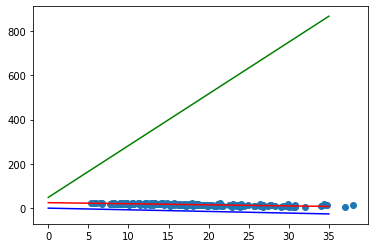

In [35]:
data_pt = Tensor(data)
ax = plt.subplot(1, 1, 1)
plt.scatter(x_trunc, y_trunc)
plt.plot(data, trunc_ols.predict(data), color='red', label='trunc ols')
plt.plot(data, ols_stand.predict(data), color='blue', label='gt')
plt.plot(data, known_results(data_pt).detach().cpu(), label='known', color='green')

In [ ]:
# truncated linear regression with known noise variance using actual noise variance
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_var = Tensor((y_trunc - trunc_ols.predict(x_trunc)).var(0))
known_emp_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=trunc_var)
known_emp_results = known_emp_trunc_reg.fit(x_trunc_pt, y_trunc_pt)
w__, w0__ = known_emp_results.weight.detach().cpu(), known_emp_results.bias.detach().cpu()

plt.plot(data_stand_pt, known_emp_results(data_stand_pt).detach().cpu(), label='known emp', color='orange')

In [19]:
# truncated linear regression with unknown noise variance
unknown_trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias)
unknown_results = unknown_trunc_reg.fit(x_trunc_pt, y_trunc_pt)
var_ = unknown_results.lambda_.inverse().detach()
w, w0 = (unknown_results.layer.weight.detach()*var_).cpu(), (unknown_results.layer.bias.detach()*var_).cpu()

plt.plot(data_stand_pt, unknown_results(data_stand_pt).detach().cpu(), label='unknown', color='purple')

(array([0.44728265]), tensor([0.0974]))

# Create Correlation Matrix
Create a correlation matrix to see which indices' performances are closely correlated with one another.

(              ISE     ISE.1        SP       DAX      FTSE    NIKKEI   BOVESPA  \
 ISE      1.000000  0.942897  0.439489  0.602081  0.622948  0.260052  0.432898   
 ISE.1    0.942897  1.000000  0.449561  0.629218  0.648740  0.393225  0.446889   
 SP       0.439489  0.449561  1.000000  0.685843  0.657673  0.131250  0.722069   
 DAX      0.602081  0.629218  0.685843  1.000000  0.867369  0.258538  0.585791   
 FTSE     0.622948  0.648740  0.657673  0.867369  1.000000  0.255236  0.596287   
 NIKKEI   0.260052  0.393225  0.131250  0.258538  0.255236  1.000000  0.172752   
 BOVESPA  0.432898  0.446889  0.722069  0.585791  0.596287  0.172752  1.000000   
 EU       0.655519  0.690761  0.687550  0.936393  0.948963  0.283750  0.621704   
 EM       0.600295  0.701954  0.528243  0.665162  0.687543  0.547288  0.688074   
 
                EU        EM  
 ISE      0.655519  0.600295  
 ISE.1    0.690761  0.701954  
 SP       0.687550  0.528243  
 DAX      0.936393  0.665162  
 FTSE     0.948963  0.6

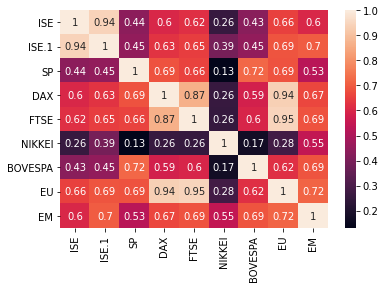

In [37]:
indices = ist_df.drop(['date'], axis=1)
corr_matrix = indices.corr()
corr_matrix, sns.heatmap(corr_matrix, annot=True)

ValueError: Expected 2D array, got 1D array instead:
array=[ 2.8524462e-02  8.7726440e-03 -2.0015412e-02 -1.9423778e-02
 -7.8022120e-03 -2.2629745e-02 -4.8271380e-03 -8.6766460e-03
 -2.3428729e-02  1.0916893e-02 -4.0290040e-03 -2.4107193e-02
 -5.0922420e-03 -3.2272490e-03 -8.0773190e-03  1.0319685e-02
  6.3444980e-03  2.2104103e-02  4.0869700e-04  2.2425390e-03
 -1.9091385e-02  1.2718686e-02  1.5165589e-02  2.0725050e-03
  3.2338114e-02  7.8953940e-03 -2.1390950e-03 -7.9259970e-03
 -1.4772748e-02  1.7764444e-02 -6.8504410e-03 -3.8322771e-02
 -3.3422610e-03  6.7644980e-03 -2.7294442e-02  9.6778700e-03
 -1.1881112e-02  6.0993640e-03 -2.3311640e-03 -6.1501310e-03
 -3.5364882e-02  1.2903070e-03  3.0311506e-02 -8.6718380e-03
 -2.0976470e-03 -5.5583640e-03  2.4909954e-02  1.2815720e-02
  5.4194750e-03  1.8689238e-02  1.0253879e-02  2.6886910e-03
  6.0125060e-03  9.8472740e-03 -6.6543520e-03  4.4121571e-02
  2.2960450e-03  8.3096520e-03  1.6417645e-02 -6.7308610e-03
 -3.8564463e-02  7.8342210e-03  1.5339491e-02  3.8506193e-02
  4.3115210e-03  4.1919310e-03 -5.5658620e-03 -7.5010840e-03
  2.7695855e-02  5.3859960e-03  5.8796360e-03  7.4141130e-03
  2.7112800e-03  2.4386900e-03 -5.5259220e-03 -8.3578480e-03
 -7.2765740e-03 -9.6667200e-04  2.2915147e-02 -1.8736720e-02
 -1.3223984e-02  2.5812429e-02  1.6444765e-02  4.7804531e-02
  4.0358260e-03  1.1737376e-02 -2.4674100e-03  1.0330863e-02
 -5.5793550e-03 -2.2450180e-03 -1.0673606e-02 -1.1305019e-02
  8.1604910e-03  2.7348038e-02  2.3405287e-02 -1.7031881e-02
  2.1300800e-03  8.4148300e-04 -5.3314990e-03  1.6360679e-02
  8.5828940e-03  7.7607510e-03  2.9978301e-02 -6.6305410e-03
 -1.3026704e-02 -1.2836520e-03  7.1952010e-03 -1.0536916e-02
 -5.1488880e-03  1.9623396e-02  2.8885940e-03 -2.1802220e-03
 -2.1109333e-02 -9.4526940e-03 -1.3276347e-02 -9.8276680e-03
  7.5049720e-03 -1.1895017e-02 -1.4676581e-02  1.6991546e-02
  1.3359036e-02  9.8960250e-03  3.0092710e-03 -6.9320940e-03
  1.1049660e-02 -4.8370230e-03  8.6407400e-04 -1.3954751e-02
 -2.3886980e-03 -7.9451760e-03  3.5460830e-03 -3.4568860e-03
 -1.3401351e-02  1.6832183e-02  2.7435226e-02  6.0221860e-03
  1.0282347e-02  2.3092409e-02  1.5261310e-03 -4.7101160e-03
  1.6398626e-02  3.7121470e-03  9.2793970e-03  3.4953230e-03
 -1.3102375e-02  1.0000404e-02  1.0755726e-02  1.6159052e-02
 -3.3486350e-03 -4.8601920e-03  1.6241730e-03 -2.6214740e-03
  4.1962700e-03 -6.1165710e-03 -6.3977620e-03  1.3275554e-02
 -1.4268940e-03 -2.9772410e-02  2.8530290e-03 -3.3500040e-03
  1.3296568e-02  6.8128720e-03  1.6065598e-02 -1.4647000e-03
 -1.9992120e-03 -6.4736570e-03  5.0249770e-03 -1.2832464e-02
  3.5967360e-03 -8.3209490e-03  8.1171620e-03  9.7020450e-03
  1.0025827e-02  1.3928806e-02 -2.7460530e-03  9.2336710e-03
  3.6062540e-03 -8.4051980e-03  8.3231680e-03  1.5813252e-02
  5.7615810e-03  4.1240200e-04 -4.0044960e-03 -1.0152977e-02
 -5.9241000e-04 -3.1916720e-03  8.9619240e-03 -7.4382300e-04
 -3.2330470e-03 -8.7413000e-03  1.9919380e-03  1.3076211e-02
  4.2959810e-03  7.6959800e-03  6.1762620e-03  4.3436610e-03
  4.4805700e-05  1.6426627e-02  1.7767090e-03 -6.1992400e-03
  1.0830679e-02 -3.2481570e-03 -2.4971660e-03 -5.0116150e-03
  3.9199970e-03  2.5568600e-04 -1.4859632e-02 -2.5950650e-02
 -6.0250000e-03 -1.5357580e-03 -7.3530450e-03  1.8558259e-02
  2.3635800e-03  4.1299330e-03  1.7839994e-02  4.4110330e-03
  7.9785840e-03 -1.0681845e-02  2.9166710e-03  1.5692940e-02
  9.1743700e-04 -1.7843460e-03 -5.4479130e-03 -3.1167930e-03
  7.9849550e-03 -4.3663850e-03  4.2116320e-03 -4.4156350e-03
  5.9855340e-03  3.0236680e-03 -7.4596700e-05  4.0313700e-04
 -6.0069250e-03 -4.4785450e-03  3.1913540e-03  5.5243480e-03
  4.3251800e-03 -3.2269270e-03 -1.7441630e-03 -9.6051130e-03
 -3.6792240e-03 -3.7709280e-03  9.2370220e-03  7.8035150e-03
  4.7806220e-03  3.4036900e-04  4.1420790e-03 -1.9054200e-04
  3.4084900e-04  6.8544900e-03  8.3990100e-03  8.0667400e-03
  5.3296200e-03 -6.3746550e-03  1.2292530e-03  5.4473720e-03
 -3.7292030e-03 -7.2634520e-03  2.3126790e-03 -2.0564520e-03
  1.7253960e-03  2.1186340e-03 -9.0507560e-03 -1.4855548e-02
 -1.2384604e-02 -4.1436340e-03 -1.7437655e-02 -7.2753560e-03
  1.0577309e-02 -6.3147580e-03  1.8169170e-03  1.1540040e-03
  1.1540842e-02 -1.9774104e-02 -2.7290000e-02 -3.8095340e-03
  1.2960538e-02  3.3369980e-03  1.1111300e-02 -2.3541580e-03
  2.2962930e-03  5.9473440e-03  1.0310325e-02 -2.3261620e-03
 -8.2352510e-03  8.0188180e-03 -1.8261450e-03 -6.3946270e-03
 -6.9276620e-03  7.7457930e-03  1.1574976e-02  8.2837400e-03
  3.7119960e-03 -4.0674710e-03  1.0645201e-02  9.7562690e-03
  1.2884320e-03  2.8521830e-03 -2.2851290e-03  2.8170400e-05
 -7.5400200e-03  6.6789350e-03  1.1753411e-02 -1.1850800e-04
 -1.7471530e-03 -5.9585800e-03  2.0491520e-03 -2.8002300e-04
 -3.3214100e-05  4.2335820e-03  6.6570040e-03  3.3224910e-03
 -1.5373990e-03  1.3451580e-02  1.2291910e-03  4.4522190e-03
  2.9491780e-03  3.1247760e-03 -3.6274600e-03  3.9424230e-03
 -5.1791590e-03 -3.7993750e-03  7.5073310e-03  5.0823900e-06
 -1.2591087e-02 -1.5519306e-02  8.9430000e-03  2.5156980e-03
 -3.1796460e-03  8.7683590e-03 -1.1889142e-02 -9.7229410e-03
  2.9710640e-03  4.1646990e-03 -7.5868660e-03 -1.2506440e-02
 -1.3384167e-02 -1.3554059e-02 -1.4724997e-02  2.5317649e-02
 -6.5663750e-03  7.1674100e-03  5.7799770e-03 -1.1049522e-02
 -1.3753547e-02 -2.4190640e-03 -3.6374727e-02  1.1243900e-03
  5.1101200e-03 -2.7590293e-02  2.1561990e-02  1.7184219e-02
  7.1759840e-03  1.1325081e-02 -1.5882222e-02  3.4443050e-03
  1.1455399e-02 -6.2334920e-03 -1.5968381e-02  7.2362900e-04
  1.7334000e-03  1.0020454e-02  8.7738700e-03  7.8778990e-03
  7.1884070e-03  3.3326110e-03  2.6063710e-03  2.1347840e-03
  1.7326939e-02 -6.9127940e-03 -2.0683450e-03 -6.7167060e-03
 -2.3107320e-03  5.3971000e-04 -2.1032886e-02 -6.9621820e-03
 -6.8196750e-03  5.1391700e-04 -9.2697400e-04  1.5586943e-02
  9.8697900e-04  7.5051030e-03  8.6059120e-03  2.2280340e-03
  3.9105110e-03  3.6162720e-03 -4.8701610e-03 -6.4727790e-03
  1.0505200e-04  7.1966940e-03  8.8801240e-03  6.1886300e-03
  7.3364150e-03  2.3044610e-03  2.0069690e-03  7.7241700e-04
  1.4322710e-03 -3.2949770e-03  1.5749215e-02 -2.4982590e-03
  1.5739900e-03 -6.4004900e-04 -1.8461390e-03  3.6115270e-03
 -9.9664020e-03 -1.4113080e-02 -5.3188780e-03  4.7252680e-03
  3.2664430e-03  4.8058490e-03  1.3057700e-04  1.1387500e-03
 -2.4962440e-03 -1.4684600e-03 -9.7305800e-03 -9.6624370e-03
 -7.5537600e-04  5.0807610e-03  2.0054100e-03  1.4404659e-02
  3.6541030e-03  5.0497740e-03  7.3140740e-03 -1.8965650e-03
 -3.6414650e-03  2.2418509e-02  1.6577500e-04  3.3231940e-03
 -4.8825820e-03  3.1067360e-03  6.7711260e-03  7.9196100e-04
  3.1816900e-04 -2.3788900e-04  1.3771450e-03  5.5335770e-03
 -9.6579000e-04  6.1452590e-03  3.5122100e-03  5.1749240e-03
  4.9254640e-03  3.4817820e-03  4.9542630e-03 -5.2921310e-03
  9.7749700e-04  3.2263810e-03 -4.0851440e-03  1.1802246e-02
  5.0348550e-03 -3.1618030e-03 -5.2279740e-03 -6.0337200e-03
  4.4237500e-04  4.9848670e-03  8.9246200e-05  6.8811870e-03
  2.8301170e-03 -1.0151847e-02  1.4253551e-02  4.6551600e-04
  5.9921720e-03  1.0736761e-02  4.1655550e-03  3.1281960e-03
 -1.6442940e-03 -2.2212120e-03 -7.6525580e-03 -1.1377315e-02
 -1.4390760e-03 -1.8275090e-03 -1.5299989e-02  5.5902220e-03
  3.6689700e-04 -9.0881370e-03  5.4317200e-04 -4.9979130e-03
  1.5463595e-02  1.1647698e-02  2.1337190e-03  2.9512060e-03
  1.0685240e-03 -7.6495490e-03  9.6820700e-04 -8.9223600e-04
  5.1501310e-03  2.9709050e-03 -5.4336990e-03 -5.2807880e-03
  3.6264230e-03 -3.5649930e-03  9.4688990e-03  1.3269800e-03
 -2.0793700e-04 -2.4748510e-03 -2.4166890e-03 -1.9552700e-04
  7.8614660e-03  3.3135800e-03  2.7893870e-03  8.1676700e-03
  4.2387550e-03 -1.1801170e-03 -2.6460260e-03 -6.8197100e-03
 -6.7086800e-03  4.7726140e-03  1.1872228e-02 -2.1093220e-03
  2.3762000e-04 -4.5367070e-03  2.4058770e-03  1.0857680e-03
 -1.0442022e-02 -6.8535210e-03 -1.1447550e-03 -8.8548900e-04
  5.0185250e-03 -1.1489030e-03 -9.9119190e-03 -5.7887190e-03
  6.2238650e-03  3.6313220e-03  4.7605500e-04 -3.1849350e-03
 -3.3457200e-03 -4.4989940e-03 -1.4248555e-02 -1.4759632e-02
  3.9308820e-03  1.3448054e-02 -1.4304470e-03  3.0389860e-03
  1.0385850e-03  6.9378730e-03 -9.5773600e-04 -1.4296931e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

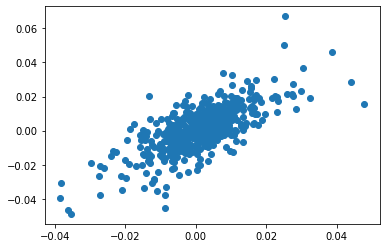

In [30]:
em, eu = ist_df['EM'].to_numpy().reshape(-1, 1), ist_df['EU'].to_numpy().reshape(-1, 1)
plt.scatter(em, eu)
lin_reg = LinearRegression()
lin_reg.fit(ist_df['EM'].to_numpy().reshape(-1, 1), ist_df['EU'].to_numpy().reshape(-1, 1))
print(lin_reg.predict(ist_df['EM']))
plt.plot(ist_df['EM'], lin_reg.predict(ist_df['EM']).reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Data Preprocessing
Select the performance results for the EM and EU indices. Since, the performance results are expressed in decimals (because they are percentages) and are extremely small, we standardize the data, so that are gradients aren't negatively influenced by the magnitude of the performance rates.

In [38]:
X = ch.from_numpy(np.expand_dims(indices['EM'], 1))
y = ch.from_numpy(np.expand_dims(indices['EU'], 1))

# standardize data, so that the values are not all small floating points
X_scaler, y_scaler = preprocessing.StandardScaler().fit(X), preprocessing.StandardScaler().fit(y)
X, y = ch.from_numpy(X_scaler.transform(X)).float(), ch.from_numpy(y_scaler.transform(y))

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [62]:
# experiment hyperparameters
args = Parameters({ 
    'epochs': 100,
    'workers': 2, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 2.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'unknown': True,
    'trials': 1,
})
print("args: ", args)

args:  {
  "epochs": 100,
  "workers": 2,
  "batch_size": 100,
  "bias": true,
  "num_samples": 1000,
  "clamp": true,
  "radius": 2.0,
  "var_lr": 0.01,
  "lr": 0.1,
  "unknown": true,
  "trials": 1
}


# Create Store for Experiment Results

In [43]:
STORE_PATH = '/home/pstefanou/Regression/Istanbul'
STORE_TABLE_NAME = 'results'

# create store
s = Store(STORE_PATH)
s.add_table(STORE_TABLE_NAME, { 
    'known_emp_param_mse': float,
    'known_param_mse': float,
    'unknown_param_mse': float,
    'unknown_var_mse': float,
    'ols_param_mse': float,
    'ols_var_mse': float,
#     'trunc_reg_param_mse': float, 
#     'trunc_var_mse': float,
    'alpha': float, 
    'c': float, 
    'num_samples': int,
})

Logging in: /home/pstefanou/Regression/Istanbul/bc6316b0-bb24-4c08-a721-25e07cee329b


# Run Procedure

In [ ]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(X, y)
gt_params = Tensor(np.concatenate([gt.coef_, np.expand_dims(gt.intercept_, 0)], axis=1))
gt_var = Tensor(np.var(gt.predict(X) - y.numpy(), 0))

for i in range(args.trials):
    C = [-1, -.75, -.5, -.25, 0, .25]
    for c in C: 
        # truncate
        phi = Left(Tensor([c]))
        trunc_indices = phi(y).nonzero(as_tuple=False).flatten()
        x_trunc, y_trunc = X[trunc_indices], y[trunc_indices].float()
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.shape[0] / X.shape[0]])
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]

        # truncated linear regression with known noise variance using empirical noise variance
        trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=ols_var)
        results = trunc_reg.fit(x_trunc, y_trunc)
        w_, w0_ = results.weight.detach().cpu(), results.bias.detach().cpu()

        # truncated linear regression with known noise variance using actual noise variance
        trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=gt_var)
        results = trunc_reg.fit(x_trunc, y_trunc)
        w__, w0__ = results.weight.detach().cpu(), results.bias.detach().cpu()

        # truncated linear regression with unknown noise variance
        trunc_reg = TruncatedLinearRegression(phi=phi, alpha=alpha, args=args, bias=args.bias)
        results = trunc_reg.fit(x_trunc, y_trunc)
        var_ = results.lambda_.inverse().detach()
        w, w0 = (results.v.detach()*var_).cpu(), (results.bias.detach()*var_).cpu()

        with ch.no_grad():
            known_params = ch.cat([w_.T, w0_[...,None]], dim=1)
            
            known_emp_params = ch.cat([w__.T, w0__[...,None]], dim=1)
            
            unknown_params = ch.cat([w.T, w0], dim=1)
            unknown_var = var_

            ols_params = Tensor(np.concatenate([ols.coef_, np.expand_dims(ols.intercept_, 0)], axis=1))
            ols_var = Tensor(np.var(ols.predict(x_trunc) - y_trunc.numpy(), 0))

            s[STORE_TABLE_NAME].append_row({ 
                'known_emp_param_mse': ch.nn.MSELoss()(known_emp_params, gt_params),
                'known_param_mse': ch.nn.MSELoss()(known_params, gt_params),
                'unknown_param_mse': ch.nn.MSELoss()(unknown_params, gt_params), 
                'unknown_var_mse': ch.nn.MSELoss()(unknown_var, gt_var),
                'ols_param_mse': ch.nn.MSELoss()(ols_params, gt_params), 
                'ols_var_mse': ch.nn.MSELoss()(ols_var, gt_var), 
                'alpha': float(alpha), 
                'c': c,    
                'num_samples': x_trunc.size(0),

            })
            
# close current store
s.close()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/home/pstefanou/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/home/pstefanou/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [89]:
ch.nn.MSELoss()(ols_params, gt_params)

NameError: name 'ols_params' is not defined

# Results

In [15]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 5/5 [00:00<00:00, 239.77it/s]


,c,pred_var_mse,pred_param_mse,emp_var_mse,emp_param_mse,exp_id
0,-1.00,0.008450,0.013141,0.010971,0.026666,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
1,-0.75,0.041437,0.067314,0.042745,0.078930,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
2,-0.50,0.009972,0.030401,0.012456,0.052398,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
3,-0.25,0.023096,0.051561,0.024455,0.078662,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
4,0.00,0.032857,0.139660,0.032722,0.173678,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8


# Plot Results

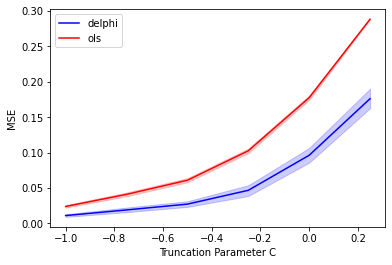

In [16]:
# plot results for regression parameter MSE
sns.lineplot(data=results, x='c', y='pred_param_mse', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='c', y='emp_param_mse', label='ols', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
plt.show()

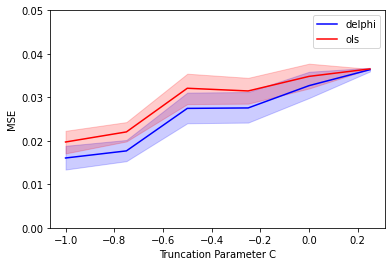

In [17]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='pred_var_mse', label='delphi', color="blue")
ax = sns.lineplot(data=results, x='c', y='emp_var_mse', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
ax.set(ylim=(0, .05))
plt.show()